# Validation of the Langevin SDE model for Hes1 simulation

## Imports

In [1]:
import hes1_langevin_Antoine as langevin
import hes1_master_Antoine as master
import hes1_utils_Antoine as utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate as spinter
import scipy.fft
import time
import datetime as dt
import os

import warnings
warnings.filterwarnings("ignore")

## Reminders

Here, we study the Hes1 system. Its governing reactions are stated hereafter.
\begin{align*}
     && M &\xrightarrow{\mu_m} \emptyset && (1) \\
     && P &\xrightarrow{\mu_p} \emptyset && (2) \\
     && M &\xrightarrow{\alpha_p} M+P    && (3) \\
     && \emptyset &\xrightarrow{\alpha_\sigma, \tau} M && (4) \\
     && \sigma_{ON} &\xrightarrow{\lambda (P/P_0)^h} \sigma_{OFF} && (5) \\
     && \sigma_{OFF} &\xrightarrow{\lambda} \sigma_{ON} && (6)
\end{align*}

with the following parameters

$-$ mRNA production rate: $\alpha_\sigma = \alpha_m := 1$ (the non repressed mRNA production rate) if $\sigma = \sigma_{ON}$, $0$ otherwise.

$-$ mRNA production delay $\tau$ (in equation (4)).

$-$ Hes1 production rate: $\alpha_p:=1$.

$-$ mRNA and Hes1 deprecation rates: $\mu_m,\mu_p := 0.03$.

$-$ Hill coefficient $h:=5$, switching rate $\lambda$, system size $\Omega$.

Our objective is to validate the Langevin SDE model by comparison with a direct derivation from the master equation (Gillespie algorithm), in the limit of large system and fast switching environment. Hence, we investigate the effect of the variation of $\lambda$, $\Omega$ and $\tau$ on the trajectories of mRNA and Hes1 concentrations. We state the governing equations hereafter:

The master equation
$$\frac{dp}{dt}(l,\sigma,t) = \mathcal{M}_{l,\sigma}^D[p](l,\sigma,t)  + \lambda \sum_{\sigma'} A_{l,\sigma' \rightarrow \sigma}^D.p(l,\sigma',t)$$

with operators and coefficients
\begin{align*}
    \mathcal{M}_\sigma^{D,\tau}(l)[p](l,\sigma,t) &= \mu_m (\mathcal{E}_M-1)[n_m p(l,\sigma,t)] + \mu_p (\mathcal{E}_P-1)[n_p p(l,\sigma,t)] \\
    &+ \alpha_p (\mathcal{E}_P^{-1}-1)[n_m p(l,\sigma,t)] + \alpha_{m} \Omega (\mathcal{E}_M^{-1}-1) [p(l,\sigma,t;\sigma(t-\tau)=\sigma_{ON})] \nonumber \\
    A_{\sigma_{OFF} \rightarrow \sigma_{ON}}^D(l) &= 1  \\
    A_{\sigma_{ON} \rightarrow \sigma_{OFF}}^D(l) &= (n_p/n_{p_0})^h\\
    A_{\sigma_{ON} \rightarrow \sigma_{ON}}^D(l) &= - (n_p/n_{p_0})^h\\
    A_{\sigma_{OFF} \rightarrow \sigma_{OFF}}^D(l) &= -1
\end{align*}

The Langevin system of SDEs
\begin{align}
    dM &\approx \frac{\alpha_m}{1+(P(t-\tau)/P_0)^h}dt - \mu_m M dt \label{langevin-M}\\
    &+ \sqrt{ \frac{\alpha_m \Omega^{-1}}{1+(P(t-\tau)/P_0)^h} + \mu_m\Omega^{-1} M + \frac{\alpha_m^2}{\lambda} \frac{2(P(t-\tau)/P_0)^h}{[1+(P(t-\tau)/P_0)^h]^3} } dW_t \nonumber\\
    dP &\approx \alpha_p M dt - \mu_p P dt + \sqrt{\alpha_p\Omega^{-1} M + \mu_p\Omega^{-1} P} dW_t \label{langevin-P}
\end{align}

______

# SANDBOX

This section is made to "play" with the parameteres, in order to understand their influence on the system.
Plus, it presents the approach to obtain the plots we included in the dissertation document (stationary mean, standard deviation and power spectrum).

## Transient regime

In this section, we study the Hes1 transient regime. We propose plots of trajectories and "average" trajectories.

### mRNA and Hes1 trajectories

We simply plot the mRNA and Hes1 concentrations hereafter, for each model.

In [ ]:
tm,Mm,Pm=master.one_trajectory(tau=1000,lambda_s=0.01,Omega=100,P_0=100,T=8000)
tl,Ml,Pl=langevin.one_trajectory(tau=1000,lambda_s=0.01,Omega=100,P_0=100,T=8000)


In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(tm,Mm,color="red")
ax1.plot(tl,Ml,color="blue")


In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(tm,Pm,color="red")
ax1.plot(tl,Pl,color="blue")


In [ ]:
tm,Mm,Pm=master.one_trajectory(lambda_s=1,tau=18.5,P_0=100,h=5,T=1000)
tl,Ml,Pl=langevin.one_trajectory(lambda_s=1,tau=18.5,P_0=100,h=5,T=1000)

plt.plot(tm,Mm)
plt.plot(tl,Ml)


In [ ]:
plt.plot(tm,Pm)
plt.plot(tl,Pl)

### "Average" trajectory

We want to compare the average trajectories to the one given by the deterministic resolution. This average trajectory is computed over multiple realisations of mRNA and Hes1 trajectories.

In [ ]:
n_iter=500
tl,table_Ml,table_Pl=langevin.multiple_trajectories(n_iter=n_iter,lambda_s=0.1,tau=25,P_0=1000,h=5,M_init=3,T=5000,delta_t=1,Omega=1)

Ml=np.mean(table_M,axis=0)
Pl=np.mean(table_P,axis=0)

_,power_spectrum_l=utils.compute_power_spectrum(tl,table_P)

In [ ]:
n_iter=500
t_ref,table_Mm,table_Pm=master.multiple_trajectories(n_iter=n_iter,lambda_s=0.1,tau=25,P_0=1000,h=5,M_init=3,T=5000,Omega=1)

Mm=np.mean(table_M,axis=0)
Pm=np.mean(table_P,axis=0)

In [ ]:
_,Mr,Pr=langevin.resolve_ODE(tau=18.5,P_0=1000,h=5,M_init=3,T=5000)

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(t_ref,Mm,color="red")
plt.plot(tl,Ml,color="blue")
plt.plot(tl,Mr,color="green")

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(t_ref,Pm,color="red")
plt.plot(tl,Pl,color="blue")
plt.plot(tl,Pr,color="green")

### Comparison of M & P trajectories

We want to check if the Hes1 trajectory roughly follows the mRNA one, with a delay of the order of $\tau$. 

In [ ]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('X-axis') 
ax1.set_ylabel('Y1-axis', color = 'red') 
ax1.plot(t_ref[:600], Mm[:600], color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Y2-axis', color = 'blue') 
ax2.plot(t_ref[:600], Pm[:600], color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
 
# Show plot

plt.show()

In [ ]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('X-axis') 
ax1.set_ylabel('Y1-axis', color = 'red') 
ax1.plot(t_ref[:600], Ml[:600], color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Y2-axis', color = 'blue') 
ax2.plot(t_ref[:600], Pl[:600], color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
 
# Show plot

plt.show()

### Power spectrum

We plot here the mRNA and Hes1 power spectra, for both models and for the linear noise approximation model. 

In [ ]:
omega,power_spectrum_Mm = utils.compute_power_spectrum(t,table_Mm)
_,power_spectrum_Ml = utils.compute_power_spectrum(t,table_Ml)
_,power_spectrum_Pm = utils.compute_power_spectrum(t,table_Pm)
_,power_spectrum_Pl = utils.compute_power_spectrum(t,table_Pl)

In [ ]:
plt.plot(omega,power_spectrum_Mm)
plt.plot(omega,power_spectrum_Ml)

In [ ]:
plt.plot(omega,power_spectrum_Pm)
plt.plot(omega,power_spectrum_Pl)

## Stationary distribution

Here we want to compare the stationary distributions, in terms of mean, standard deviation and histograms.

In [ ]:
pool_Ml,pool_Pl=langevin.pool_values(n_iter=100,tau=10,lambda_s=0.1,P_0=100,Omega=100)
pool_Mm,pool_Pm=master.pool_values(n_iter=100,tau=10,lambda_s=0.1,P_0=100,Omega=100)

##### Mean

In [ ]:
print(np.mean(pool_Mm),np.mean(pool_Ml))
print(np.mean(pool_Pm),np.mean(pool_Pl))

##### STD

In [ ]:
print(np.std(pool_Mm),np.std(pool_Ml))
print(np.std(pool_Pm),np.std(pool_Pl))

##### Histograms

In [ ]:
hist_Mm=plt.hist(pool_Mm,bins=50,range=(0,50),histtype='step',density=True,color='red')
hist_Ml=plt.hist(pool_Ml,bins=50,range=(0,50),histtype='step',density=True,color='blue')

In [ ]:
hist_Pm=plt.hist(pool_Pm,bins=50,range=(0,600),histtype='step',density=True)
hist_Pl=plt.hist(pool_Pl,bins=50,range=(0,600),histtype='step',density=True)

---

# MAKING PLOTS

We make the plots that are included in the dissertation document.

#### Trajectories

#### Computation of power spectrum, mean, std depending on $\lambda$, $\Omega$, $\tau$

First, we compute all the stationary means, STDs and power spectra at once.

In [2]:
alpha_m=1
alpha_p=1
mu_m=0.03
mu_p=0.03
h=5
P_0=1000

T=10000
delta_t=1

n_t=int(T/delta_t)

In [3]:
val_lambda=[0.01,0.1,1,10,100]
val_Omega=[1,10,100]
val_tau=[0.001,18.5,100]
n_lambda=np.size(val_lambda)
n_Omega=np.size(val_Omega)
n_tau=np.size(val_tau)

std_Mm=np.zeros((n_lambda,n_Omega,n_tau))
std_Ml=np.zeros((n_lambda,n_Omega,n_tau))

std_Pm=np.zeros((n_lambda,n_Omega,n_tau))
std_Pl=np.zeros((n_lambda,n_Omega,n_tau))

mean_Mm=np.zeros((n_lambda,n_Omega,n_tau))
mean_Ml=np.zeros((n_lambda,n_Omega,n_tau))

mean_Pm=np.zeros((n_lambda,n_Omega,n_tau))
mean_Pl=np.zeros((n_lambda,n_Omega,n_tau))

power_spectrum_Mm=np.zeros((n_t//2,n_lambda,n_Omega,n_tau),dtype=np.ndarray)
power_spectrum_Ml=np.zeros((n_t//2,n_lambda,n_Omega,n_tau),dtype=np.ndarray)

power_spectrum_Pm=np.zeros((n_t//2,n_lambda,n_Omega,n_tau),dtype=np.ndarray)
power_spectrum_Pl=np.zeros((n_t//2,n_lambda,n_Omega,n_tau),dtype=np.ndarray)

In [ ]:
for i in range(n_lambda):
    for j in range(n_Omega):
        for k in range(n_tau):
            
            print("lambda=",val_lambda[i])
            print("Omega=",val_Omega[j])
            print("tau=",val_tau[k])
            
            output=utils.compute_fourier_transform_mean_and_std(n_iter=500,lambda_s=val_lambda[i],        
                                                      P_0=P_0,
                                                      h=h,
                                                      tau=val_tau[k],
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      delta_t=delta_t,
                                                      Omega=val_Omega[j])            
            
            t_ref=output["times"]
            freq_ref=output["frequencies"]
            
            std_Mm[i,j,k]=output["std Mm"]
            std_Ml[i,j,k]=output["std Ml"]

            std_Pm[i,j,k]=output["std Pm"]
            std_Pl[i,j,k]=output["std Pl"]

            mean_Mm[i,j,k]=output["mean Mm"]
            mean_Ml[i,j,k]=output["mean Ml"]

            mean_Pm[i,j,k]=output["mean Pm"]
            mean_Pl[i,j,k]=output["mean Pl"]

            power_spectrum_Mm[:,i,j,k]=output["power spectrum Mm"]
            power_spectrum_Ml[:,i,j,k]=output["power spectrum Ml"]
            
            power_spectrum_Pm[:,i,j,k]=output["power spectrum Pm"]
            power_spectrum_Pl[:,i,j,k]=output["power spectrum Pl"]

            print("Done")
            print("\n")
        

#### Saves 

Then save them.

In [ ]:
current_directory = os.getcwd()
date=str(dt.datetime.today())[:19]
date=date[:13]+'-'+date[14:16]+'-'+date[17:]
new_directory = current_directory + '\\output '+ date

os.makedirs(new_directory)
os.makedirs(new_directory+'\\data')
os.makedirs(new_directory+'\\plots')

In [ ]:
pd.DataFrame(t_ref,columns=['value']).to_csv(new_directory+'\\data\\times.csv')
pd.DataFrame(freq_ref,columns=['value']).to_csv(new_directory+'\\data\\freq.csv')

pd.DataFrame(std_Mm.reshape((n_lambda*n_Omega*n_tau)),columns=['value']).to_csv(new_directory+'\\data\\std_Mm.csv')
pd.DataFrame(std_Ml.reshape((n_lambda*n_Omega*n_tau)),columns=['value']).to_csv(new_directory+'\\data\\std_Ml.csv')
pd.DataFrame(std_Pm.reshape((n_lambda*n_Omega*n_tau)),columns=['value']).to_csv(new_directory+'\\data\\std_Pm.csv')
pd.DataFrame(std_Pl.reshape((n_lambda*n_Omega*n_tau)),columns=['value']).to_csv(new_directory+'\\data\\std_Pl.csv')

pd.DataFrame(mean_Mm.reshape((n_lambda*n_Omega*n_tau)),columns=['value']).to_csv(new_directory+'\\data\\mean_Mm.csv')
pd.DataFrame(mean_Ml.reshape((n_lambda*n_Omega*n_tau)),columns=['value']).to_csv(new_directory+'\\data\\mean_Ml.csv')
pd.DataFrame(mean_Pm.reshape((n_lambda*n_Omega*n_tau)),columns=['value']).to_csv(new_directory+'\\data\\mean_Pm.csv')
pd.DataFrame(mean_Pl.reshape((n_lambda*n_Omega*n_tau)),columns=['value']).to_csv(new_directory+'\\data\\mean_Pl.csv')

pd.DataFrame(power_spectrum_Mm.reshape((n_t//2*n_lambda*n_Omega*n_tau)),columns=['value']).to_csv(new_directory+'\\data\\power_spectrum_Mm.csv')
pd.DataFrame(power_spectrum_Ml.reshape((n_t//2*n_lambda*n_Omega*n_tau)),columns=['value']).to_csv(new_directory+'\\data\\power_spectrum_Ml.csv')
pd.DataFrame(power_spectrum_Pm.reshape((n_t//2*n_lambda*n_Omega*n_tau)),columns=['value']).to_csv(new_directory+'\\data\\power_spectrum_Pm.csv')
pd.DataFrame(power_spectrum_Pl.reshape((n_t//2*n_lambda*n_Omega*n_tau)),columns=['value']).to_csv(new_directory+'\\data\\power_spectrum_Pl.csv')

## Plots

Now we load the data files.

In [4]:
read_directory = os.getcwd() + '\\output'       #specify here the folder you want to read
#read_directory = new_directory

In [5]:
t_ref=pd.read_csv(read_directory+'\\data\\times.csv')['value'].values
freq_ref=pd.read_csv(read_directory+'\\data\\freq.csv')['value'].values

std_Mm=pd.read_csv(read_directory+'\\data\\std_Mm.csv')['value'].values.reshape((n_lambda,n_Omega,n_tau))
std_Ml=pd.read_csv(read_directory+'\\data\\std_Ml.csv')['value'].values.reshape((n_lambda,n_Omega,n_tau))
std_Pm=pd.read_csv(read_directory+'\\data\\std_Pm.csv')['value'].values.reshape((n_lambda,n_Omega,n_tau))
std_Pl=pd.read_csv(read_directory+'\\data\\std_Pl.csv')['value'].values.reshape((n_lambda,n_Omega,n_tau))

mean_Mm=pd.read_csv(read_directory+'\\data\\mean_Mm.csv')['value'].values.reshape((n_lambda,n_Omega,n_tau))
mean_Ml=pd.read_csv(read_directory+'\\data\\mean_Ml.csv')['value'].values.reshape((n_lambda,n_Omega,n_tau))
mean_Pm=pd.read_csv(read_directory+'\\data\\mean_Pm.csv')['value'].values.reshape((n_lambda,n_Omega,n_tau))
mean_Pl=pd.read_csv(read_directory+'\\data\\mean_Pl.csv')['value'].values.reshape((n_lambda,n_Omega,n_tau))

power_spectrum_Mm=pd.read_csv(read_directory+'\\data\\power_spectrum_Mm.csv')['value'].values.reshape((n_t//2,n_lambda,n_Omega,n_tau))
power_spectrum_Ml=pd.read_csv(read_directory+'\\data\\power_spectrum_Ml.csv')['value'].values.reshape((n_t//2,n_lambda,n_Omega,n_tau))
power_spectrum_Pm=pd.read_csv(read_directory+'\\data\\power_spectrum_Pm.csv')['value'].values.reshape((n_t//2,n_lambda,n_Omega,n_tau))
power_spectrum_Pl=pd.read_csv(read_directory+'\\data\\power_spectrum_Pl.csv')['value'].values.reshape((n_t//2,n_lambda,n_Omega,n_tau))

Then make directories for plotting each relevant figure.

In [6]:
try:
    os.makedirs(read_directory+'\\plots\\trajectories')
    os.makedirs(read_directory+'\\plots\\mean_M')
    os.makedirs(read_directory+'\\plots\\mean_P')
    os.makedirs(read_directory+'\\plots\\std_M')
    os.makedirs(read_directory+'\\plots\\std_P')
    os.makedirs(read_directory+'\\plots\\power_spectrum_M')
    os.makedirs(read_directory+'\\plots\\power_spectrum_P')
except FileExistsError:
    pass

In [22]:
plt.rcParams.update({'font.size': 18})

#### Preliminary computation

In [7]:
M_stat_mean=np.zeros(n_tau)
P_stat_mean=np.zeros(n_tau)

for i in range(n_tau):
    t_00,M_ODE,P_ODE=langevin.resolve_ODE(h=h, P_0 = P_0, T=T, tau=val_tau[i] )
    M_stat_mean[i]=np.mean(M_ODE[n_t//2:])
    P_stat_mean[i]=np.mean(P_ODE[n_t//2:])

In [36]:
std_th_M=np.zeros((n_lambda,n_Omega,n_tau))
std_th_P=np.zeros((n_lambda,n_Omega,n_tau))

for i in range(n_lambda):
    for j in range(n_Omega):
        for k in range(n_tau):
            freq_th,Sm,Sp=utils.lna_power_spectrum(lambda_s=val_lambda[i],P_0=1000,tau=val_tau[k],Omega=val_Omega[j],T=T/2,delta_t=1)
            delta_omega = (freq_th[1]-freq_th[0])*2*np.pi
            
            t_00,M_ODE,P_ODE=langevin.resolve_ODE(h=h, P_0 = P_0, T=T, tau=val_tau[k] )
            
            std_th_M[i,j,k] = np.sqrt((sum(Sm)-Sm[0])*delta_omega/np.pi) #+ np.var(M_ODE[n_t//2:])/(n_t/2)**2)
            std_th_P[i,j,k] = np.sqrt((sum(Sp)-Sp[0])*delta_omega/np.pi) #+ np.var(P_ODE[n_t//2:])/(n_t/2)**2)

#### Trajectories plots

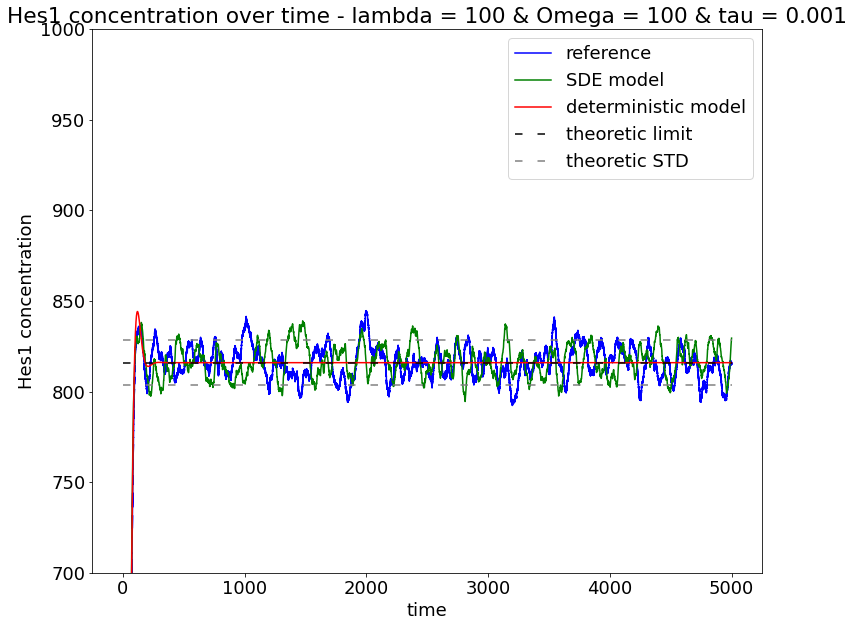

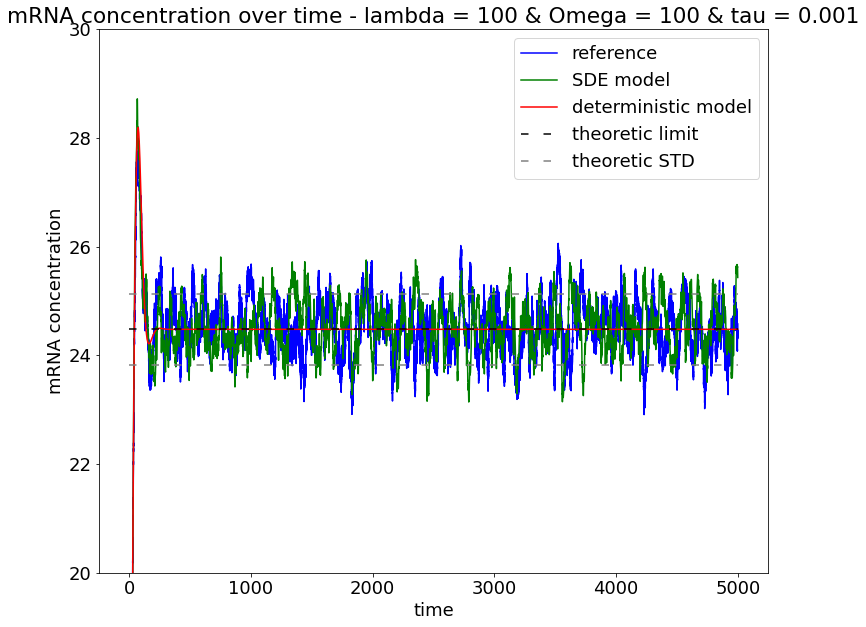

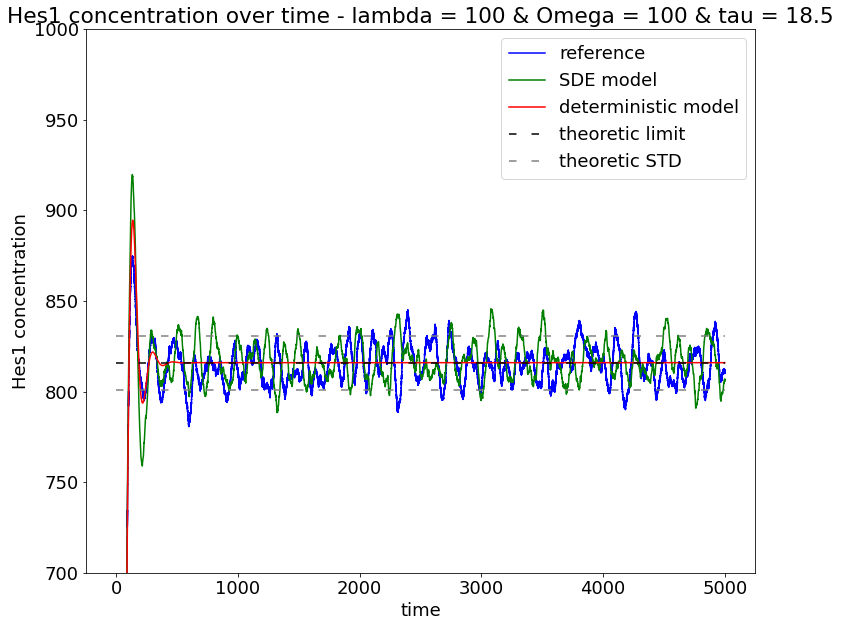

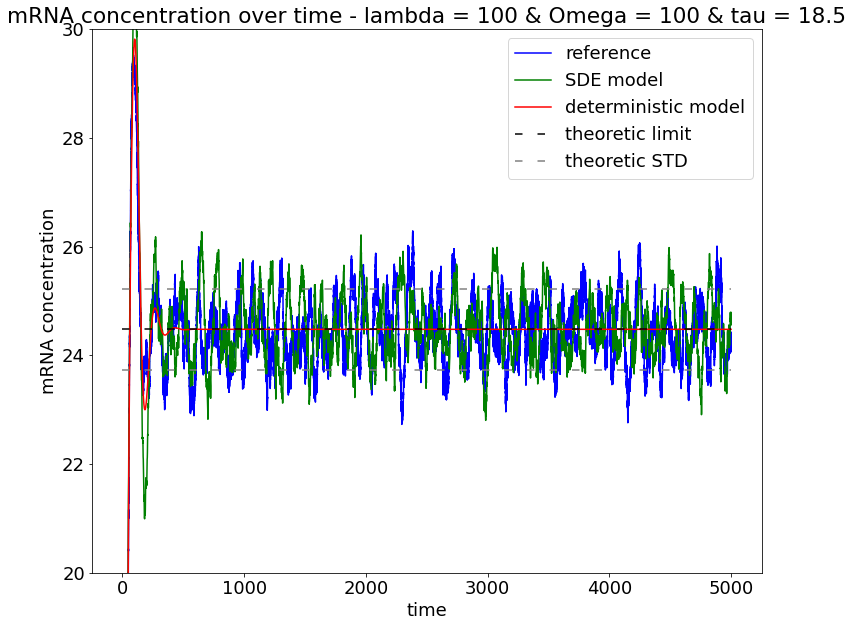

In [192]:
for k in range(2):

    time_trajm,mRNA_trajm,Hes1_trajm = master.one_trajectory(lambda_s=100,        
                                                      P_0=P_0,
                                                      h=h,
                                                      tau=val_tau[k],
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T/2,
                                                      Omega=100)

    time_trajl,mRNA_trajl,Hes1_trajl = langevin.one_trajectory(lambda_s=100,        
                                                      P_0=P_0,
                                                      h=h,
                                                      tau=val_tau[k],
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T/2,
                                                      delta_t=1,
                                                      Omega=100)

    t_deter,M_deter,P_deter = langevin.resolve_ODE(P_0=P_0, h=h,
                                                      tau=val_tau[k],
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T/2,
                                                      delta_t=1)

    M_star,P_star=utils.resolve_stationary_state(alpha_m,mu_m,alpha_p,mu_p,h,P_0)

    
    
    
    fig,ax=plt.subplots(figsize=(12,10))
    
    ax.set_title('Hes1 concentration over time - lambda = 100 & Omega = 100 & tau = ' + str(val_tau[k])) 
    ax.set_xlabel('time') 
    ax.set_ylabel('Hes1 concentration') 
    
    linem,=ax.plot(time_trajm,Hes1_trajm, color = 'blue')
    linel,=ax.plot(time_trajl,Hes1_trajl, color = 'green')
    lined,=ax.plot(t_deter,P_deter , color = 'red')
    line_mean,=ax.plot([0,T/2], [P_star,P_star], color = 'black', ls='--', dashes=(5, 10))
    line_std,=ax.plot([0,T/2], [P_star+std_th_P[4,2,k],P_star+std_th_P[4,2,k]], color = 'gray', ls='--', dashes=(5, 10))
    ax.plot([0,T/2], [P_star-std_th_P[4,2,k],P_star-std_th_P[4,2,k]], color = 'gray', ls='--', dashes=(5, 10))
    
    ax.set_ylim(700,1000)
    
    ax.legend([linem, linel, lined, line_mean, line_std], ['reference', 'SDE model', 'deterministic model', 'theoretic limit', 'theoretic STD'])
    plt.savefig(read_directory+'\\plots\\trajectories\\trajP - lambda100 and Omega100 and tau' + str(val_tau[k]) + '.pdf')
    
    plt.show()
    
    
    
    fig2,ax2=plt.subplots(figsize=(12,10))
    
    ax2.set_title('mRNA concentration over time - lambda = 100 & Omega = 100 & tau = ' + str(val_tau[k])) 
    ax2.set_xlabel('time') 
    ax2.set_ylabel('mRNA concentration') 
    
    linem,=ax2.plot(time_trajm,mRNA_trajm, color = 'blue')
    linel,=ax2.plot(time_trajl,mRNA_trajl, color = 'green')
    lined,=ax2.plot(t_deter,M_deter , color = 'red')
    line_mean,=ax2.plot([0,T/2], [M_star,M_star], color = 'black', ls='--', dashes=(5, 10))
    line_std,=ax2.plot([0,T/2], [M_star+std_th_M[4,2,k], M_star+std_th_M[4,2,k]], color = 'gray', ls='--', dashes=(5, 10))
    ax2.plot([0,T/2], [M_star-std_th_M[4,2,k],M_star-std_th_M[4,2,k]], color = 'gray', ls='--', dashes=(5, 10))

    ax2.set_ylim(20,30)

    ax2.legend([linem, linel, lined, line_mean, line_std], ['reference', 'SDE model', 'deterministic model', 'theoretic limit', 'theoretic STD'])
    plt.savefig(read_directory+'\\plots\\trajectories\\trajM - lambda100 and Omega100 and tau' + str(val_tau[k]) + '.pdf')
    
    plt.show()

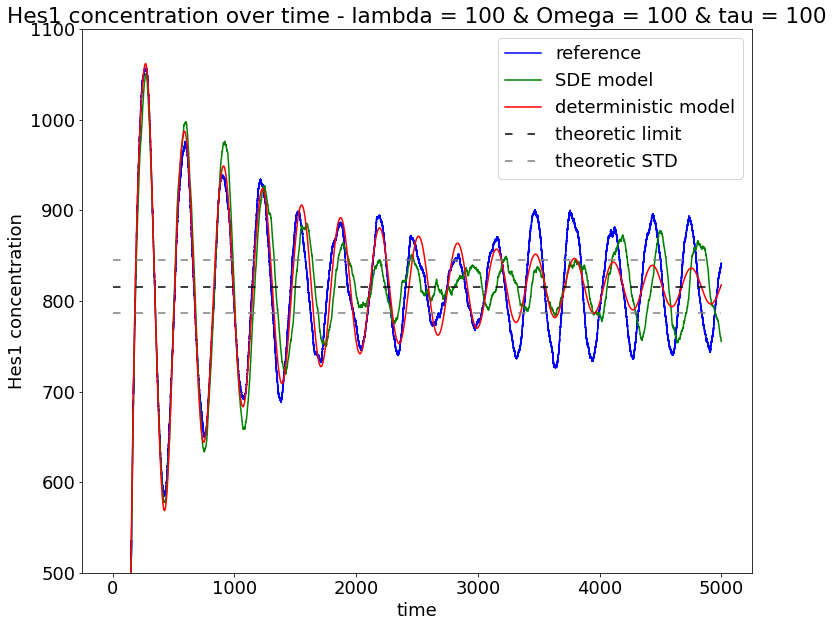

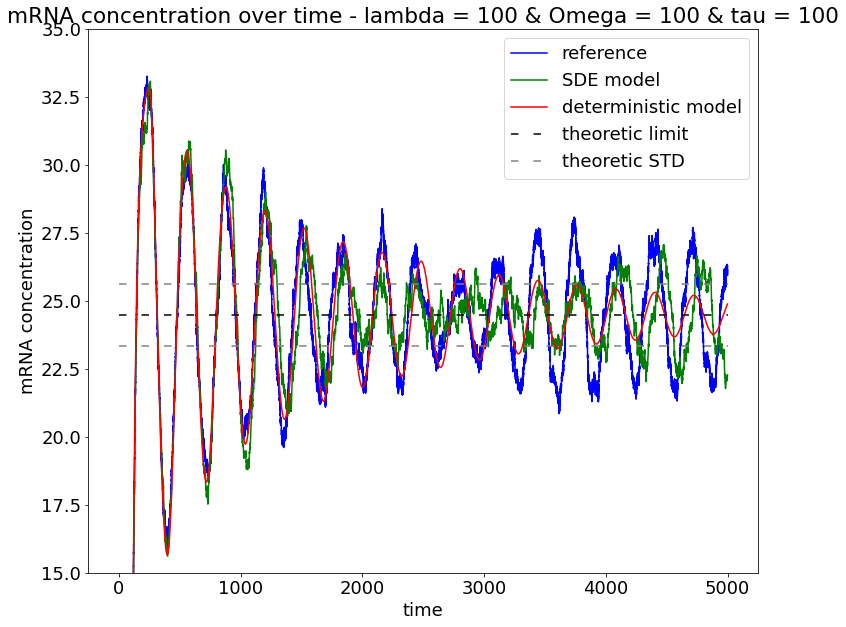

In [193]:
    k=2
    time_trajm,mRNA_trajm,Hes1_trajm = master.one_trajectory(lambda_s=100,        
                                                      P_0=P_0,
                                                      h=h,
                                                      tau=val_tau[k],
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T/2,
                                                      Omega=100)

    time_trajl,mRNA_trajl,Hes1_trajl = langevin.one_trajectory(lambda_s=100,        
                                                      P_0=P_0,
                                                      h=h,
                                                      tau=val_tau[k],
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T/2,
                                                      delta_t=1,
                                                      Omega=100)

    t_deter,M_deter,P_deter = langevin.resolve_ODE(P_0=P_0, h=h,
                                                      tau=val_tau[k],
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T/2,
                                                      delta_t=1)

    M_star,P_star=utils.resolve_stationary_state(alpha_m,mu_m,alpha_p,mu_p,h,P_0)

    
    
    
    fig,ax=plt.subplots(figsize=(12,10))
    
    ax.set_title('Hes1 concentration over time - lambda = 100 & Omega = 100 & tau = ' + str(val_tau[k])) 
    ax.set_xlabel('time') 
    ax.set_ylabel('Hes1 concentration') 
    
    linem,=ax.plot(time_trajm,Hes1_trajm, color = 'blue')
    linel,=ax.plot(time_trajl,Hes1_trajl, color = 'green')
    lined,=ax.plot(t_deter,P_deter , color = 'red')
    line_mean,=ax.plot([0,T/2], [P_star,P_star], color = 'black', ls='--', dashes=(5, 10))
    line_std,=ax.plot([0,T/2], [P_star+std_th_P[4,2,k],P_star+std_th_P[4,2,k]], color = 'gray', ls='--', dashes=(5, 10))
    ax.plot([0,T/2], [P_star-std_th_P[4,2,k],P_star-std_th_P[4,2,k]], color = 'gray', ls='--', dashes=(5, 10))
    
    ax.set_ylim(500,1100)
    
    ax.legend([linem, linel, lined, line_mean, line_std], ['reference', 'SDE model', 'deterministic model', 'theoretic limit', 'theoretic STD'])
    plt.savefig(read_directory+'\\plots\\trajectories\\trajP - lambda100 and Omega100 and tau' + str(val_tau[k]) + '.pdf')
    
    plt.show()
    
    
    
    fig2,ax2=plt.subplots(figsize=(12,10))
    
    ax2.set_title('mRNA concentration over time - lambda = 100 & Omega = 100 & tau = ' + str(val_tau[k])) 
    ax2.set_xlabel('time') 
    ax2.set_ylabel('mRNA concentration') 
    
    linem,=ax2.plot(time_trajm,mRNA_trajm, color = 'blue')
    linel,=ax2.plot(time_trajl,mRNA_trajl, color = 'green')
    lined,=ax2.plot(t_deter,M_deter , color = 'red')
    line_mean,=ax2.plot([0,T/2], [M_star,M_star], color = 'black', ls='--', dashes=(5, 10))
    line_std,=ax2.plot([0,T/2], [M_star+std_th_M[4,2,k], M_star+std_th_M[4,2,k]], color = 'gray', ls='--', dashes=(5, 10))
    ax2.plot([0,T/2], [M_star-std_th_M[4,2,k],M_star-std_th_M[4,2,k]], color = 'gray', ls='--', dashes=(5, 10))

    ax2.set_ylim(15,35)

    ax2.legend([linem, linel, lined, line_mean, line_std], ['reference', 'SDE model', 'deterministic model', 'theoretic limit', 'theoretic STD'])
    plt.savefig(read_directory+'\\plots\\trajectories\\trajM - lambda100 and Omega100 and tau' + str(val_tau[k]) + '.pdf')
    
    plt.show()

### Plot mean

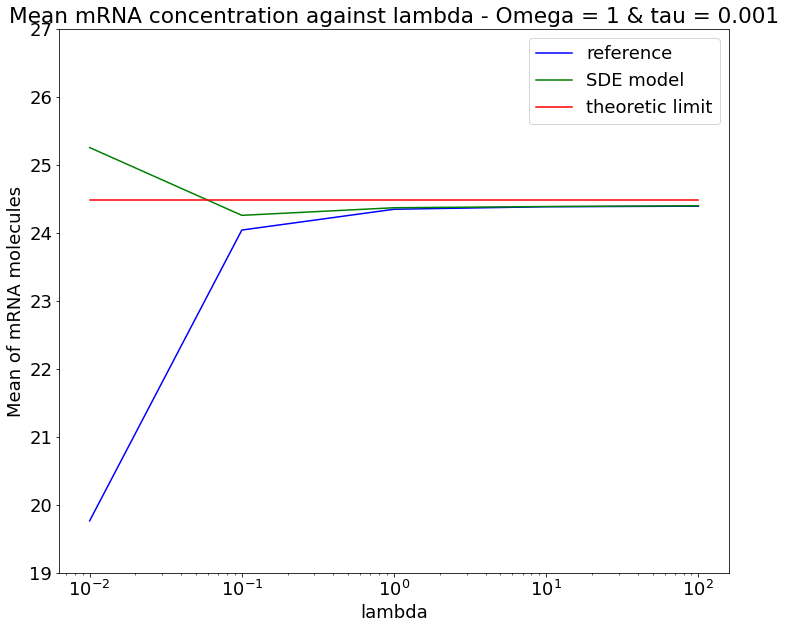

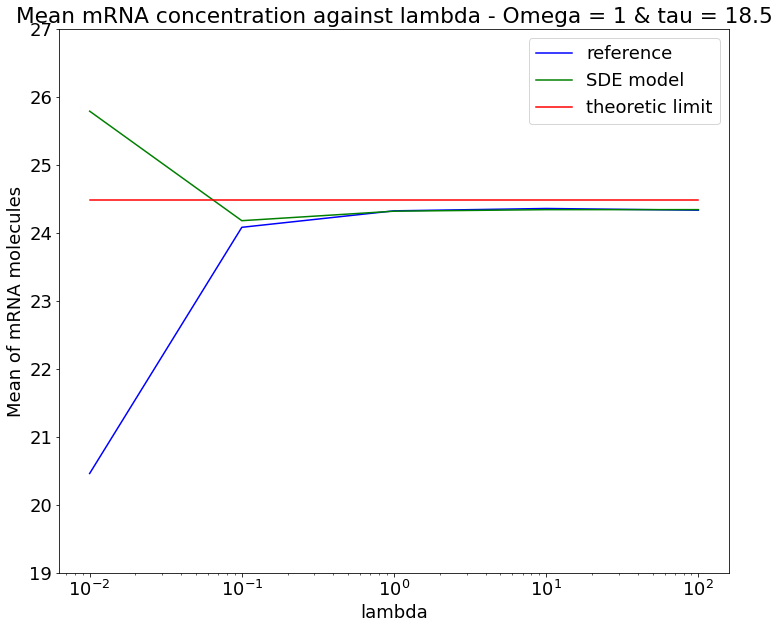

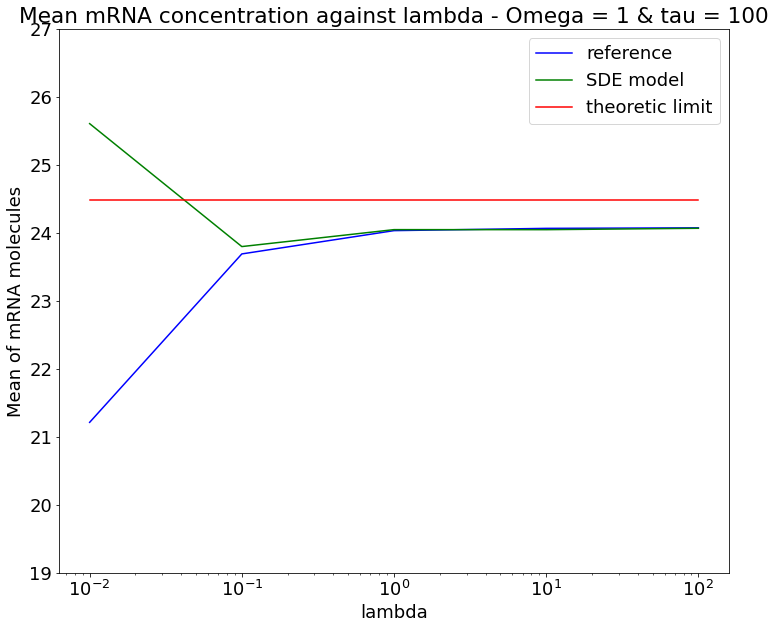

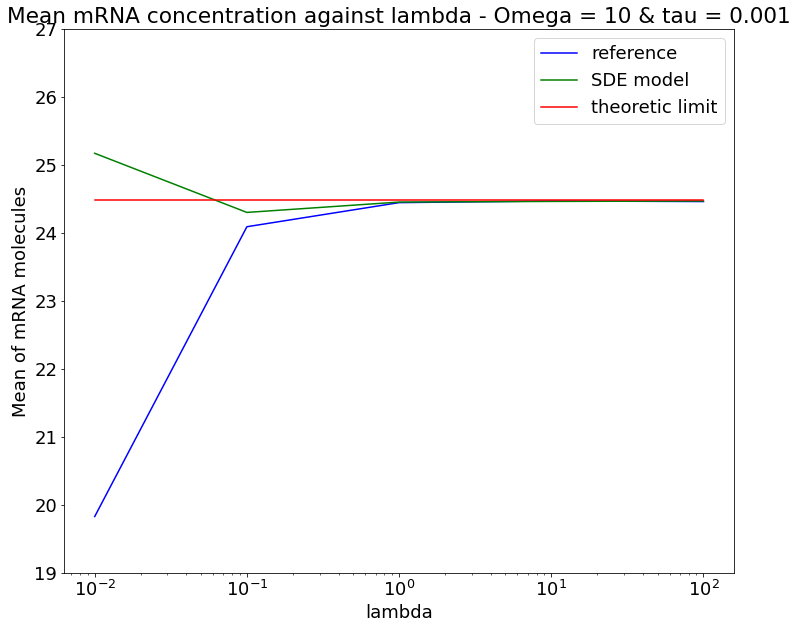

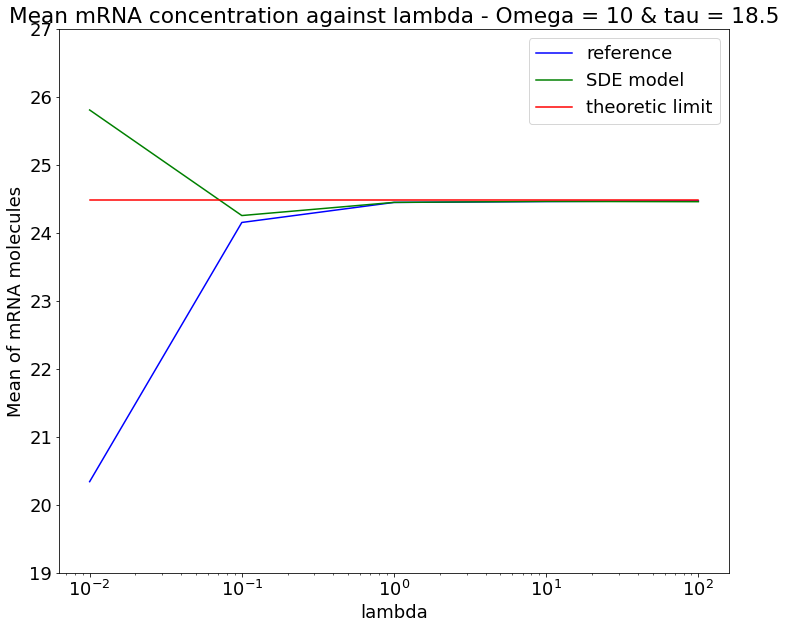

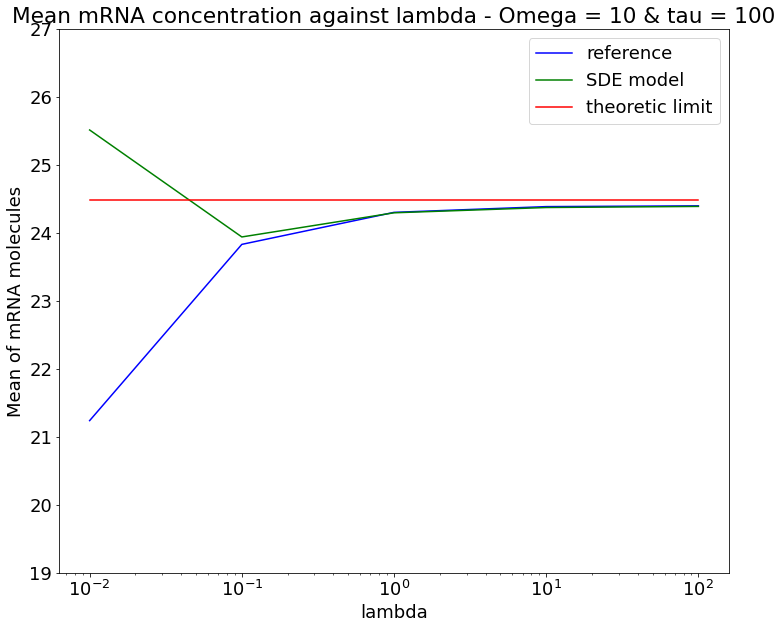

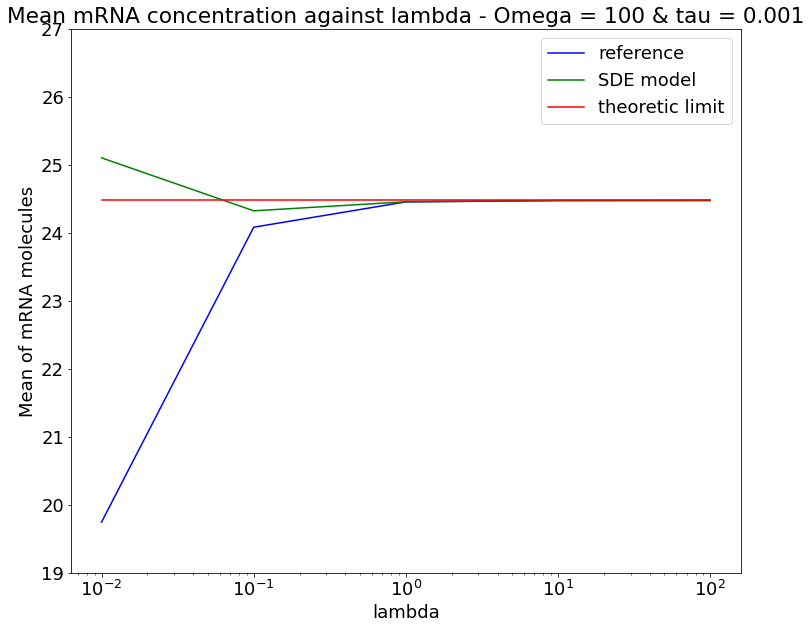

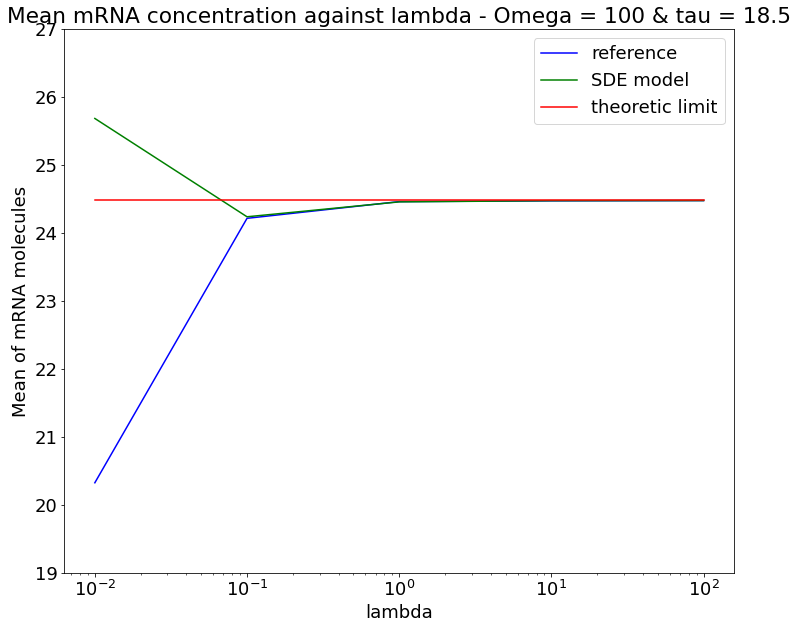

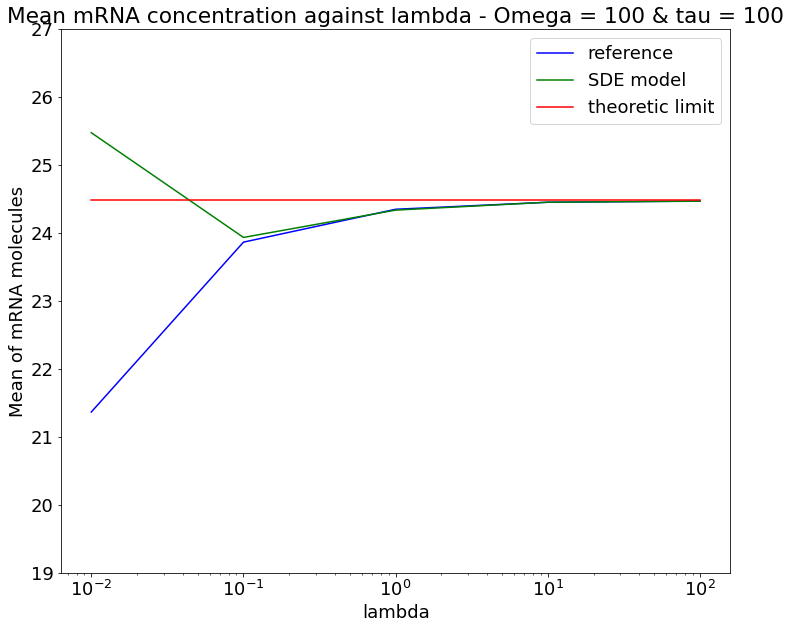

In [24]:
for j in range(n_Omega):
    for k in range(n_tau):
    
        #print('Omega=',val_Omega[j])
        #print('tau=',val_tau[k])
        fig, ax1 = plt.subplots(figsize=(12,10)) 
        
        ax1.set_title('Mean mRNA concentration against lambda - Omega = ' +  str(val_Omega[j]) + ' & tau = ' + str(val_tau[k])) 
        ax1.set_xlabel('lambda') 
        ax1.set_ylabel('Mean of mRNA molecules') 
        
        linem,=ax1.plot(val_lambda, mean_Mm[:,j,k], color = 'blue') 
        linel,=ax1.plot(val_lambda, mean_Ml[:,j,k], color = 'green')
        linet,=ax1.plot(val_lambda, n_lambda*[M_stat_mean[k]], color='red')
        
        ax1.tick_params(axis ='y') 
        ax1.set_xscale('log')
        ax1.legend([linem, linel, linet], ['reference', 'SDE model', 'theoretic limit'])

        #ax1.set_xlim(0.001,100)
        ax1.set_ylim(19,27)
        
        plt.savefig(read_directory+'\\plots\\mean_M\\plot_mean_M - Omega' +  str(val_Omega[j]) + ' and tau' + str(val_tau[k]) + '.pdf')  
        
        plt.show()

Omega= 1
tau= 0.001


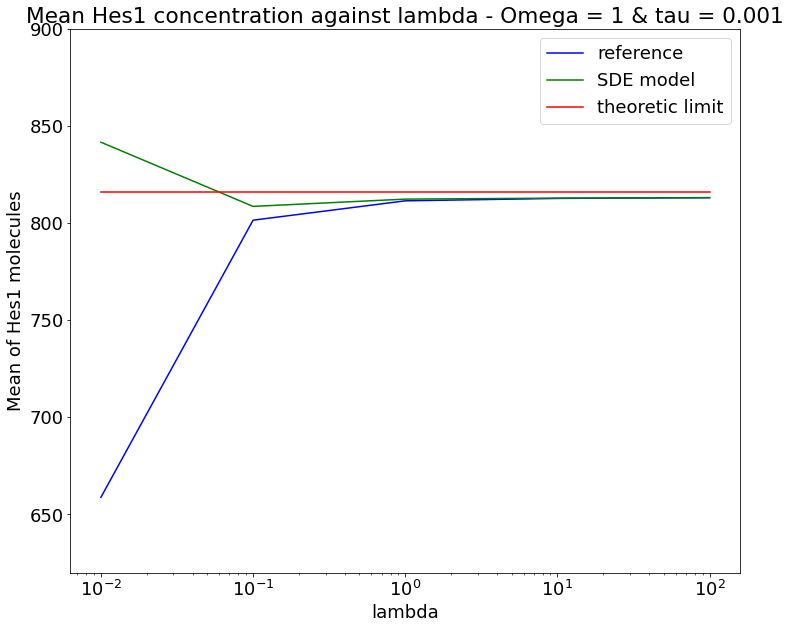

Omega= 1
tau= 18.5


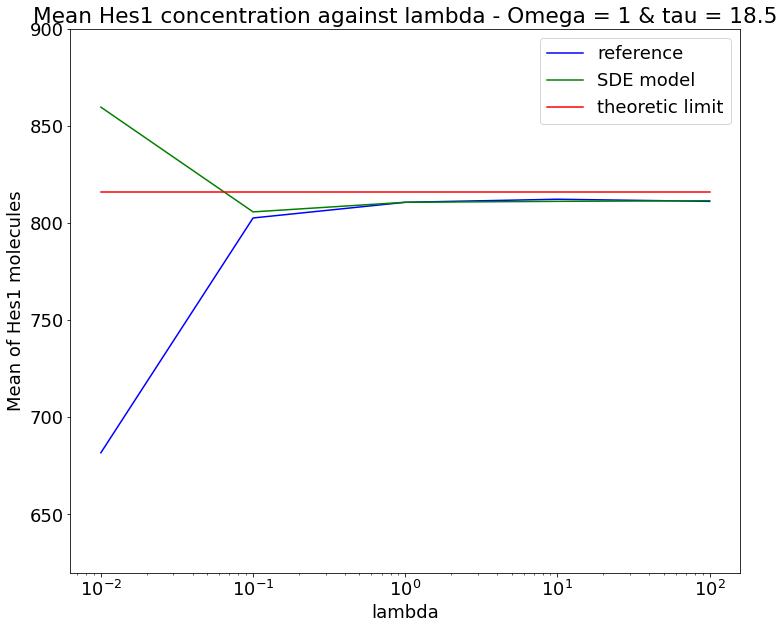

Omega= 1
tau= 100


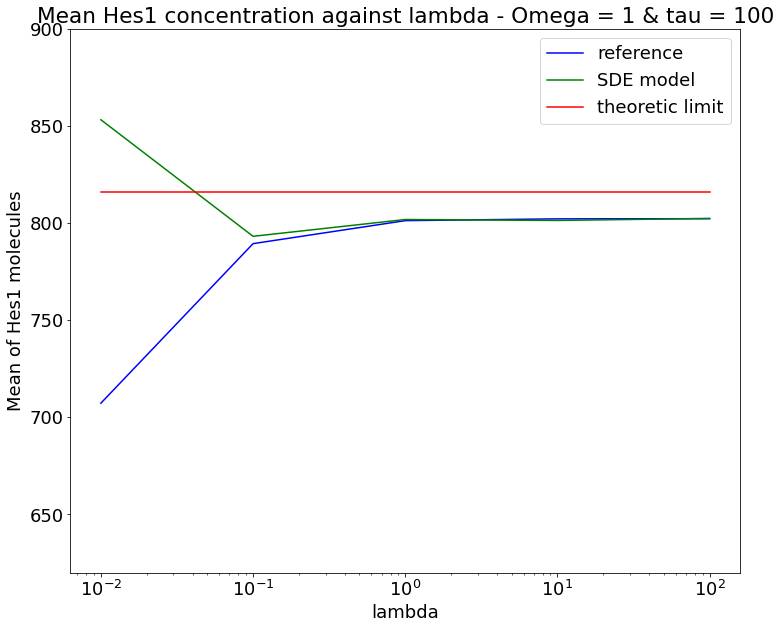

Omega= 10
tau= 0.001


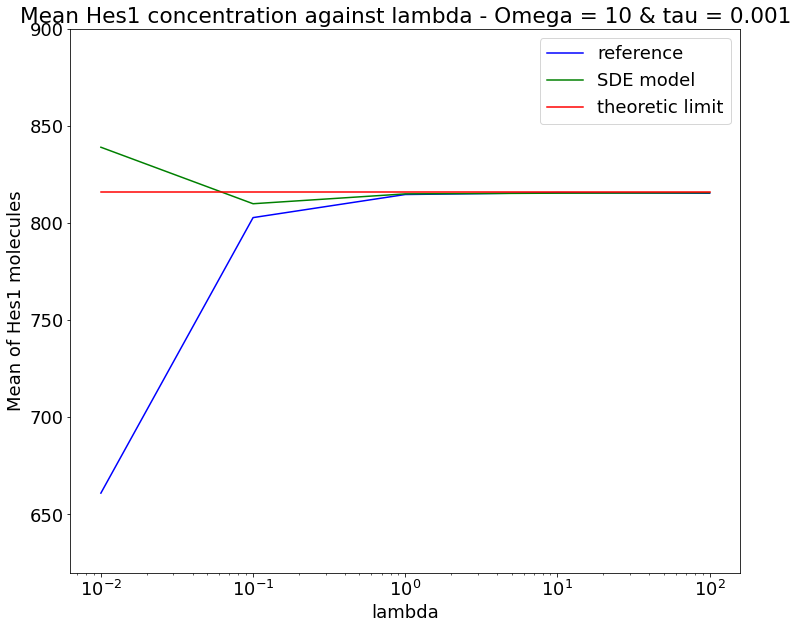

Omega= 10
tau= 18.5


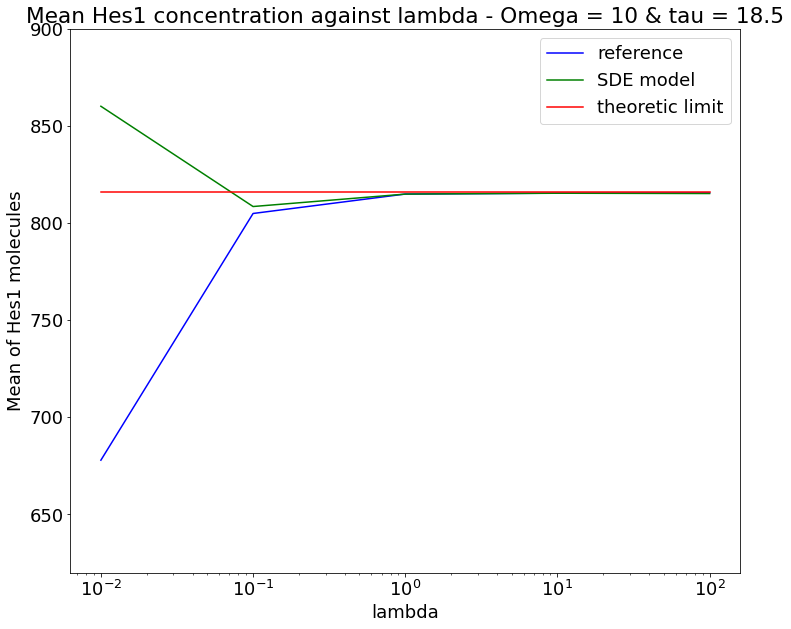

Omega= 10
tau= 100


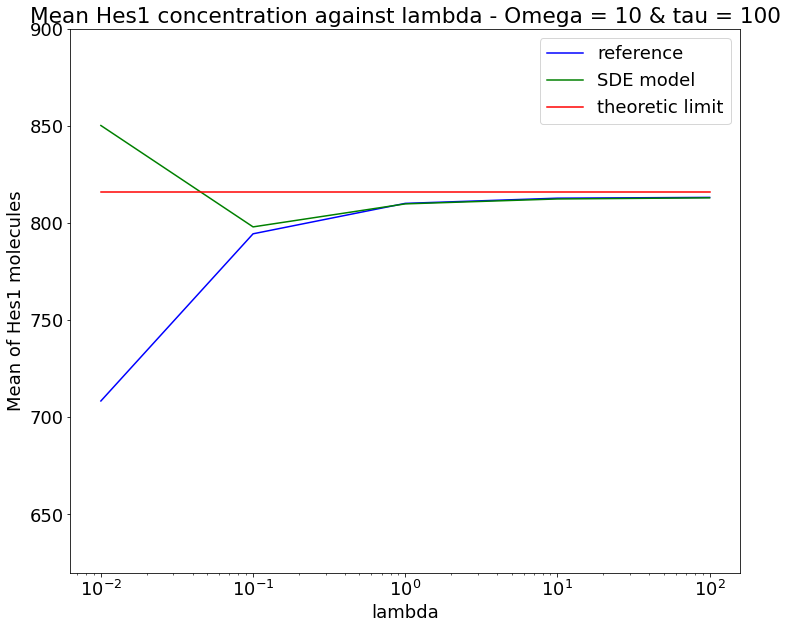

Omega= 100
tau= 0.001


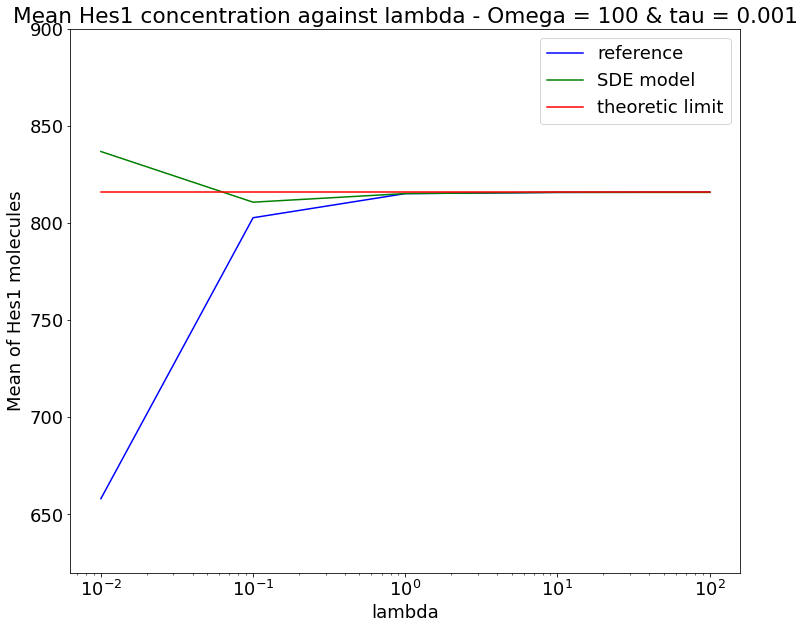

Omega= 100
tau= 18.5


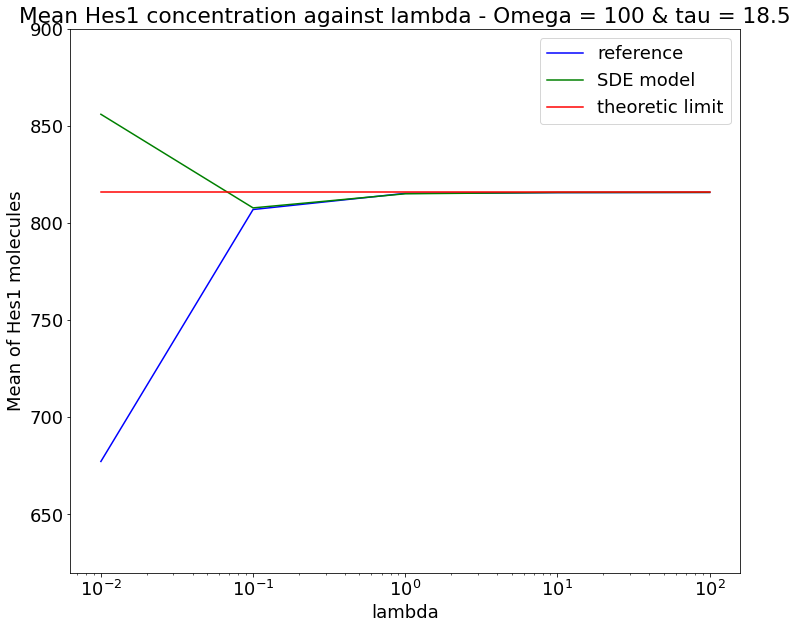

Omega= 100
tau= 100


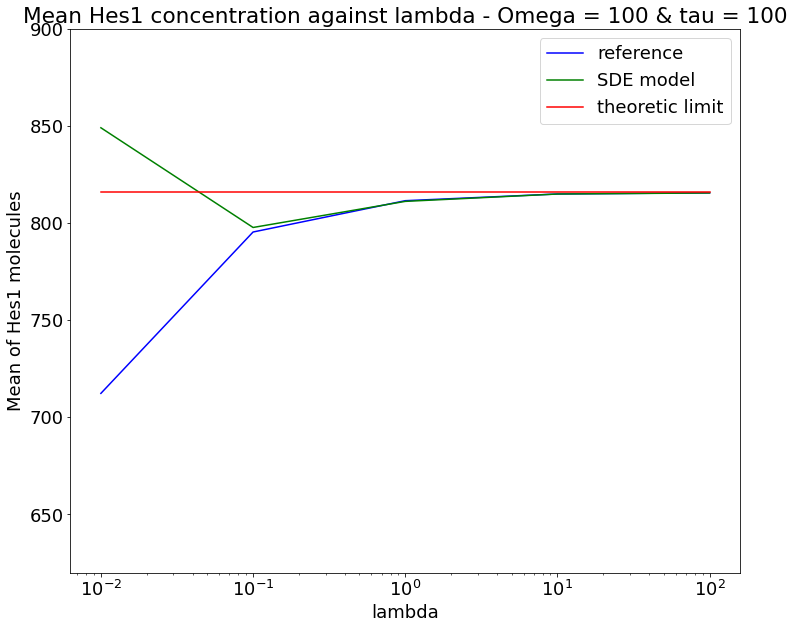

In [25]:
for j in range(n_Omega):
    for k in range(n_tau):
    
        print('Omega=',val_Omega[j])
        print('tau=',val_tau[k])
        fig, ax1 = plt.subplots(figsize=(12,10)) 

        ax1.set_title('Mean Hes1 concentration against lambda - Omega = ' +  str(val_Omega[j]) + ' & tau = ' + str(val_tau[k])) 
        ax1.set_xlabel('lambda') 
        ax1.set_ylabel('Mean of Hes1 molecules') 
        
        linem,=ax1.plot(val_lambda, mean_Pm[:,j,k], color = 'blue') 
        linel,=ax1.plot(val_lambda, mean_Pl[:,j,k], color = 'green')
        linet,=ax1.plot(val_lambda, n_lambda*[P_stat_mean[k]], color='red')

        ax1.tick_params(axis ='y') 
        ax1.set_xscale('log')
        ax1.set_ylim(620,900)
        ax1.legend([linem, linel, linet], ['reference', 'SDE model', 'theoretic limit'])
        
        plt.savefig(read_directory + '\\plots\\mean_P\\plot_mean_P - Omega' +  str(val_Omega[j]) + ' and tau' + str(val_tau[k]) + '.pdf')  

        plt.show()

### Plot std

#### Plot std against $\lambda$

Omega= 1
tau= 0.001


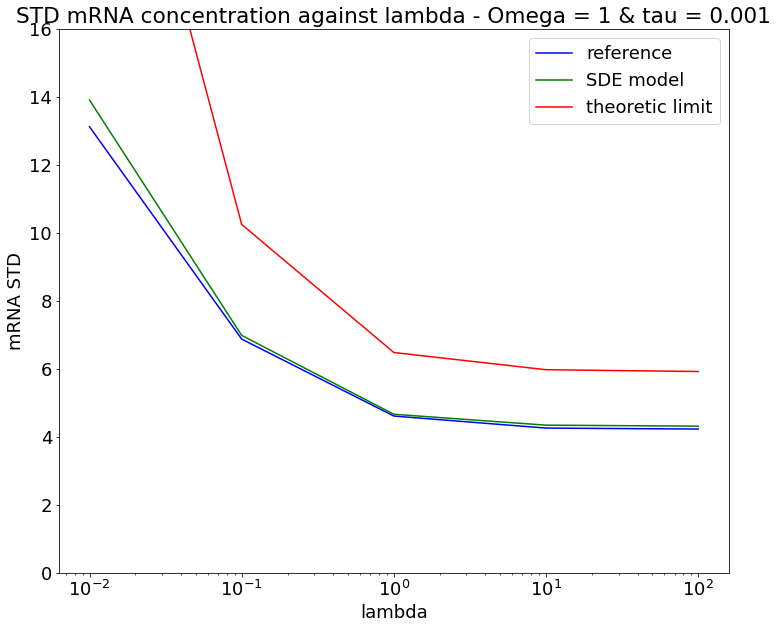

Omega= 1
tau= 18.5


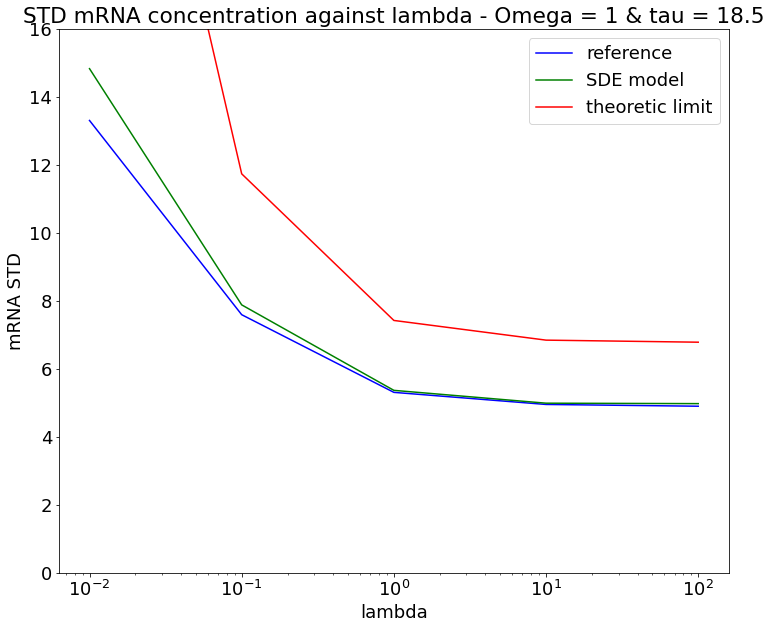

Omega= 1
tau= 100


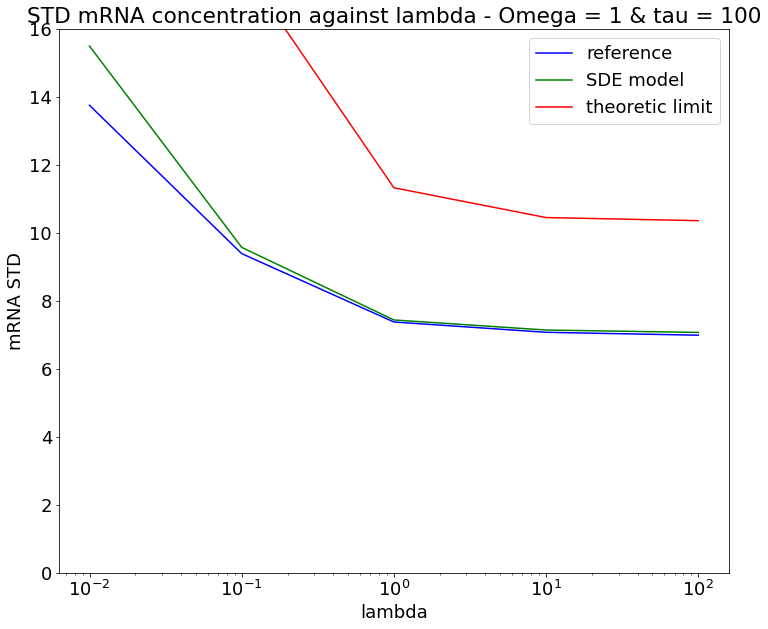

Omega= 10
tau= 0.001


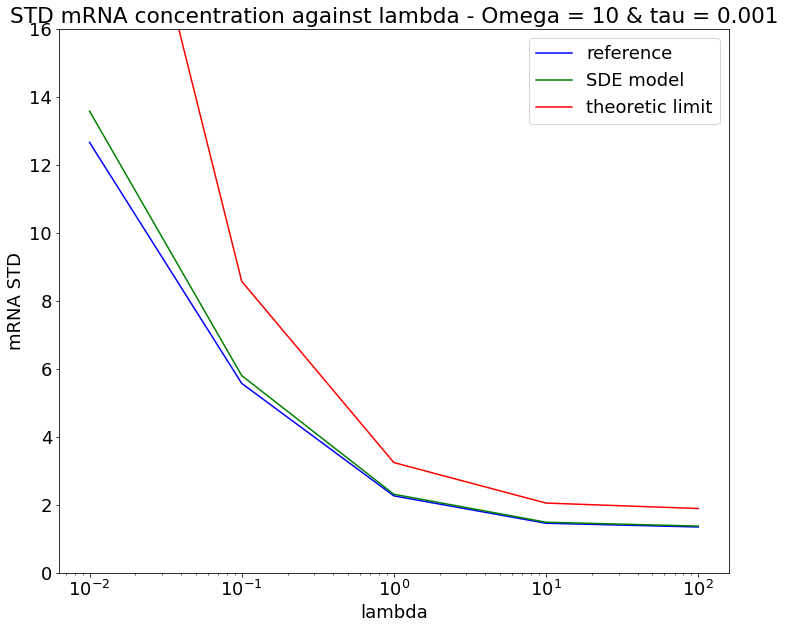

Omega= 10
tau= 18.5


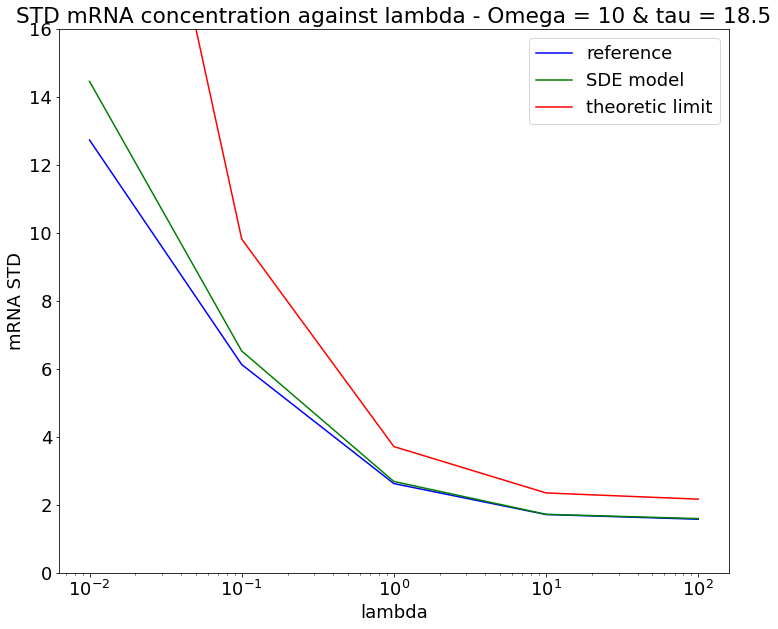

Omega= 10
tau= 100


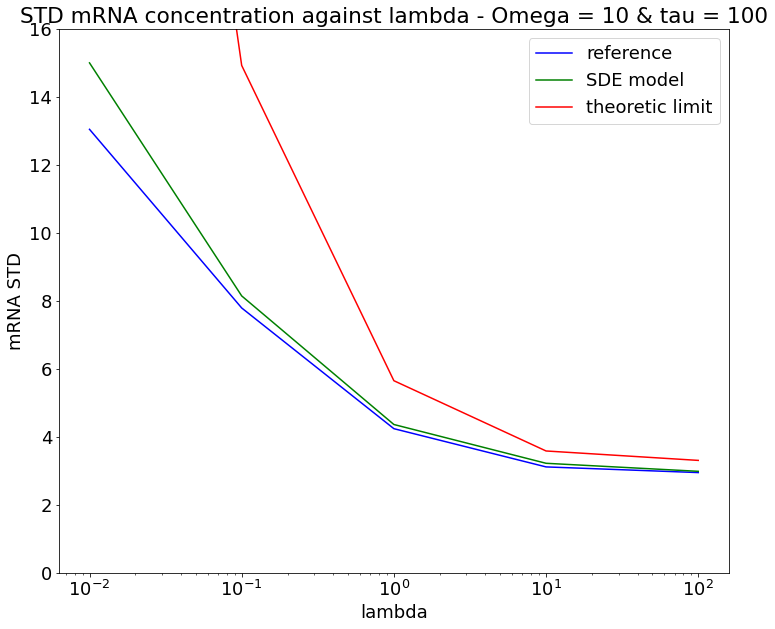

Omega= 100
tau= 0.001


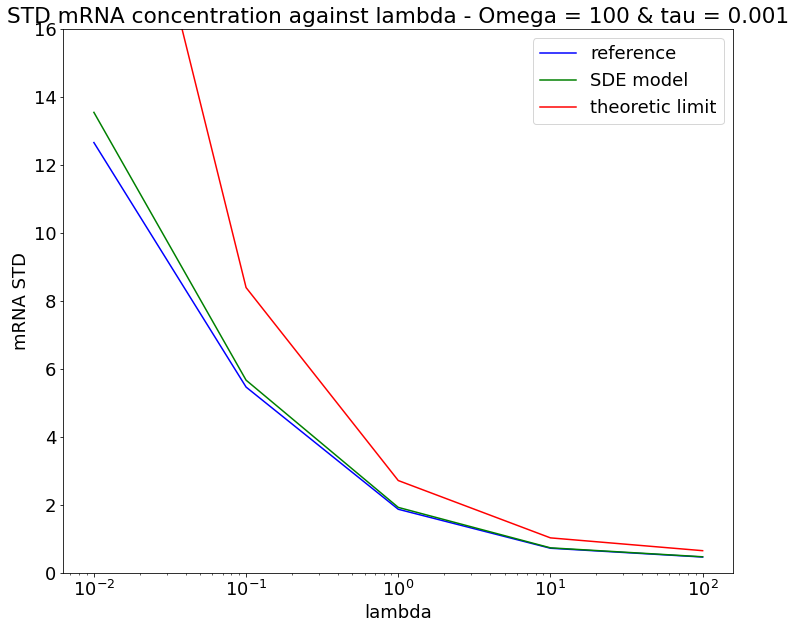

Omega= 100
tau= 18.5


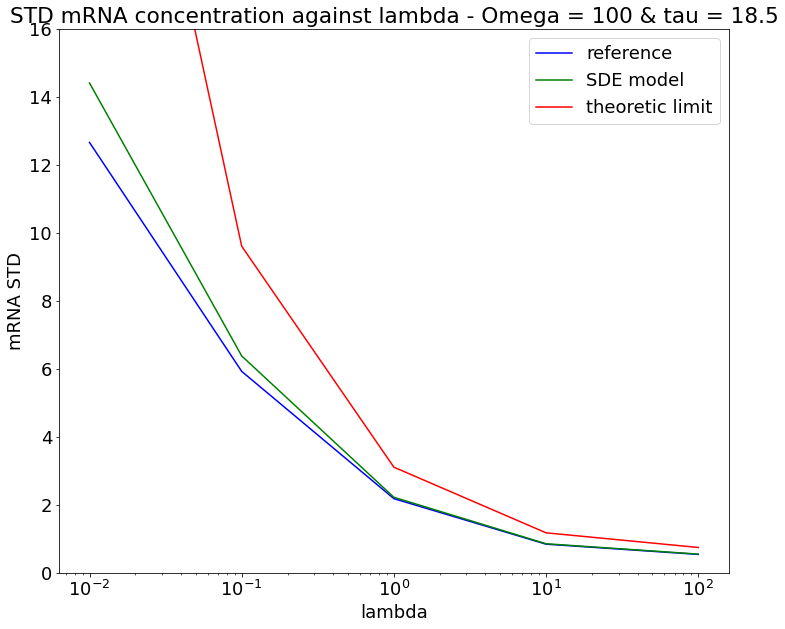

Omega= 100
tau= 100


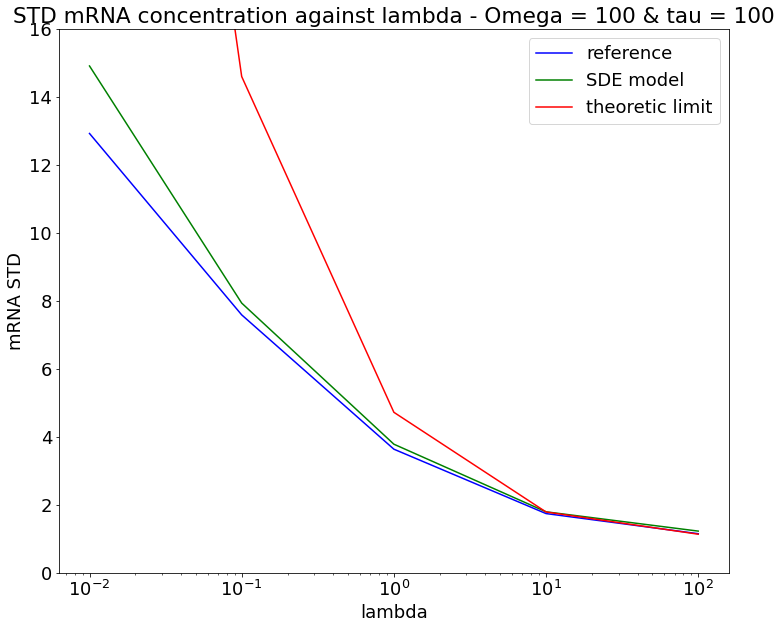

In [37]:
for j in range(n_Omega):
    for k in range(n_tau):
    
        print('Omega=',val_Omega[j])
        print('tau=',val_tau[k])
        fig, ax1 = plt.subplots(figsize=(12,10)) 

        ax1.set_title('STD mRNA concentration against lambda - Omega = ' +  str(val_Omega[j]) + ' & tau = ' + str(val_tau[k])) 
        ax1.set_xlabel('lambda') 
        ax1.set_ylabel('mRNA STD')
        
        linem,=ax1.plot(val_lambda, std_Mm[:,j,k], color = 'blue') 
        linel,=ax1.plot(val_lambda, std_Ml[:,j,k], color = 'green')
        linet,=ax1.plot(val_lambda, std_th_M[:,j,k], color = 'red')
        
        ax1.tick_params(axis ='y') 
        ax1.set_xscale('log')
        ax1.set_ylim(0,16)
        ax1.legend([linem, linel, linet], ['reference', 'SDE model', 'theoretic limit'])

        plt.savefig(read_directory +'\\plots\\std_M\\plot_std_M - Omega' +  str(val_Omega[j]) + ' and tau' + str(val_tau[k]) + '.pdf')  

        plt.show()

Omega= 1
tau= 0.001


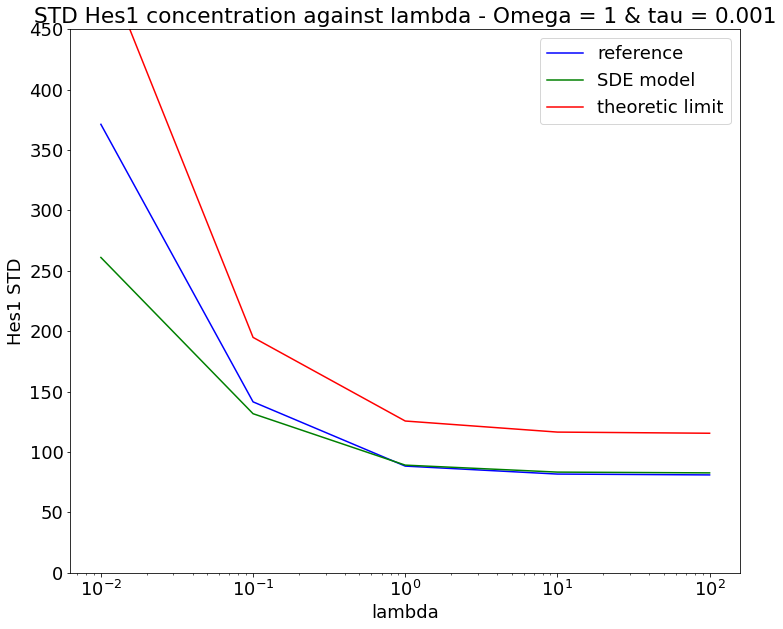

Omega= 1
tau= 18.5


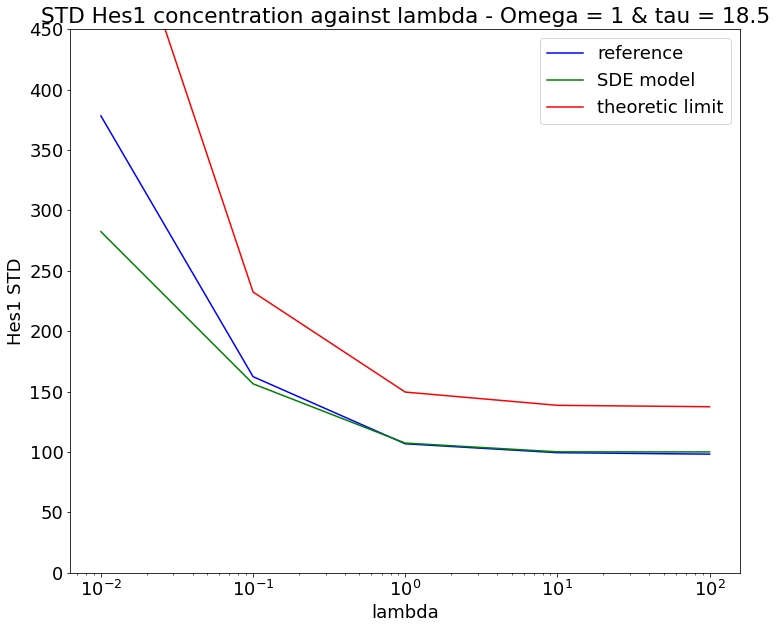

Omega= 1
tau= 100


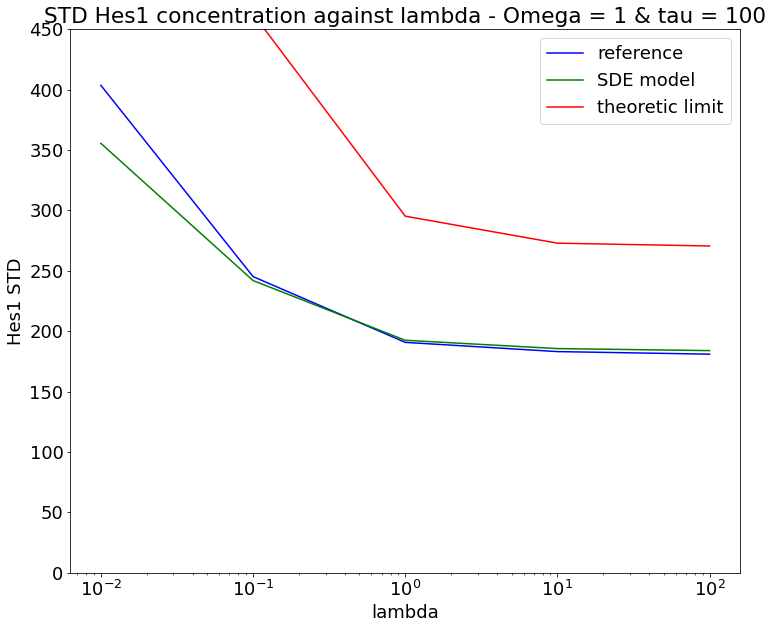

Omega= 10
tau= 0.001


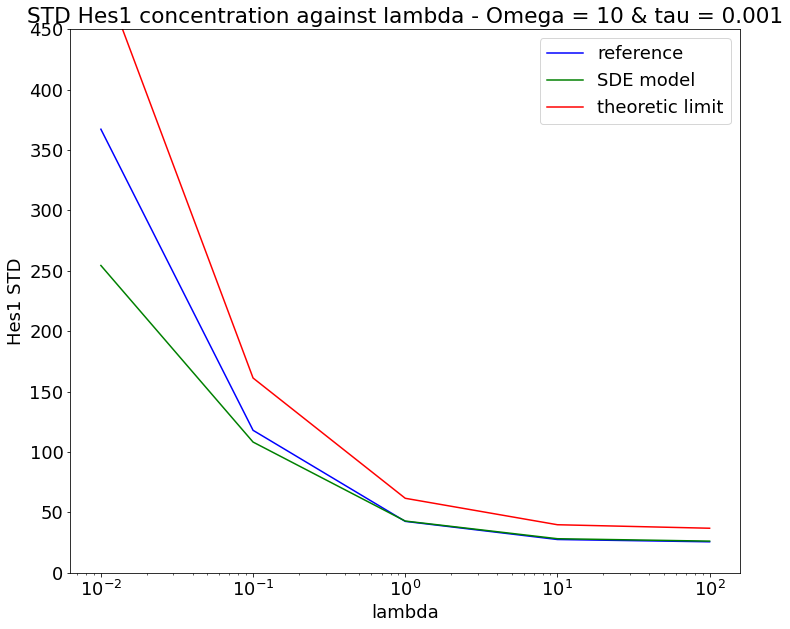

Omega= 10
tau= 18.5


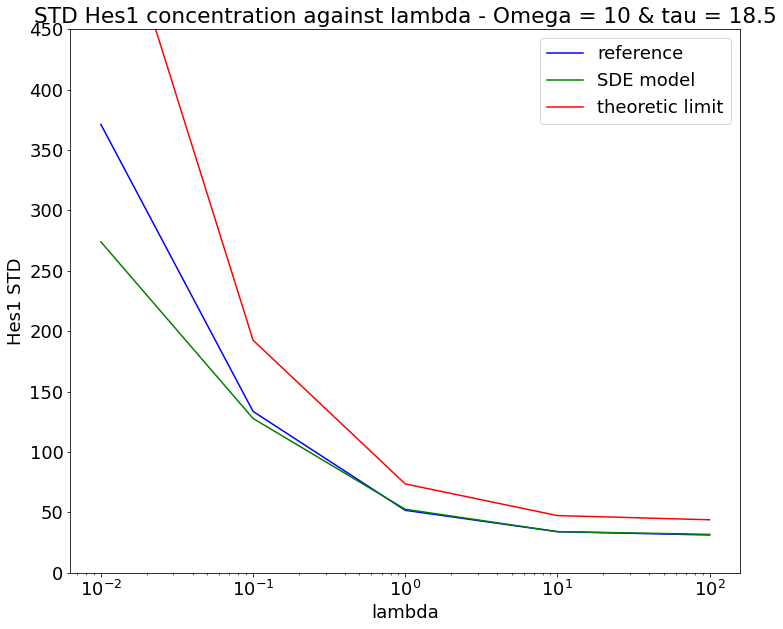

Omega= 10
tau= 100


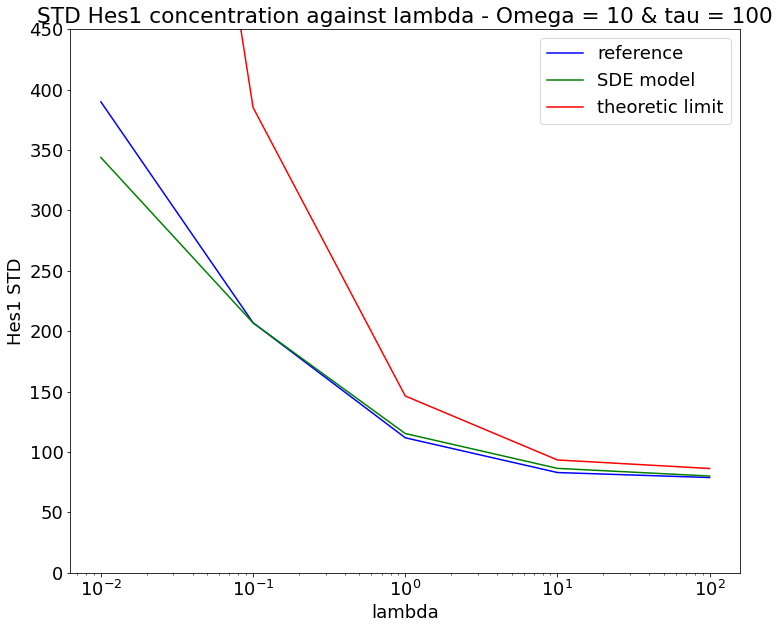

Omega= 100
tau= 0.001


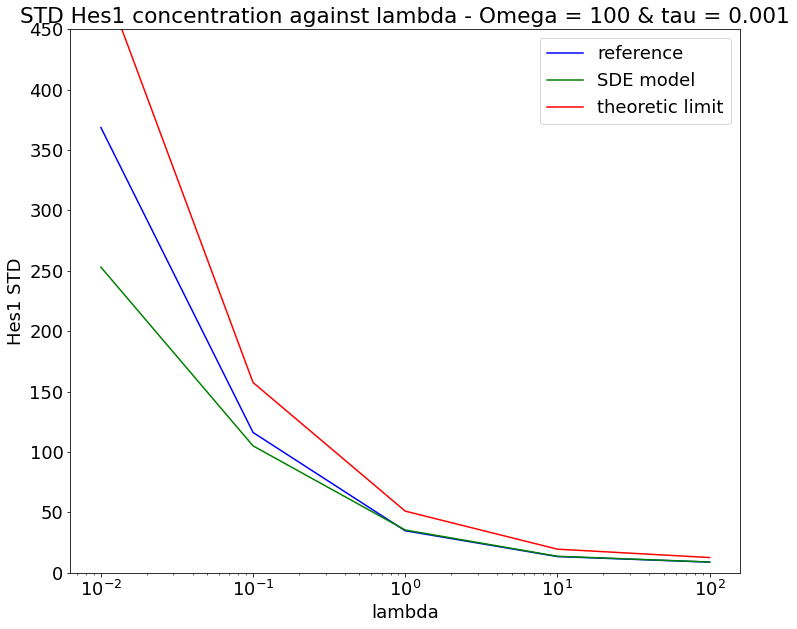

Omega= 100
tau= 18.5


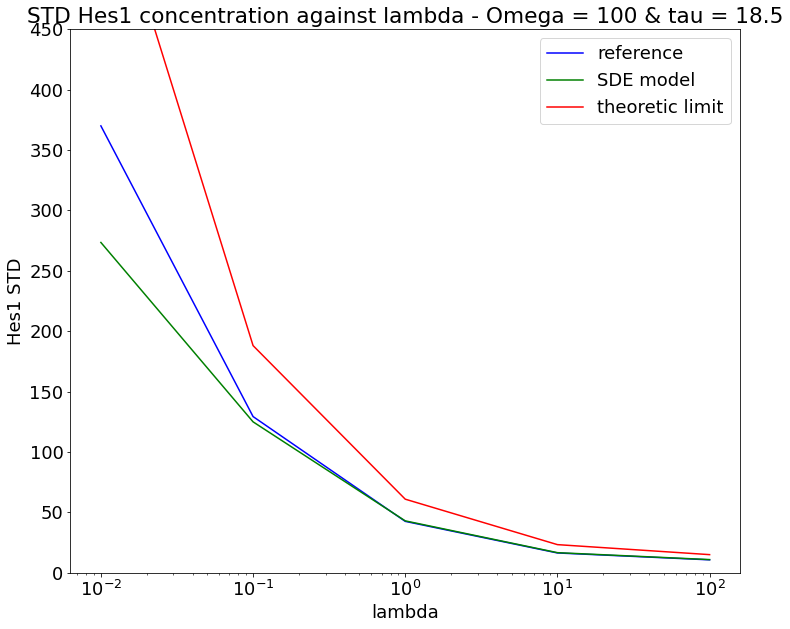

Omega= 100
tau= 100


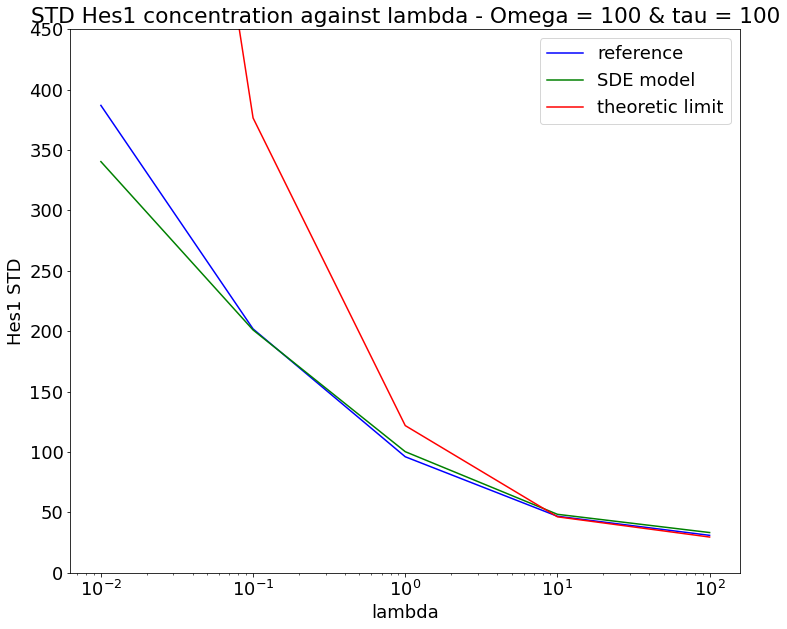

In [38]:
for j in range(n_Omega):
    for k in range(n_tau):
    
        print('Omega=',val_Omega[j])
        print('tau=',val_tau[k])
        fig, ax1 = plt.subplots(figsize=(12,10)) 

        ax1.set_title('STD Hes1 concentration against lambda - Omega = ' +  str(val_Omega[j]) + ' & tau = ' + str(val_tau[k])) 
        ax1.set_xlabel('lambda') 
        ax1.set_ylabel('Hes1 STD') 
        
        linem,=ax1.plot(val_lambda, std_Pm[:,j,k], color = 'blue') 
        linel,=ax1.plot(val_lambda, std_Pl[:,j,k], color = 'green')
        linet,=ax1.plot(val_lambda, std_th_P[:,j,k], color = 'red')
        
        ax1.tick_params(axis ='y') 
        ax1.set_xscale('log')
        ax1.set_ylim(0,450)
        ax1.legend([linem, linel, linet], ['reference', 'SDE model', 'theoretic limit'])
        
        plt.savefig(read_directory + '\\plots\\std_P\\plot_std_P - Omega' +  str(val_Omega[j]) + ' and tau' + str(val_tau[k]) + '.pdf')  

        plt.show()

#### Plot level curves of std against $\lambda$ and $\Omega$

In [ ]:
levels=np.array([k/20 for k in range(4)]+[k/4 for k in range(1,8)])

for k in range(n_tau):
    
        print('tau=',val_tau[k])
        
        fig, ax1 = plt.subplots() 
        ax1.set_title('Error level curves: master equation VS Langevin equation - tau = ' + str(val_tau[k])) 
        ax1.set_xlabel('Omega') 
        ax1.set_ylabel('lambda') 
        contours1=ax1.contour(val_Omega, val_lambda, abs(std_Mm[:,:,k] - std_Ml[:,:,k]), cmap = 'copper', levels=levels)
        ax1.tick_params(axis ='y') 
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.clabel(contours1,inline=1, fontsize=10)
        plt.savefig(new_directory +'\\plots\\std_M\\plot_level_curve_std_Mm_vs_Ml - tau' + str(val_tau[k]) + '.pdf')
        plt.show()

In [ ]:
levels=np.array([k for k in range(0,4,2)]+[10*k for k in range(1,10)])

for k in range(n_tau):
    
        print('tau=',val_tau[k])
        
        fig, ax1 = plt.subplots() 
        ax1.set_title('Error level curves: master equation VS Langevin equation - tau = ' + str(val_tau[k])) 
        ax1.set_xlabel('Omega') 
        ax1.set_ylabel('lambda') 
        contours1=ax1.contour(val_Omega, val_lambda, abs(std_Pm[:,:,k] - std_Pl[:,:,k]), cmap = 'copper', levels=levels)
        ax1.tick_params(axis ='y') 
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.clabel(contours1,inline=1, fontsize=10)
        plt.savefig('plot_level_curve_std_Pm_vs_Pl - tau' + str(val_tau[k]) + '.pdf')
        plt.show()
        

#### Plot power spectra

lambda= 0.01
Omega= 1
tau= 0.001


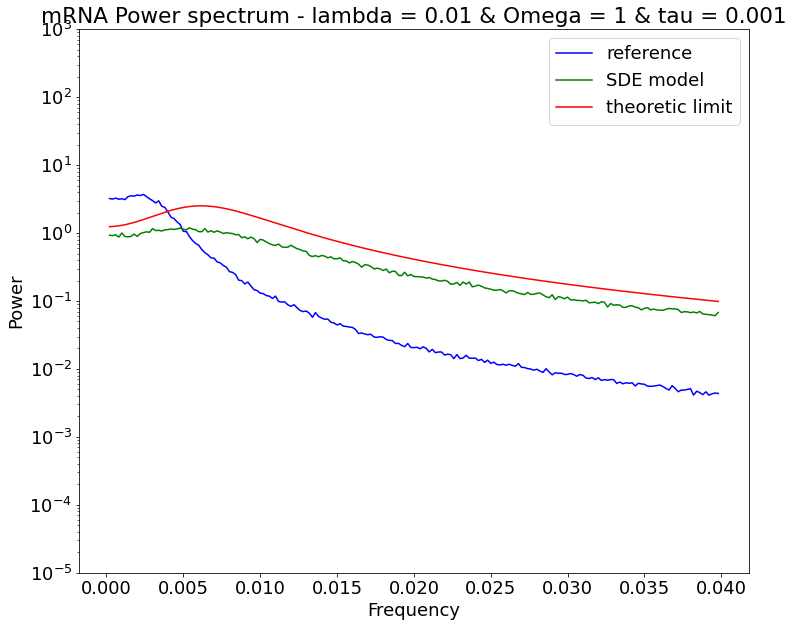

lambda= 0.01
Omega= 1
tau= 18.5


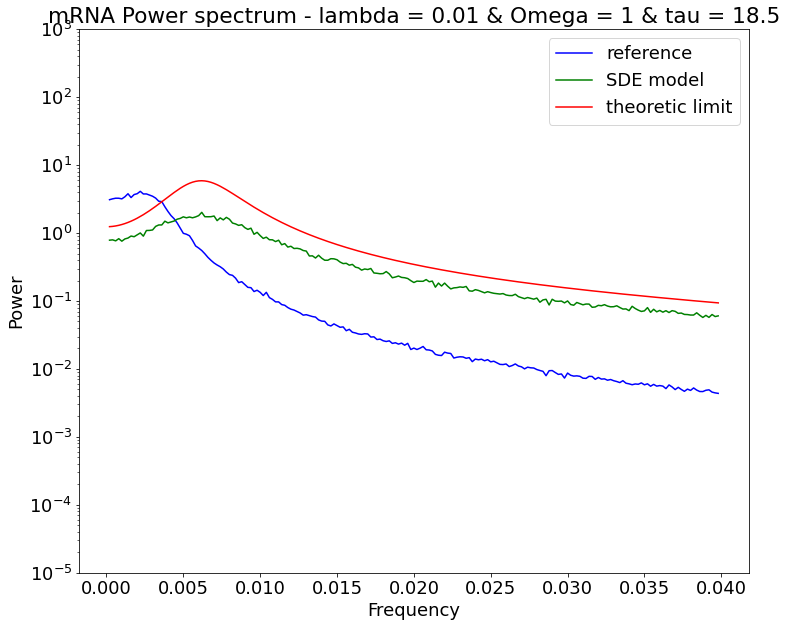

lambda= 0.01
Omega= 1
tau= 100


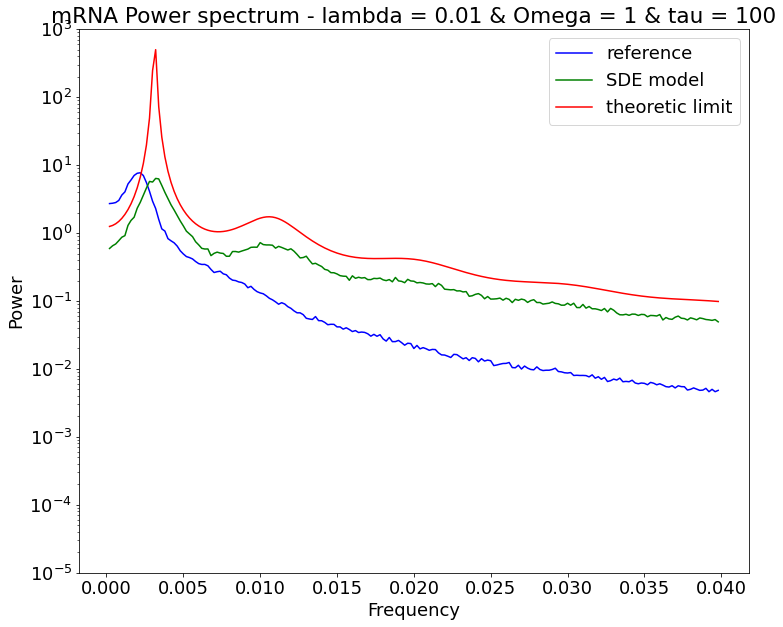

lambda= 0.01
Omega= 10
tau= 0.001


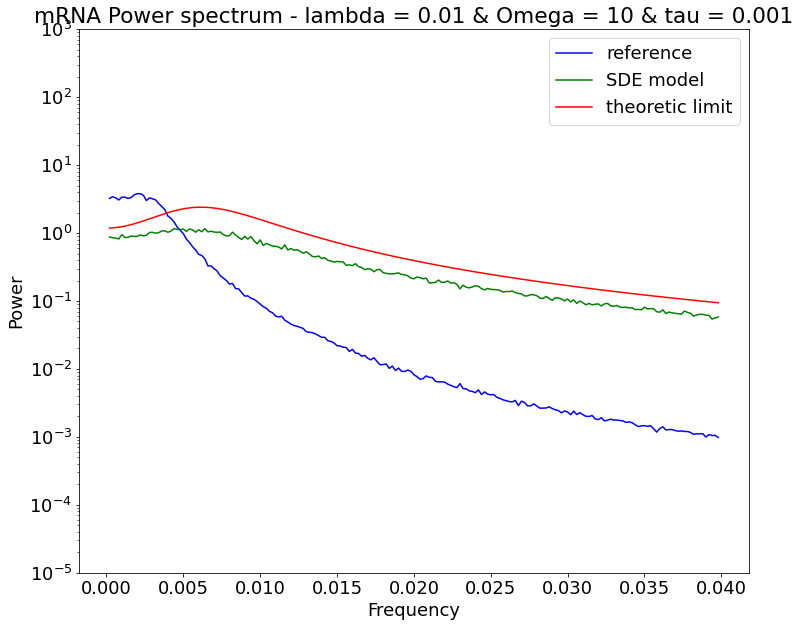

lambda= 0.01
Omega= 10
tau= 18.5


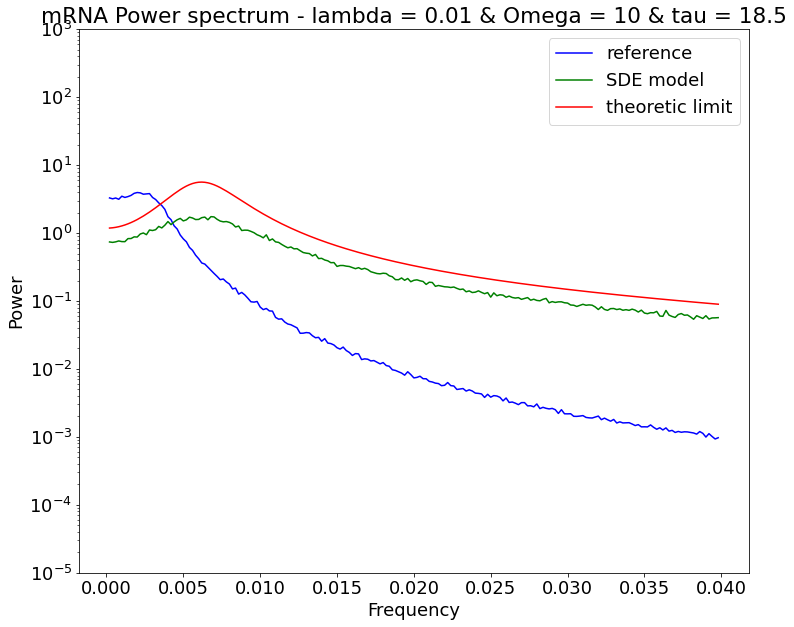

lambda= 0.01
Omega= 10
tau= 100


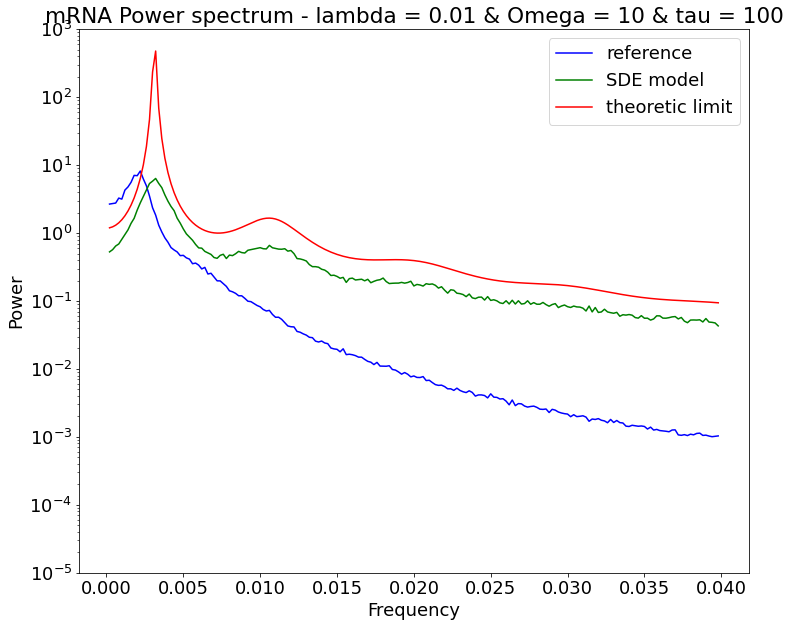

lambda= 0.01
Omega= 100
tau= 0.001


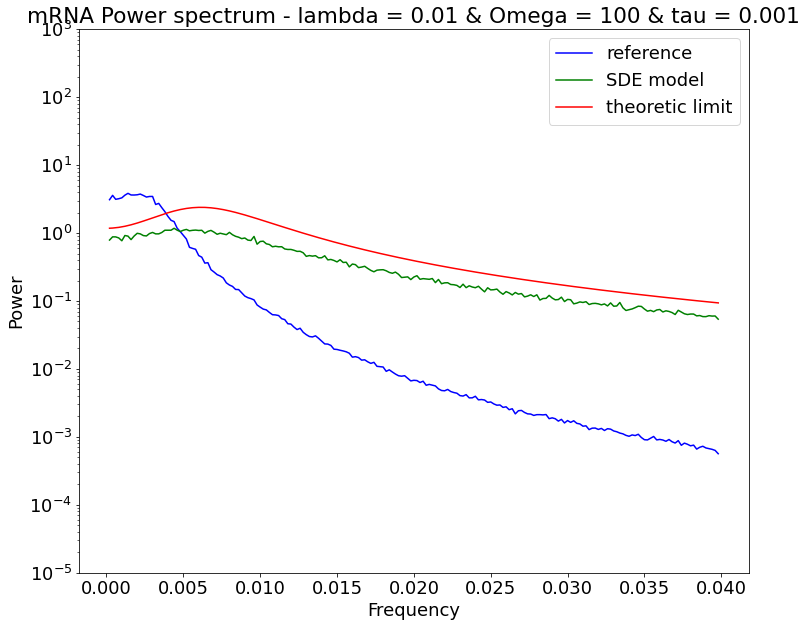

lambda= 0.01
Omega= 100
tau= 18.5


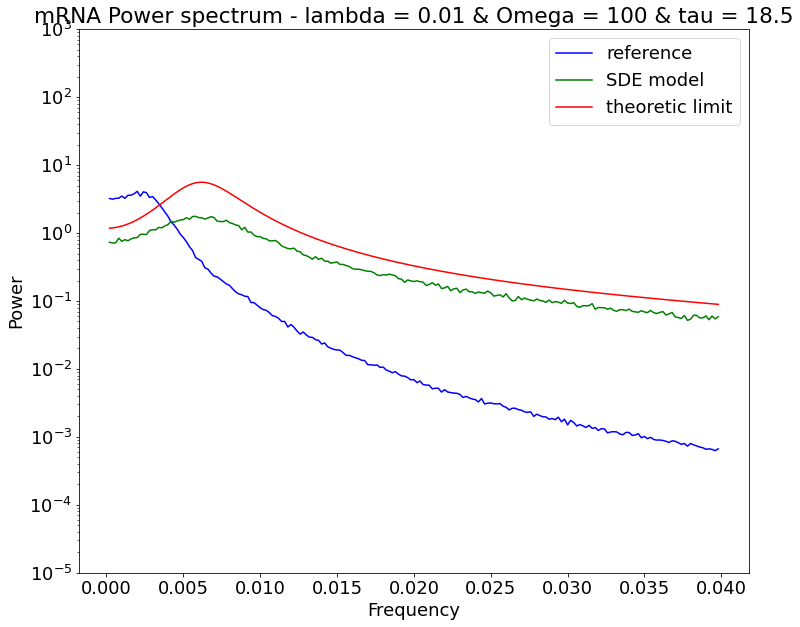

lambda= 0.01
Omega= 100
tau= 100


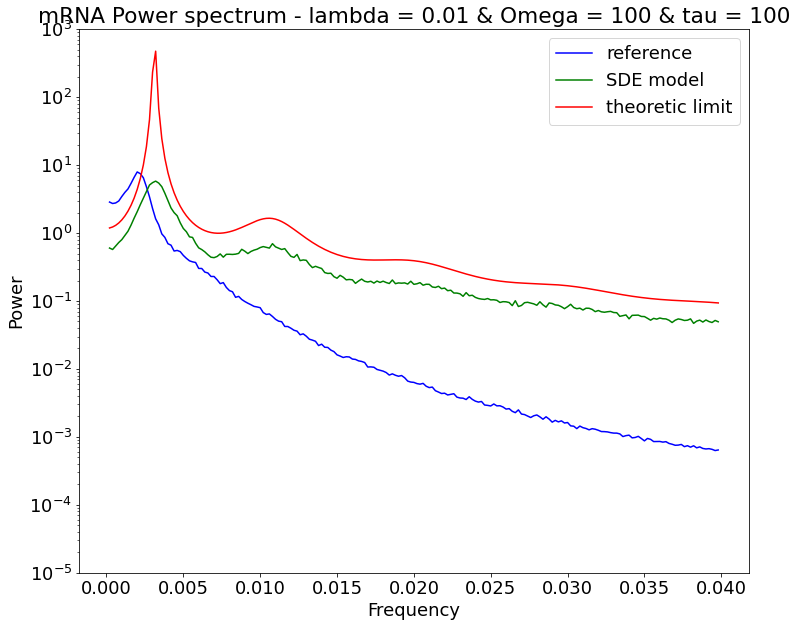

lambda= 0.1
Omega= 1
tau= 0.001


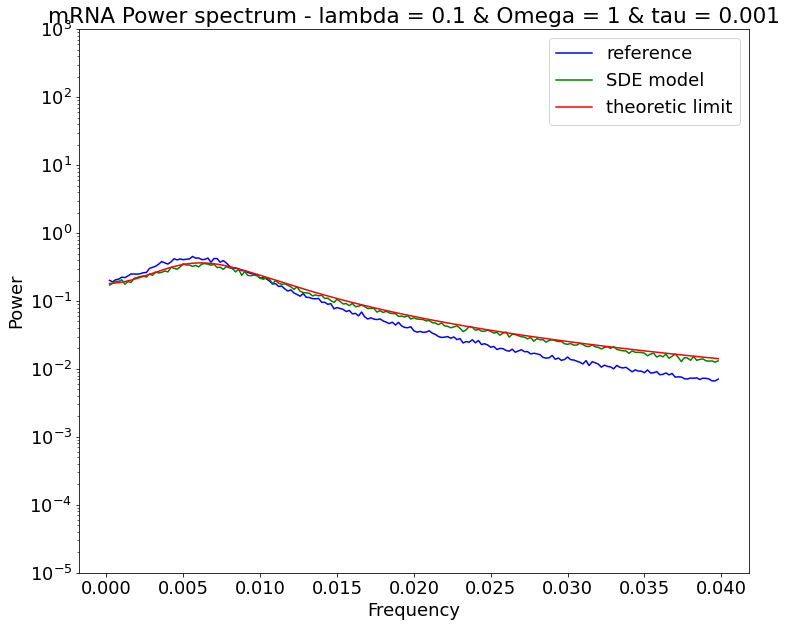

lambda= 0.1
Omega= 1
tau= 18.5


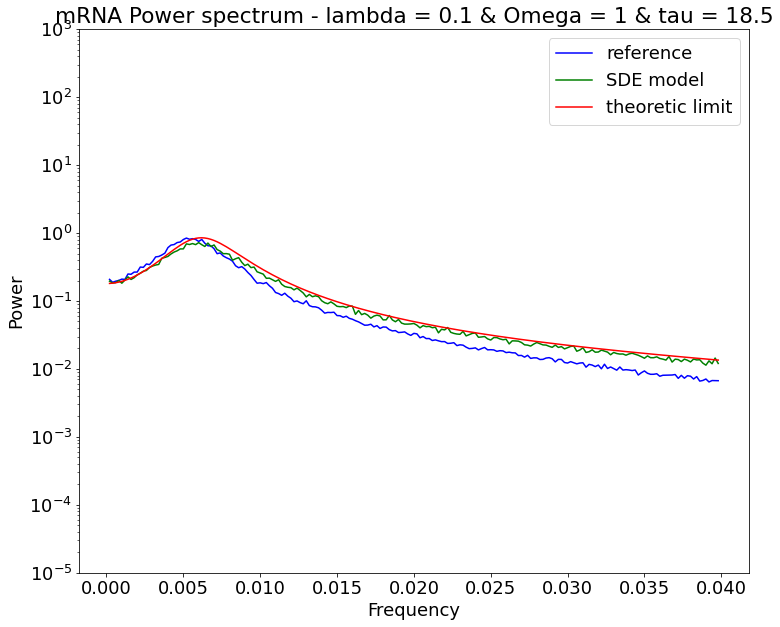

lambda= 0.1
Omega= 1
tau= 100


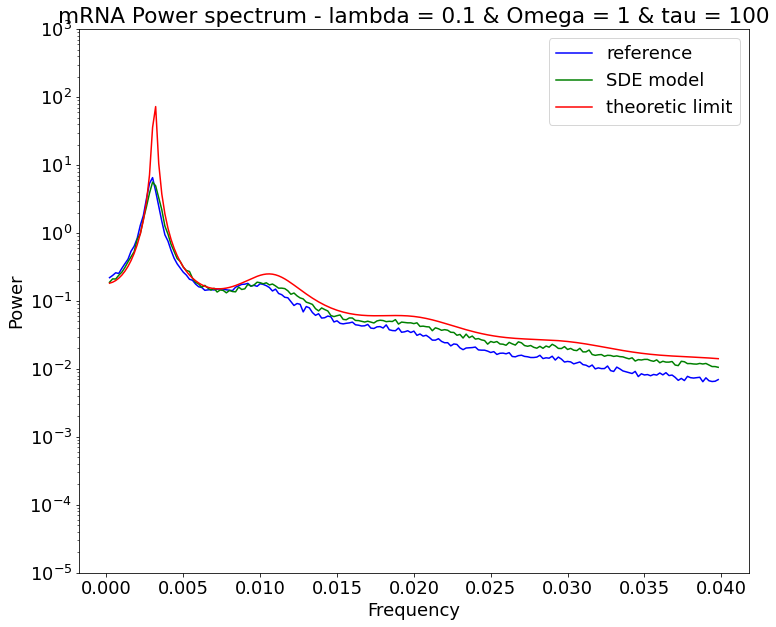

lambda= 0.1
Omega= 10
tau= 0.001


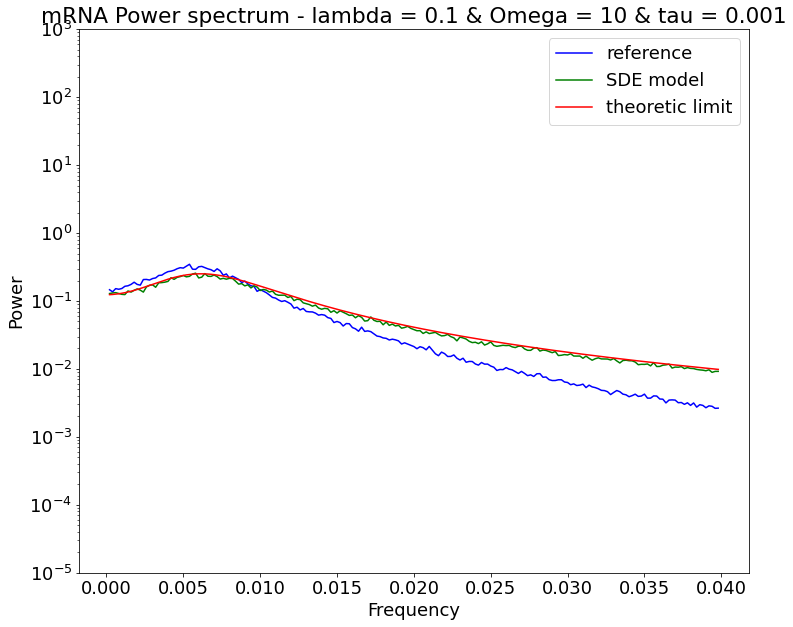

lambda= 0.1
Omega= 10
tau= 18.5


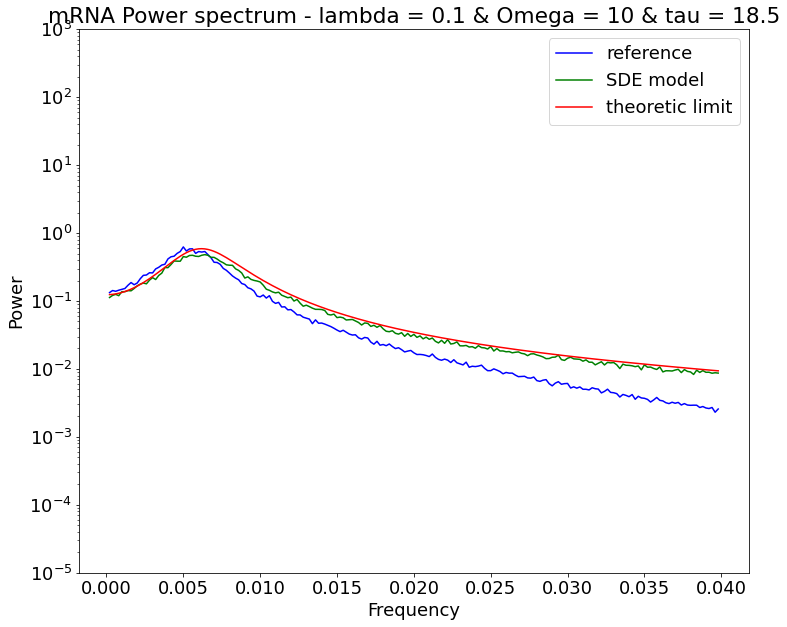

lambda= 0.1
Omega= 10
tau= 100


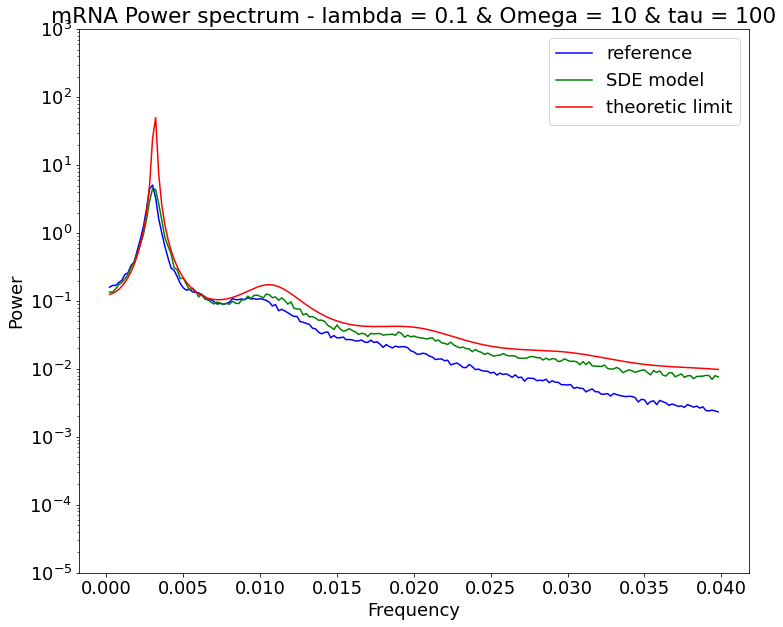

lambda= 0.1
Omega= 100
tau= 0.001


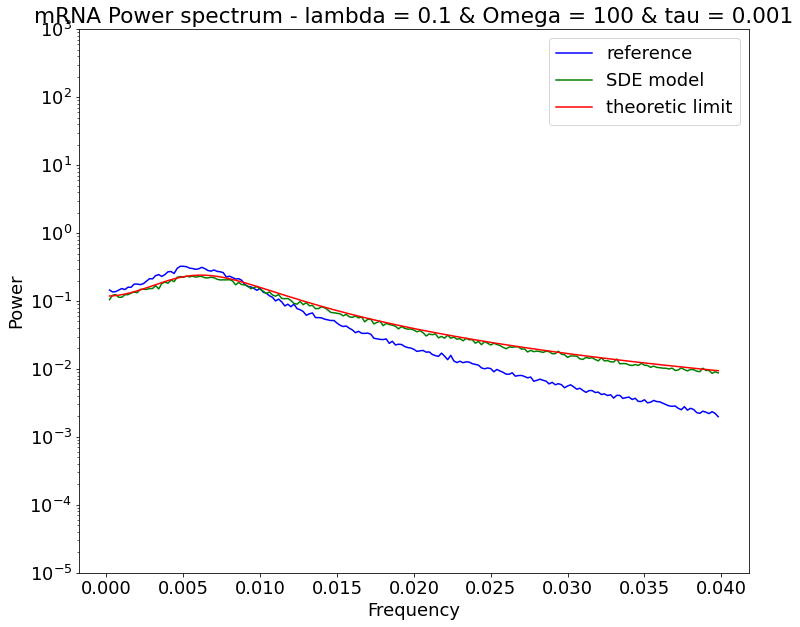

lambda= 0.1
Omega= 100
tau= 18.5


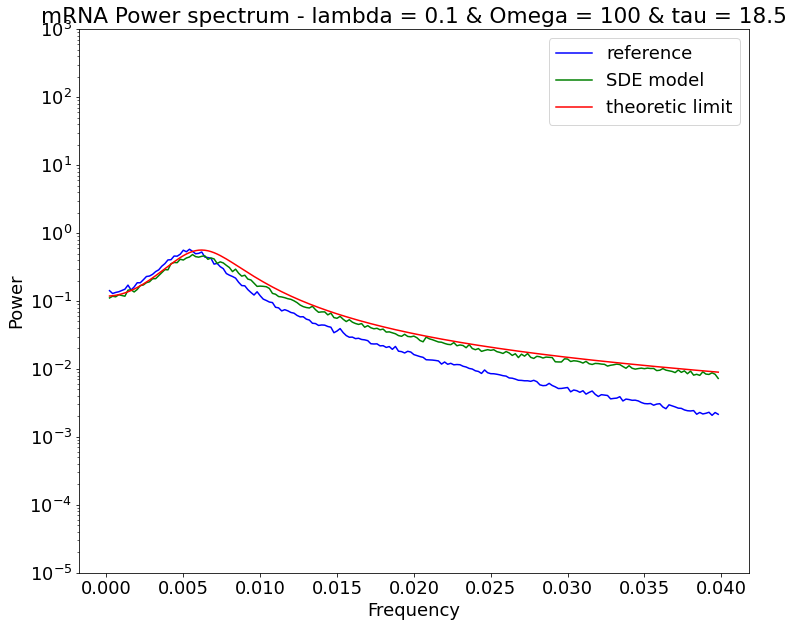

lambda= 0.1
Omega= 100
tau= 100


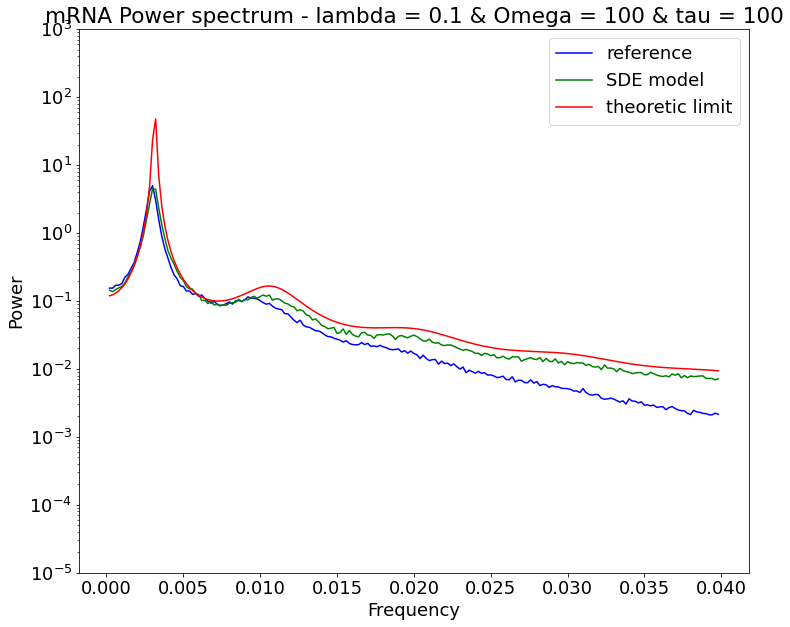

lambda= 1
Omega= 1
tau= 0.001


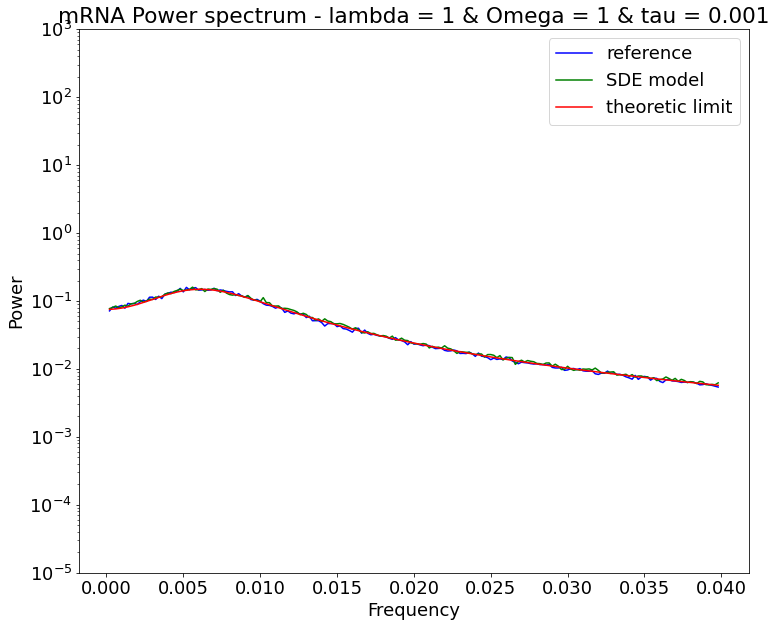

lambda= 1
Omega= 1
tau= 18.5


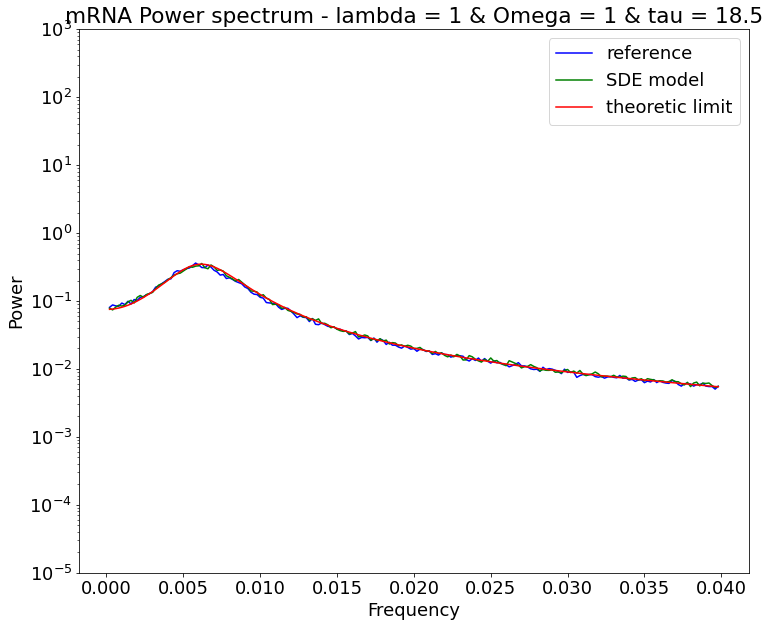

lambda= 1
Omega= 1
tau= 100


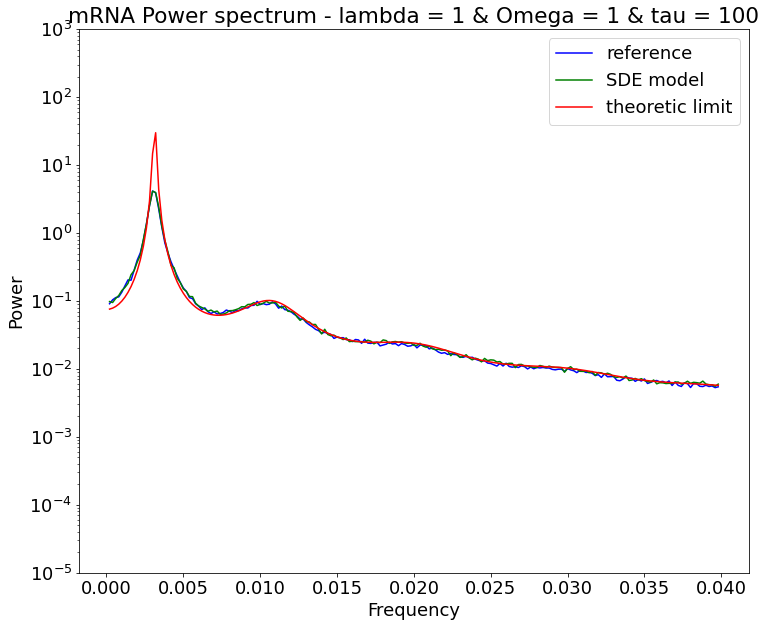

lambda= 1
Omega= 10
tau= 0.001


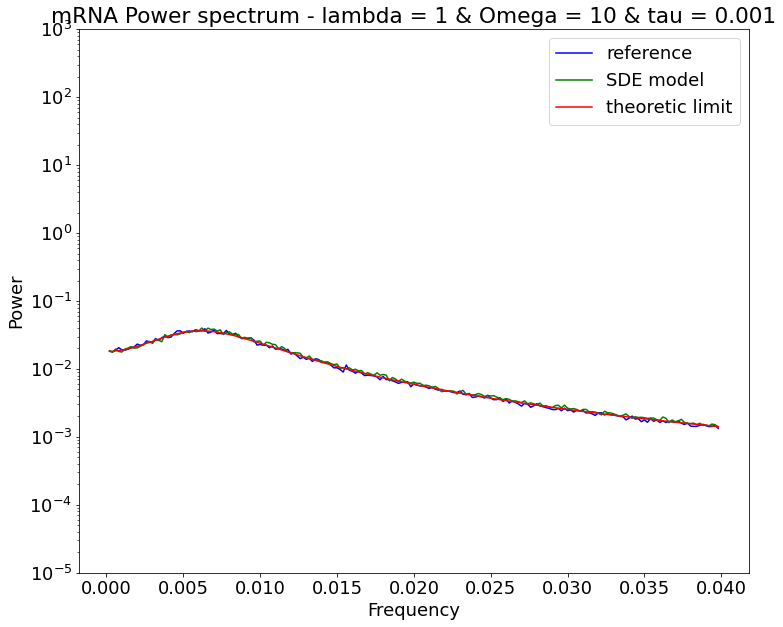

lambda= 1
Omega= 10
tau= 18.5


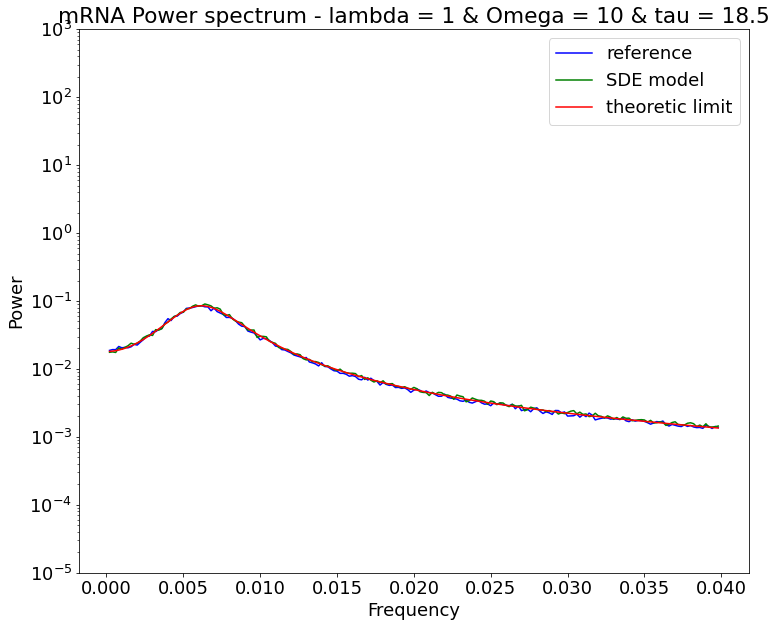

lambda= 1
Omega= 10
tau= 100


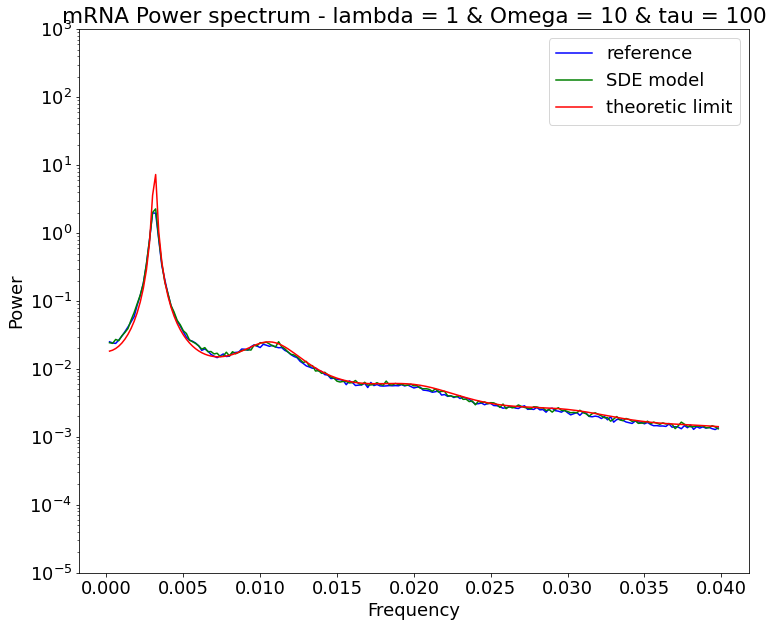

lambda= 1
Omega= 100
tau= 0.001


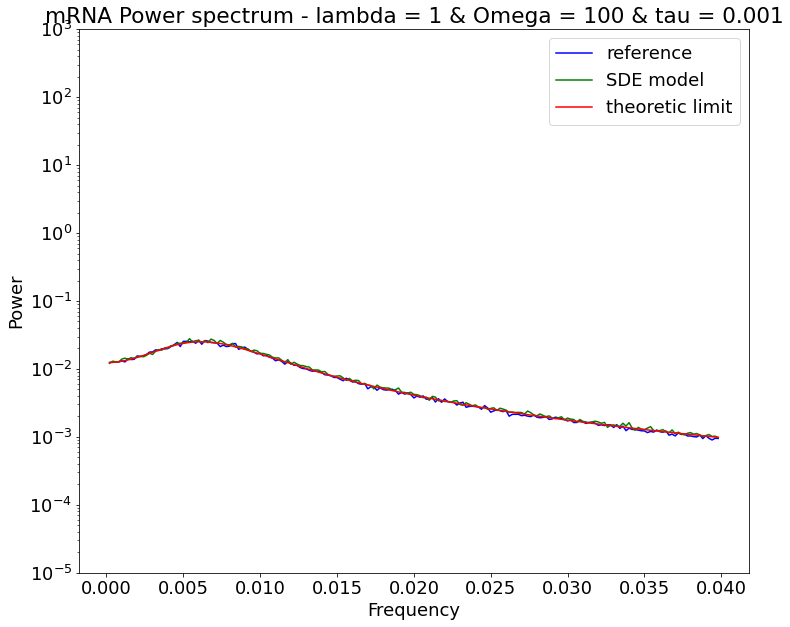

lambda= 1
Omega= 100
tau= 18.5


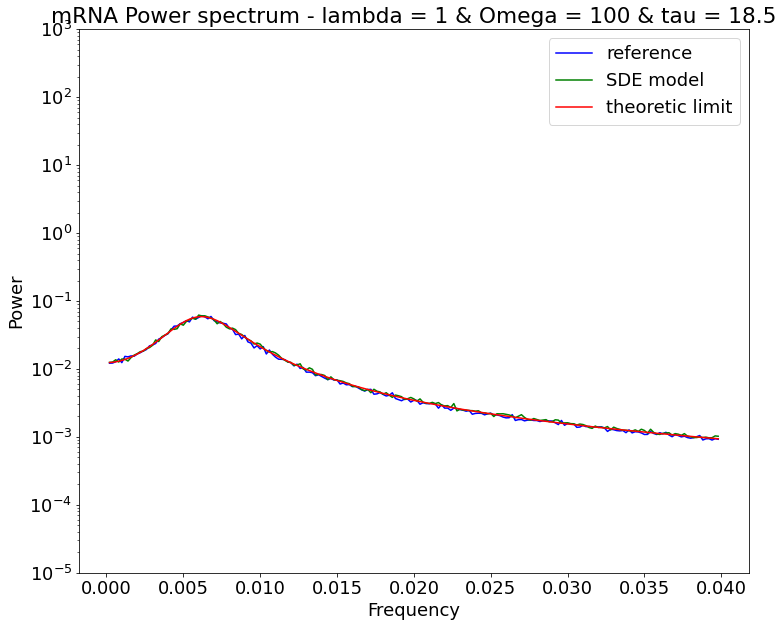

lambda= 1
Omega= 100
tau= 100


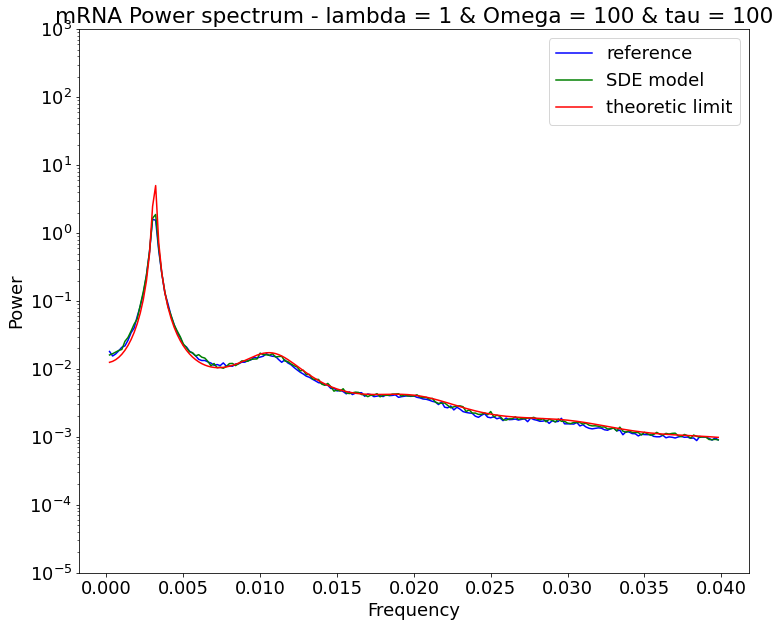

lambda= 10
Omega= 1
tau= 0.001


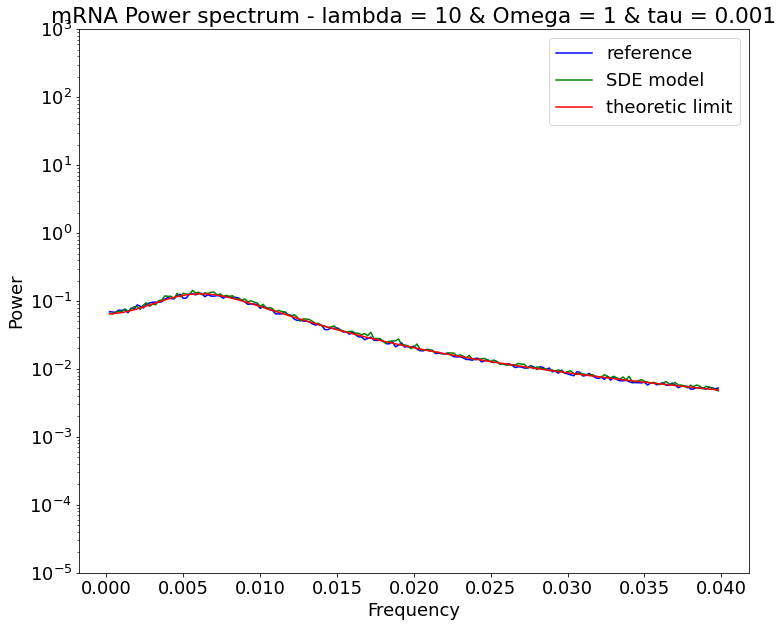

lambda= 10
Omega= 1
tau= 18.5


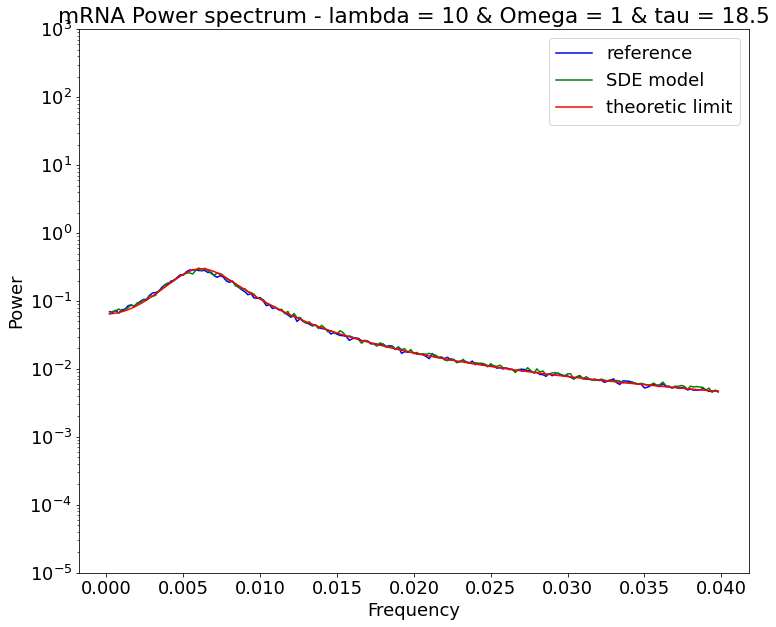

lambda= 10
Omega= 1
tau= 100


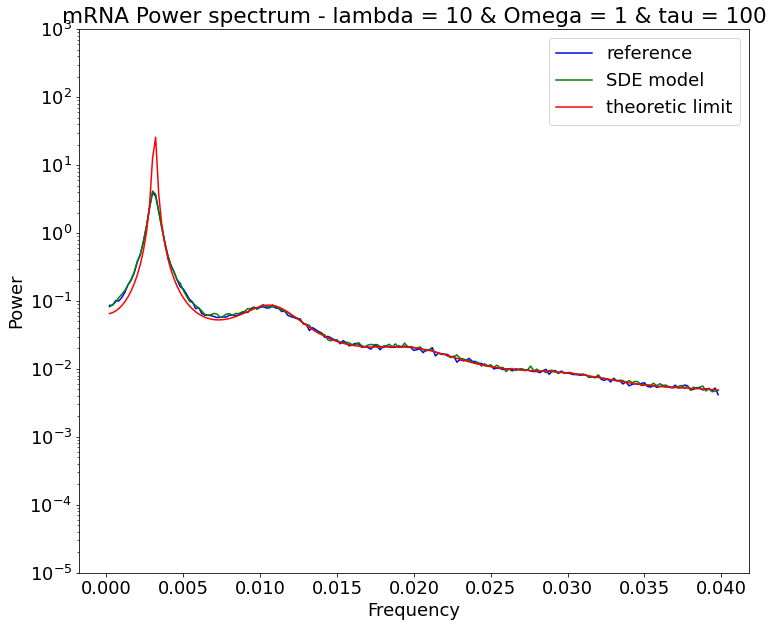

lambda= 10
Omega= 10
tau= 0.001


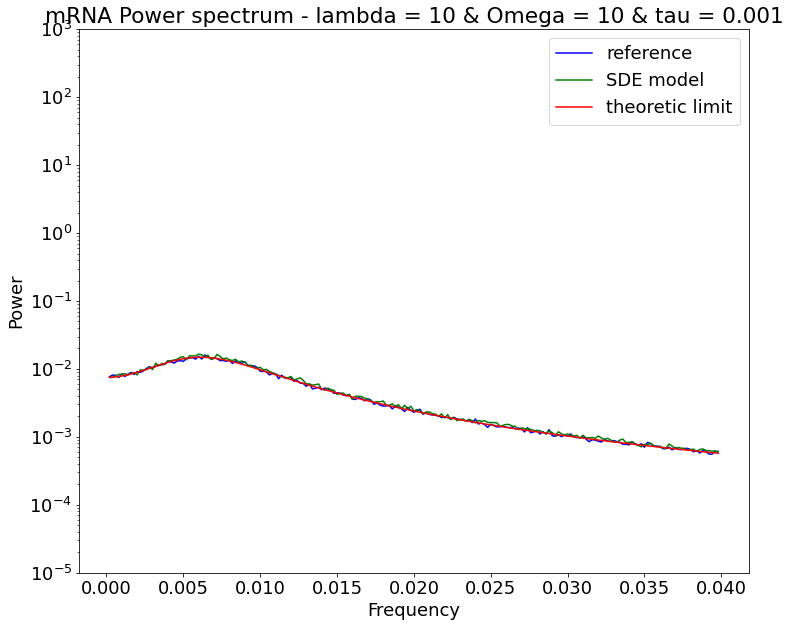

lambda= 10
Omega= 10
tau= 18.5


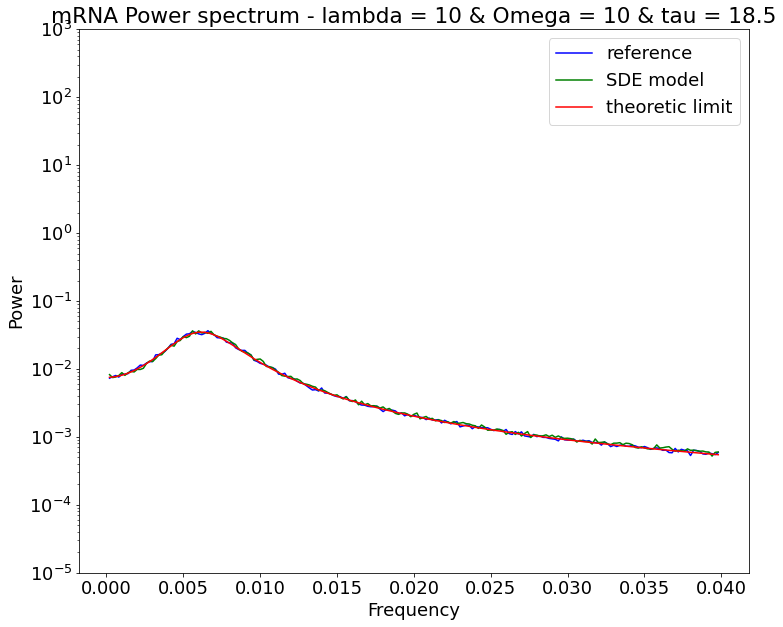

lambda= 10
Omega= 10
tau= 100


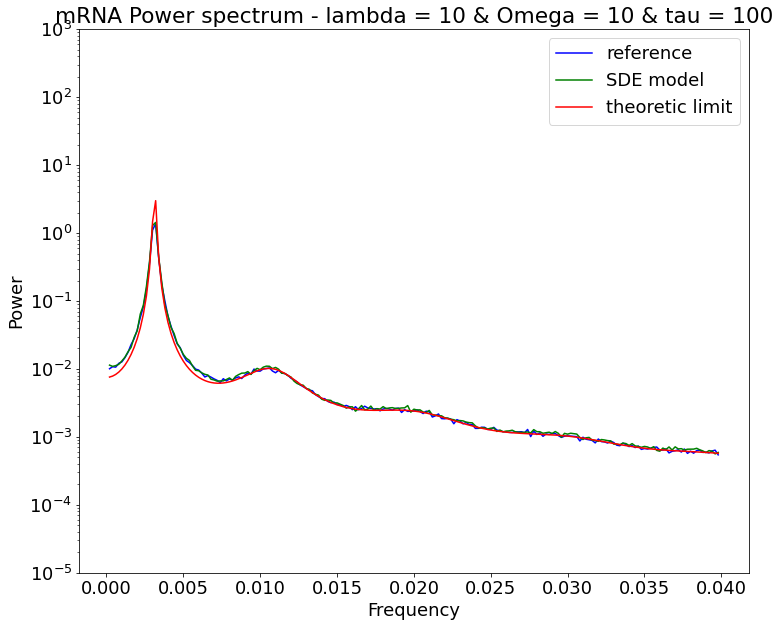

lambda= 10
Omega= 100
tau= 0.001


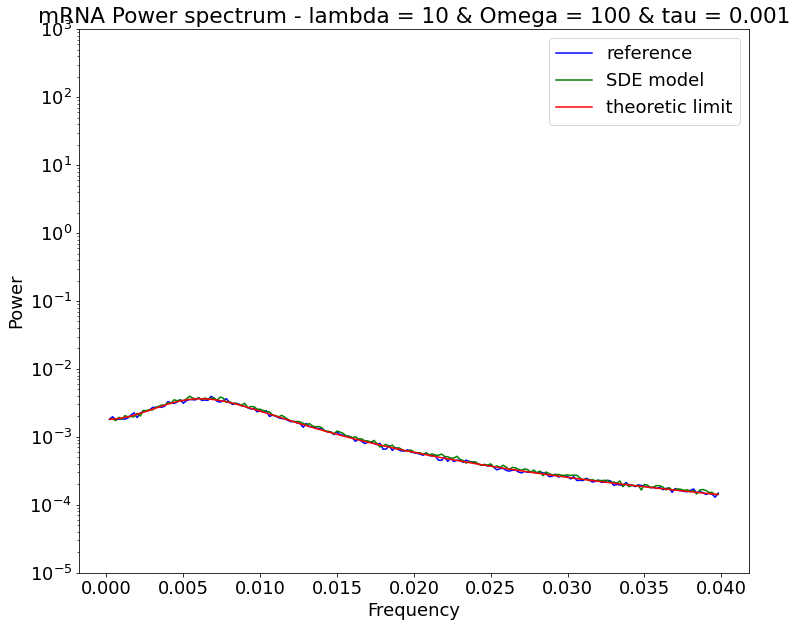

lambda= 10
Omega= 100
tau= 18.5


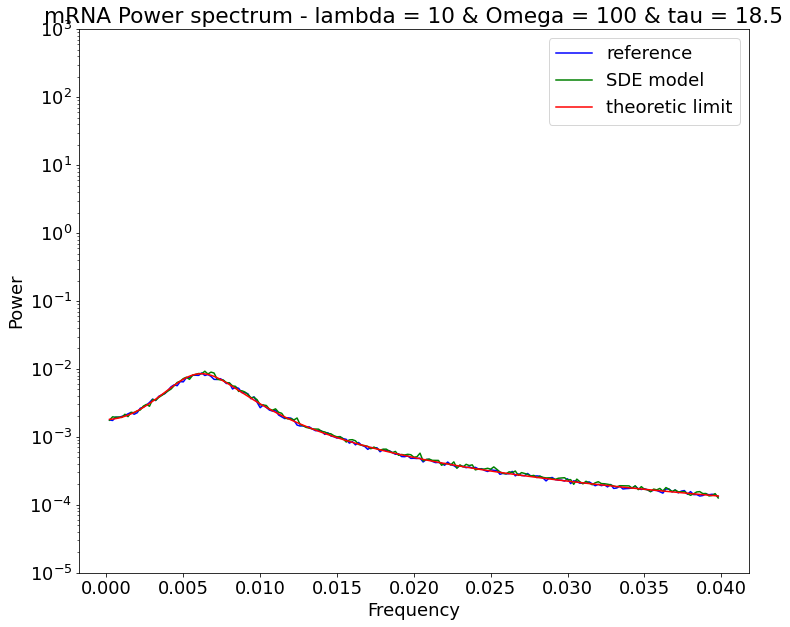

lambda= 10
Omega= 100
tau= 100


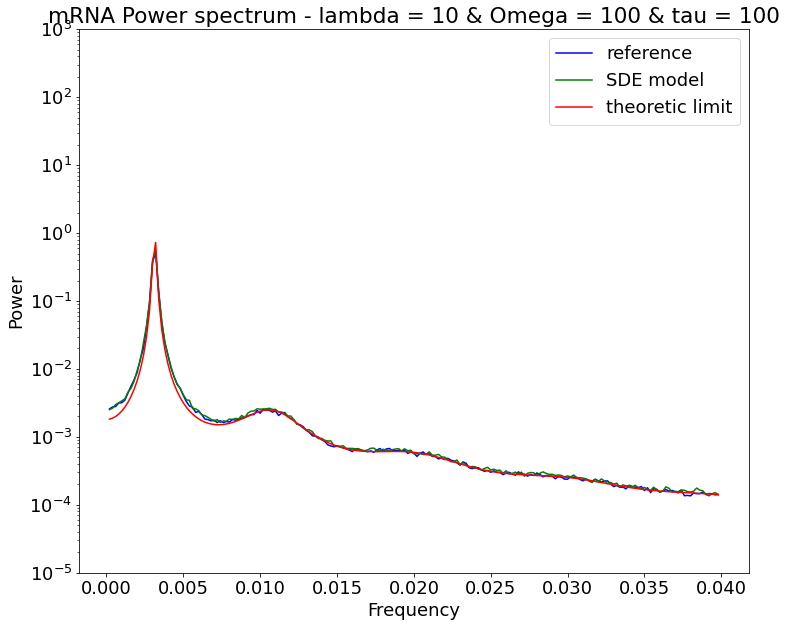

lambda= 100
Omega= 1
tau= 0.001


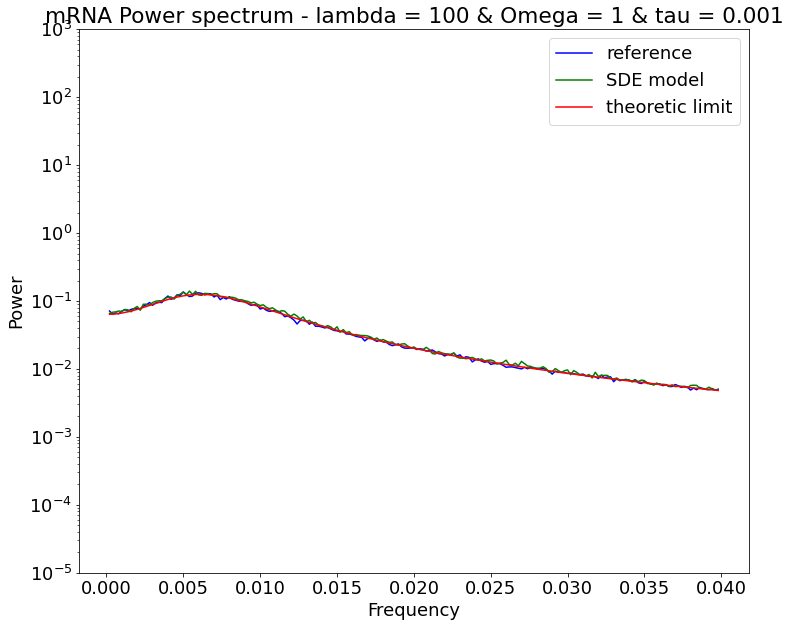

lambda= 100
Omega= 1
tau= 18.5


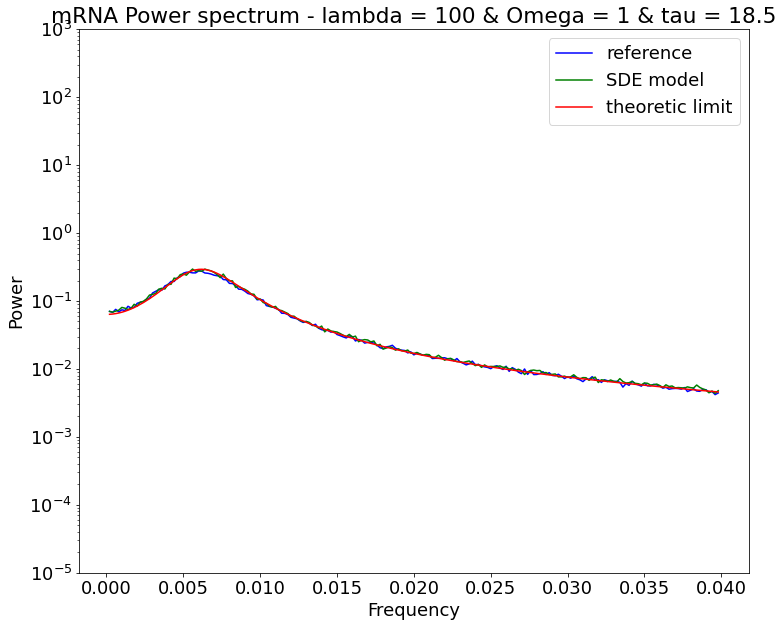

lambda= 100
Omega= 1
tau= 100


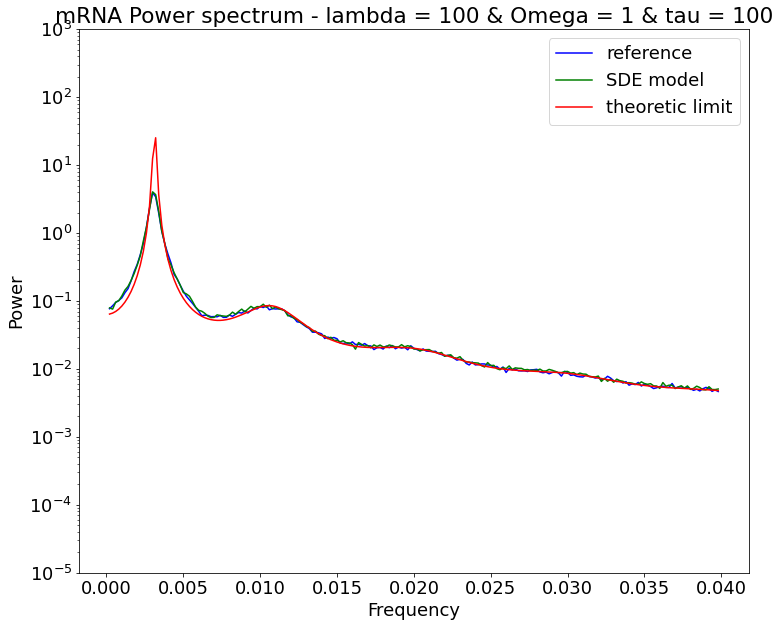

lambda= 100
Omega= 10
tau= 0.001


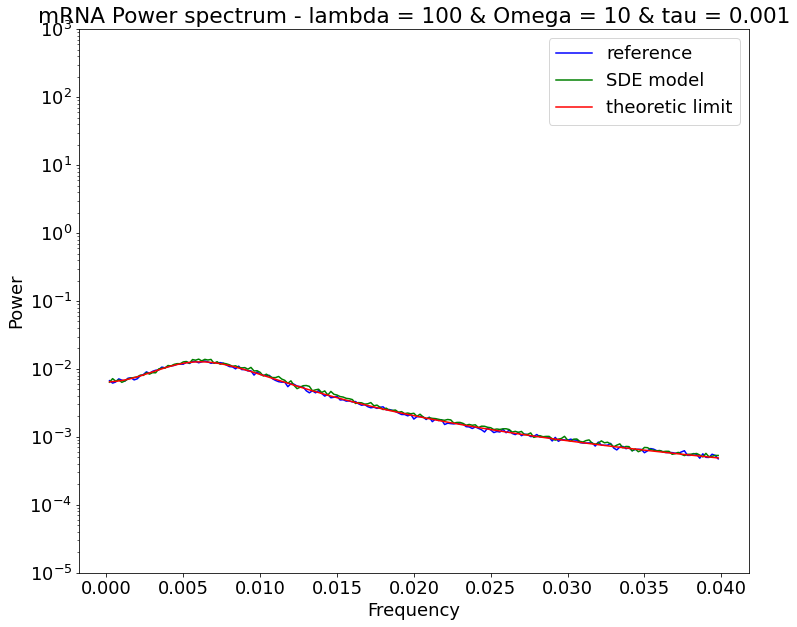

lambda= 100
Omega= 10
tau= 18.5


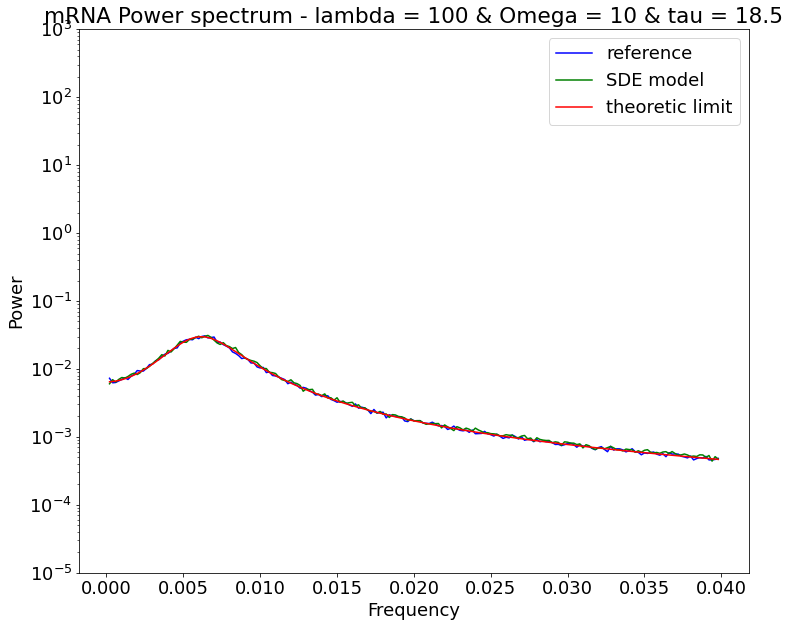

lambda= 100
Omega= 10
tau= 100


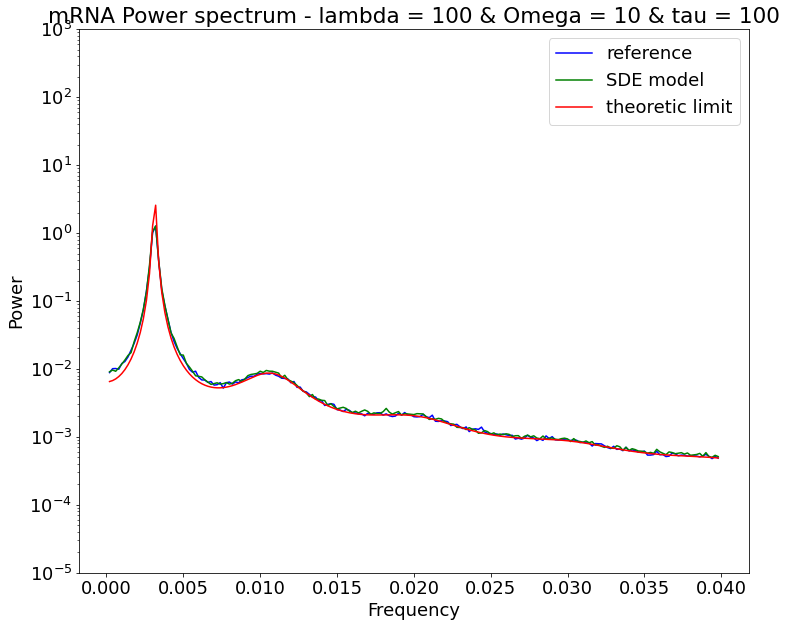

lambda= 100
Omega= 100
tau= 0.001


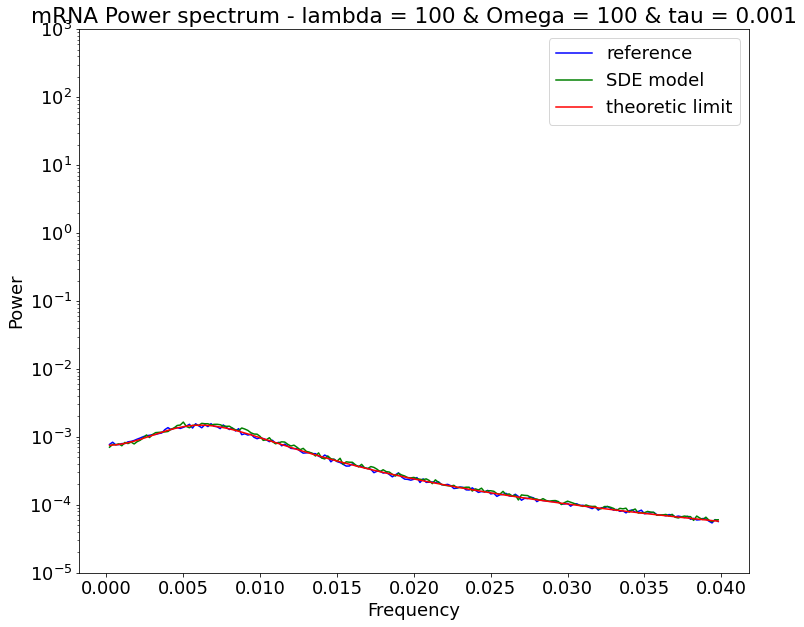

lambda= 100
Omega= 100
tau= 18.5


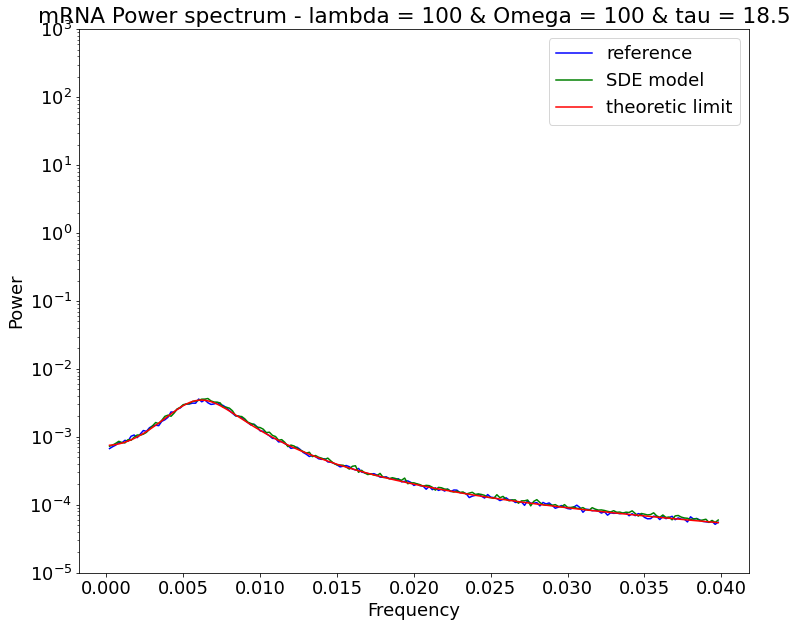

lambda= 100
Omega= 100
tau= 100


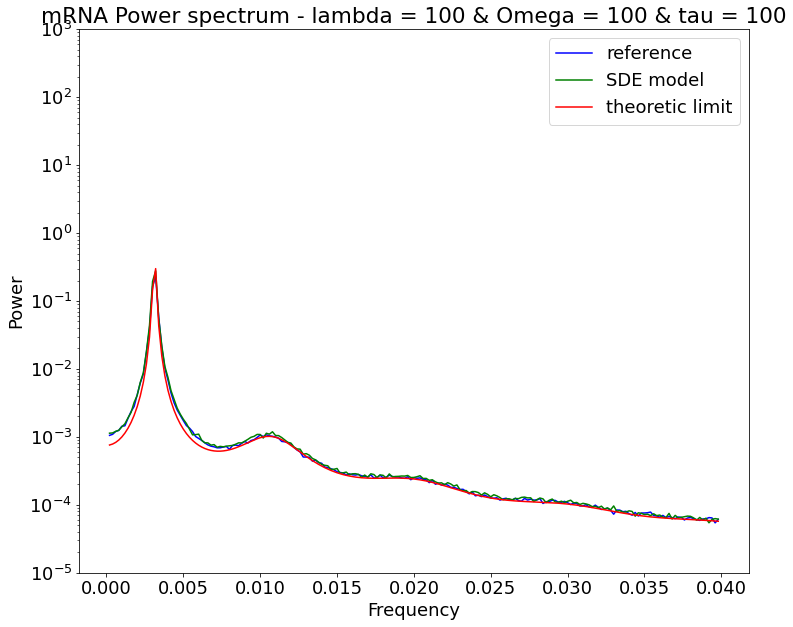

In [34]:
for i in range(n_lambda):
    for j in range(n_Omega):
        for k in range(n_tau):
        
            print('lambda=',val_lambda[i])    
            print('Omega=',val_Omega[j])
            print('tau=',val_tau[k])

            fig, ax1 = plt.subplots(figsize=(12,10)) 

            ax1.set_title('mRNA Power spectrum - lambda = ' + str(val_lambda[i]) + ' & Omega = ' +  str(val_Omega[j]) + ' & tau = ' + str(val_tau[k])) 
            ax1.set_xlabel('Frequency') 
            ax1.set_ylabel('Power') 

            freq_th,Sm,_=utils.lna_power_spectrum(h=h,lambda_s=val_lambda[i],P_0=1000,tau=val_tau[k],Omega=val_Omega[j],T=T/2,delta_t=1)
            
            ax1.plot(freq_ref[1:200]/(2*np.pi), power_spectrum_Mm[1:200,i,j,k], color = 'blue') 
            ax1.plot(freq_ref[1:200]/(2*np.pi), power_spectrum_Ml[1:200,i,j,k], color = 'green')
            ax1.plot(freq_th[1:200], Sm[1:200]/(n_t/2), color = 'red')    
            
            ax1.tick_params(axis ='y') 
            ax1.set_yscale('log')        
            ax1.legend([linem, linel, linet], ['reference', 'SDE model', 'theoretic limit'])

            #ax1.set_xlim(0, 0.4)
            ax1.set_ylim(0.00001, 1000)
            
            plt.savefig(read_directory + '\\plots\\power_spectrum_M\\plot_power_spectrum_M - lambda' + str(val_lambda[i]) + 'and Omega' +  str(val_Omega[j]) + ' and tau' + str(val_tau[k]) + '.pdf')  

            plt.show()

lambda= 0.01
Omega= 1
tau= 0.001


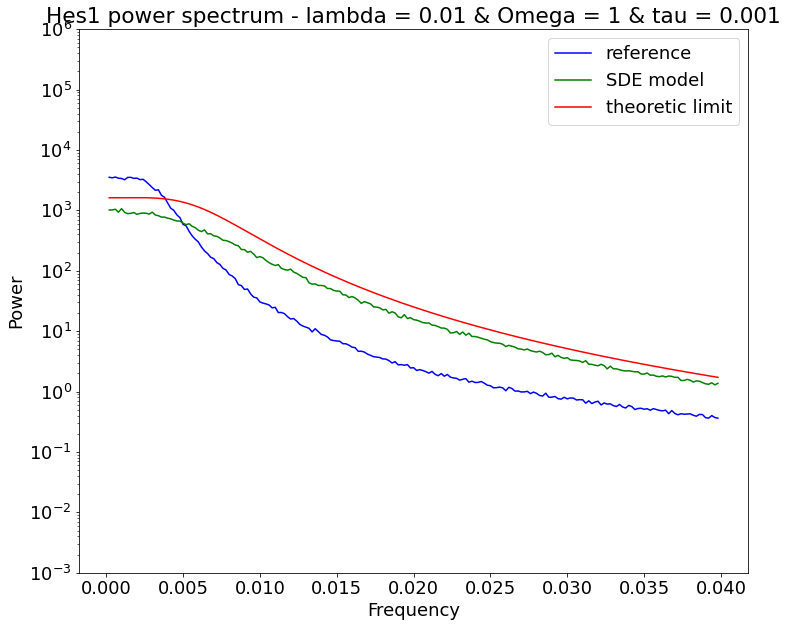

lambda= 0.01
Omega= 1
tau= 18.5


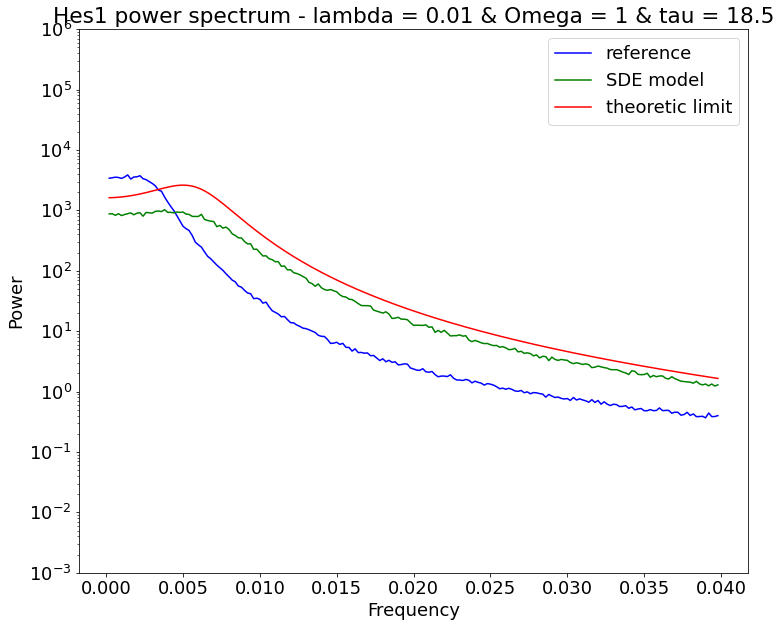

lambda= 0.01
Omega= 1
tau= 100


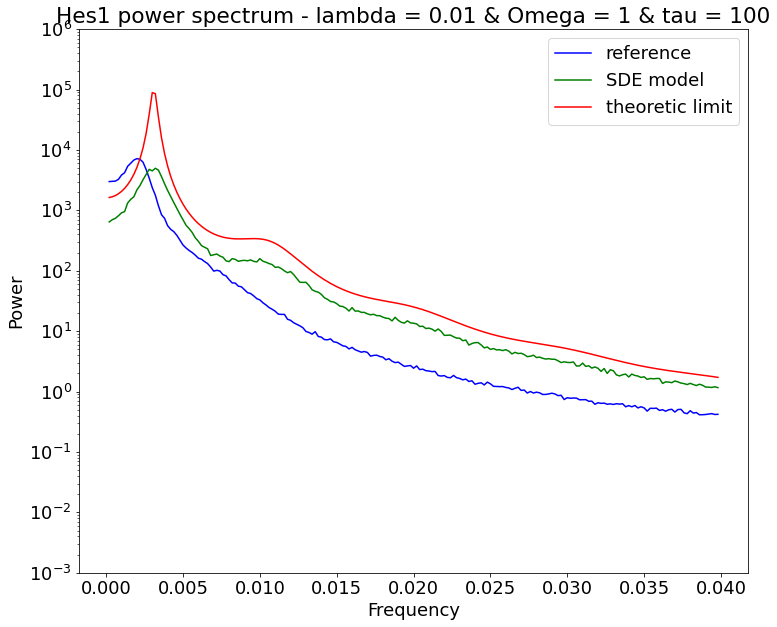

lambda= 0.01
Omega= 10
tau= 0.001


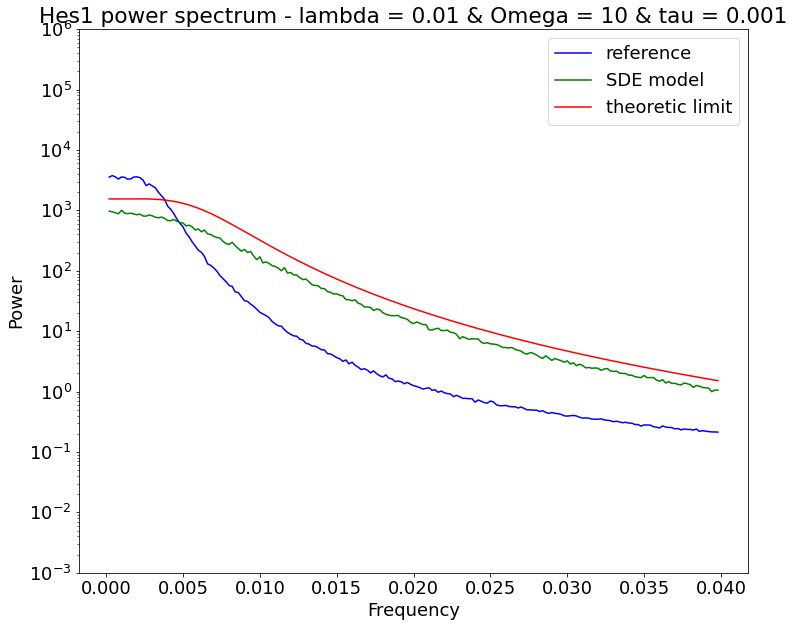

lambda= 0.01
Omega= 10
tau= 18.5


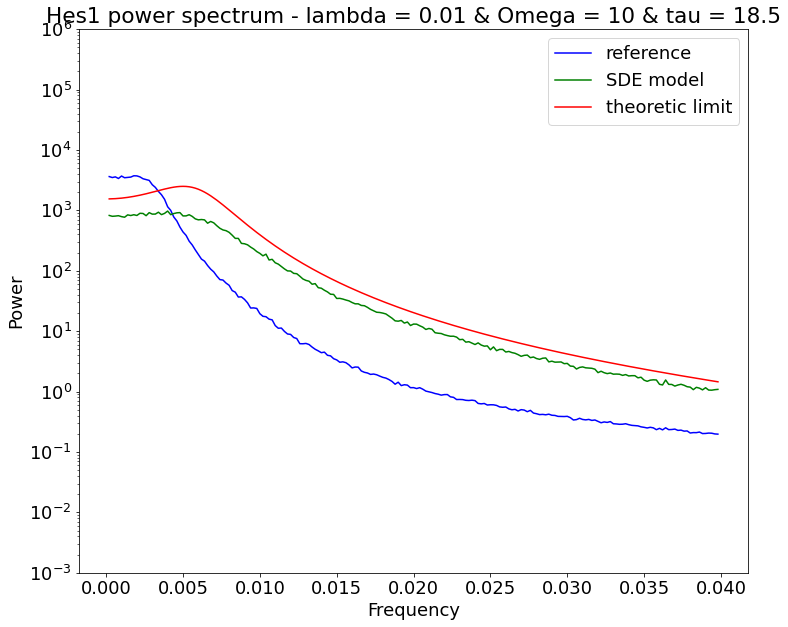

lambda= 0.01
Omega= 10
tau= 100


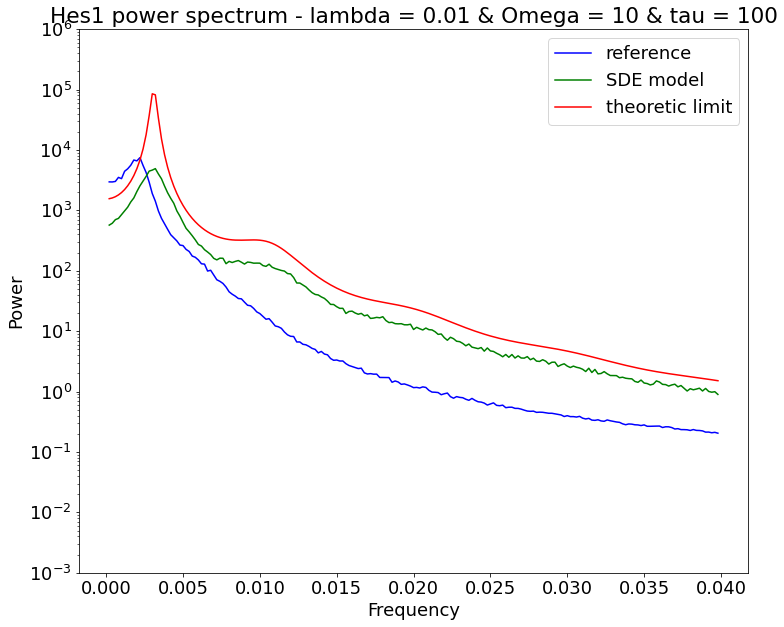

lambda= 0.01
Omega= 100
tau= 0.001


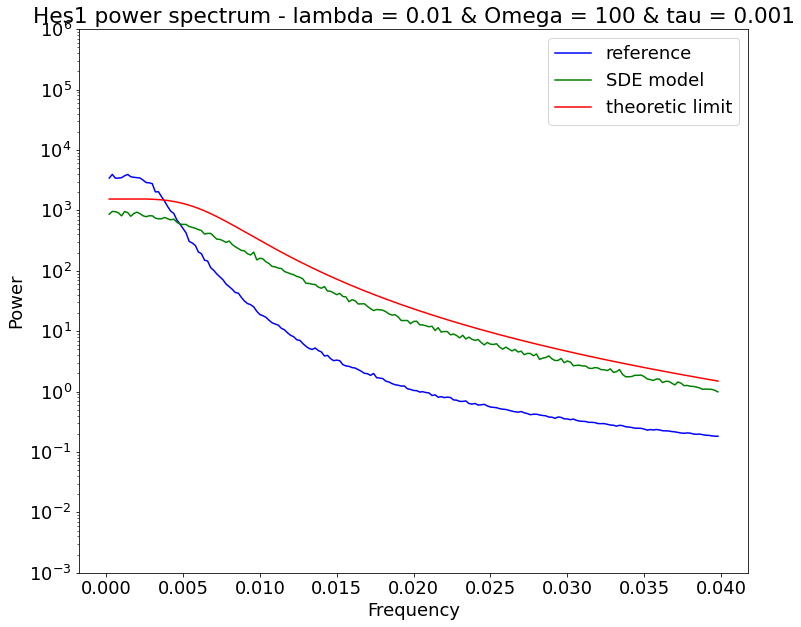

lambda= 0.01
Omega= 100
tau= 18.5


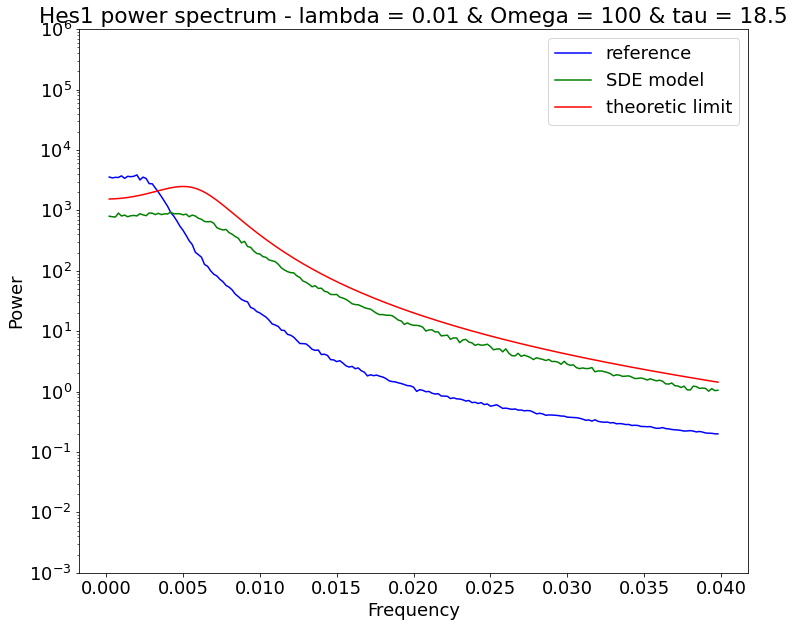

lambda= 0.01
Omega= 100
tau= 100


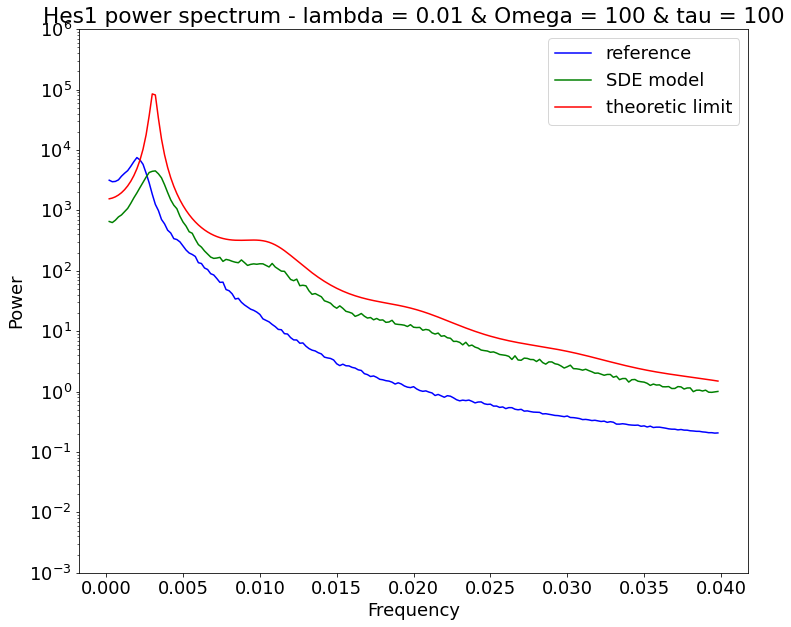

lambda= 0.1
Omega= 1
tau= 0.001


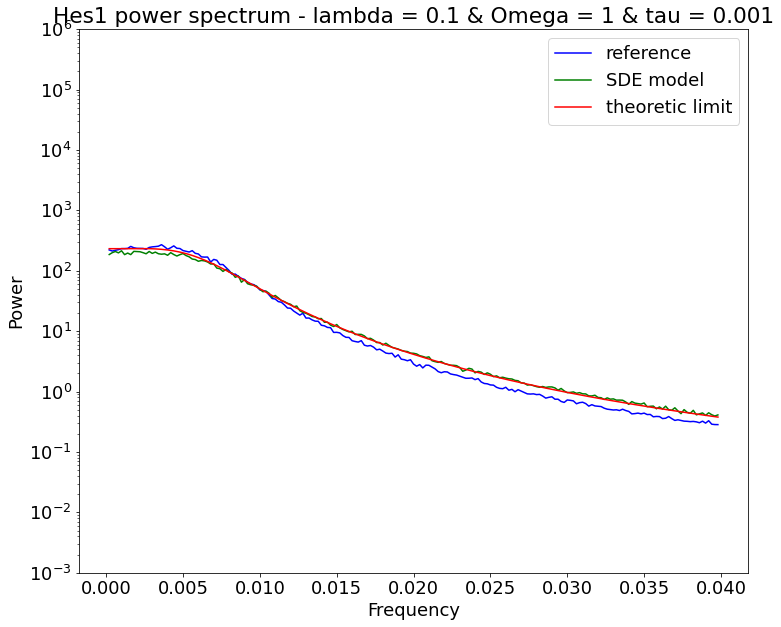

lambda= 0.1
Omega= 1
tau= 18.5


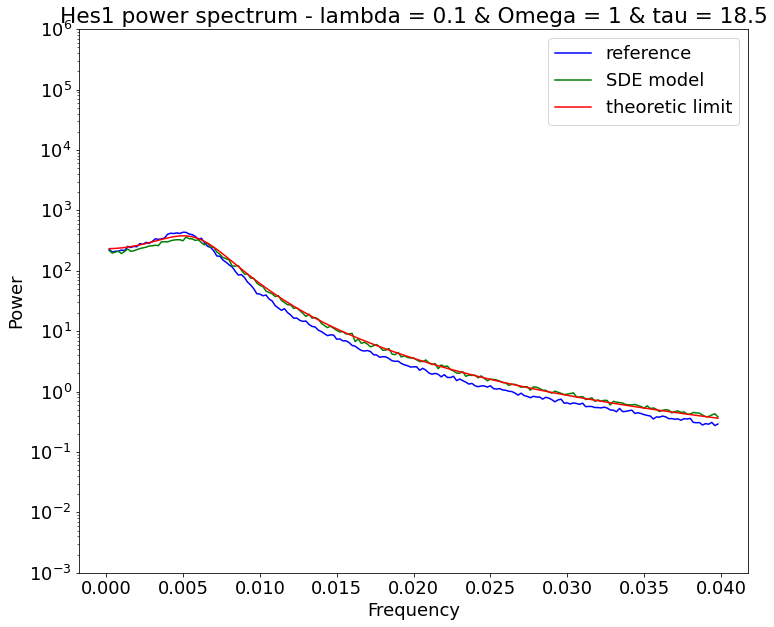

lambda= 0.1
Omega= 1
tau= 100


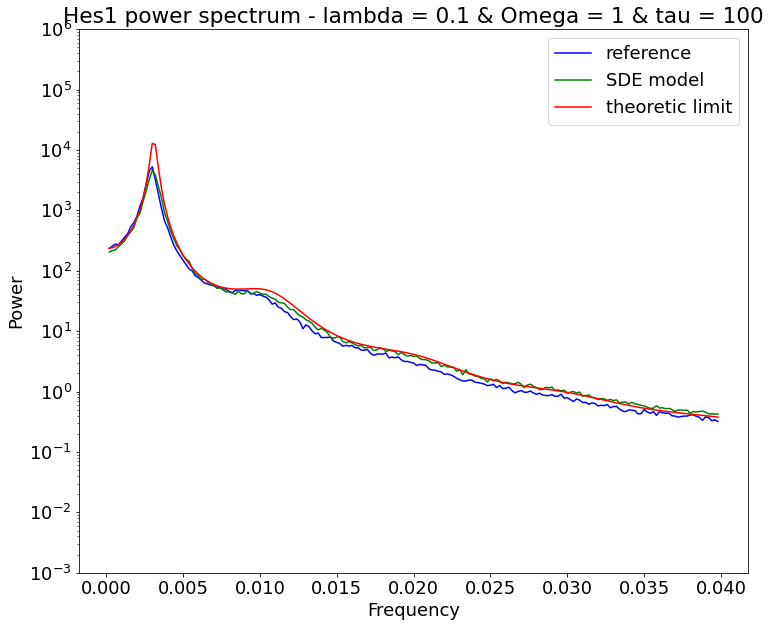

lambda= 0.1
Omega= 10
tau= 0.001


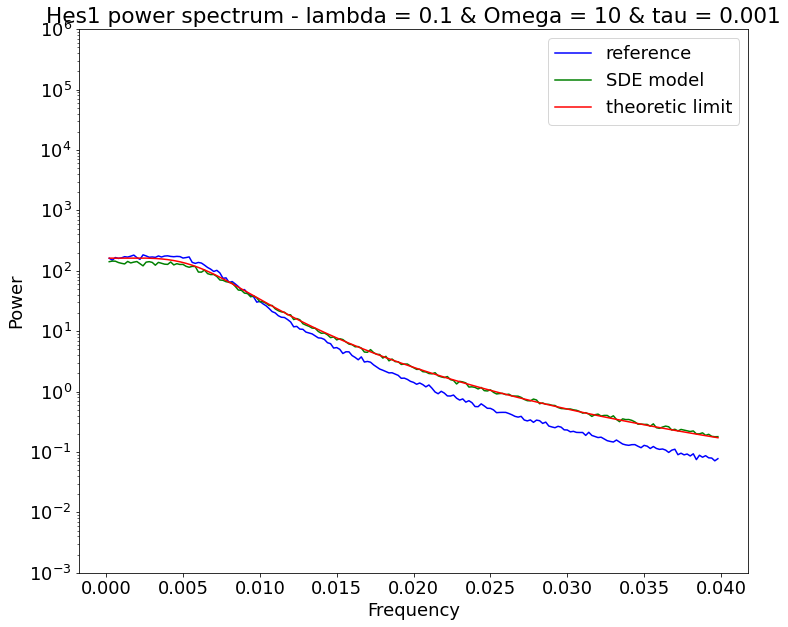

lambda= 0.1
Omega= 10
tau= 18.5


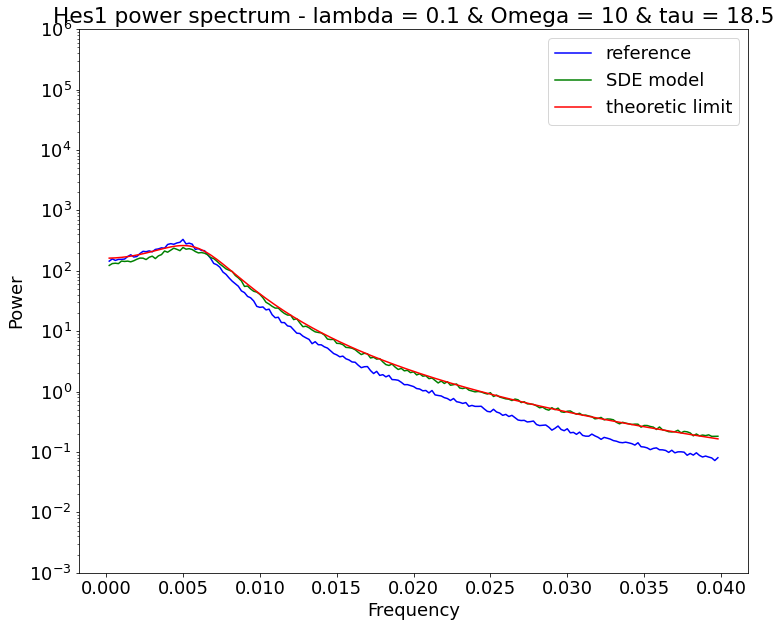

lambda= 0.1
Omega= 10
tau= 100


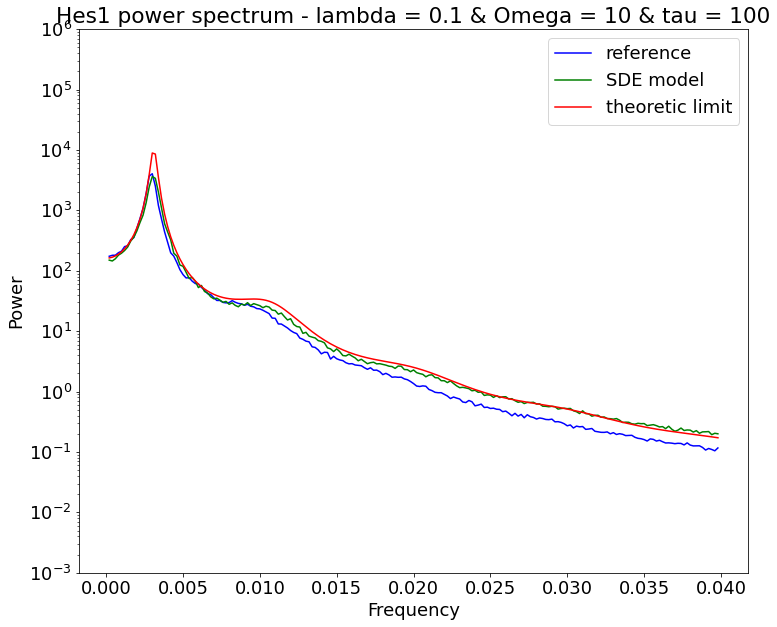

lambda= 0.1
Omega= 100
tau= 0.001


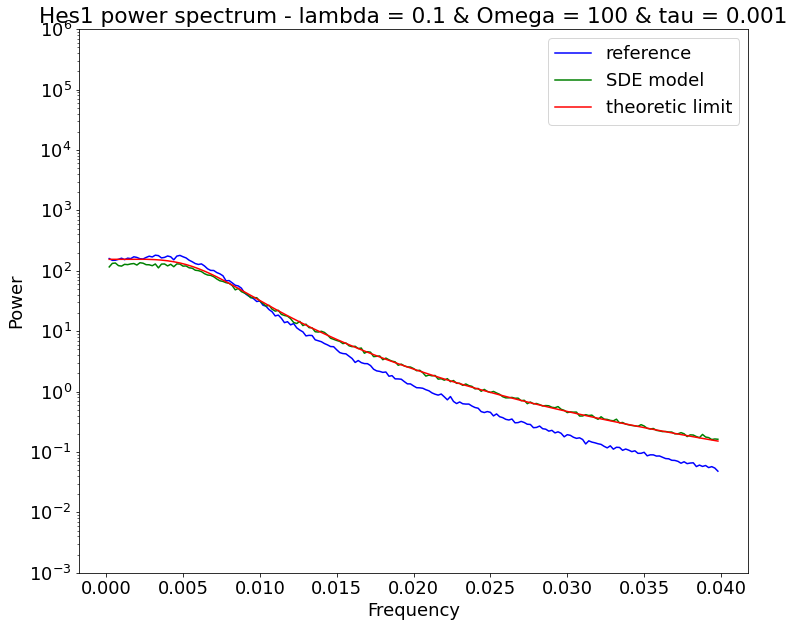

lambda= 0.1
Omega= 100
tau= 18.5


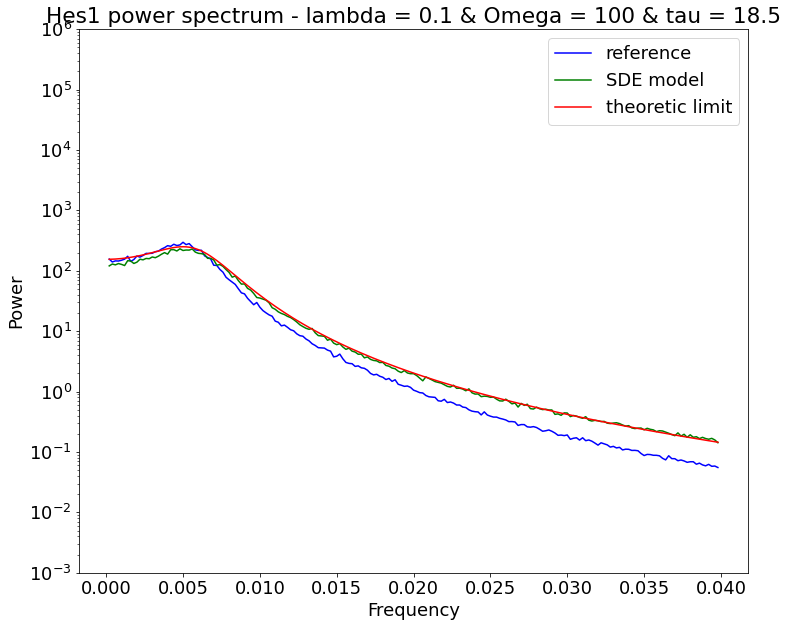

lambda= 0.1
Omega= 100
tau= 100


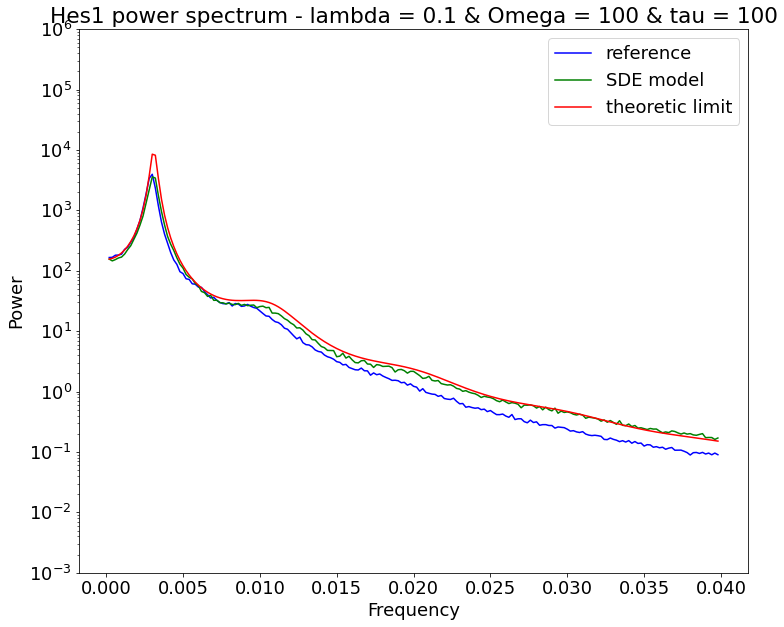

lambda= 1
Omega= 1
tau= 0.001


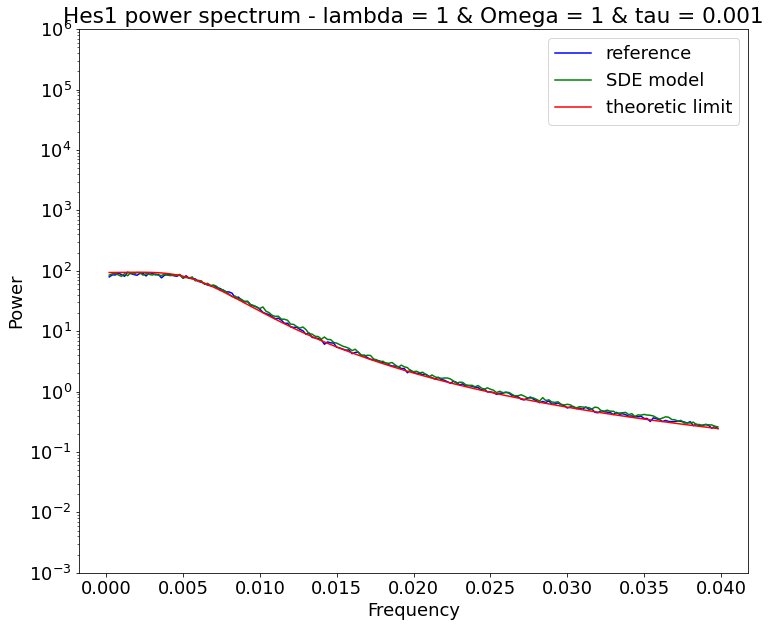

lambda= 1
Omega= 1
tau= 18.5


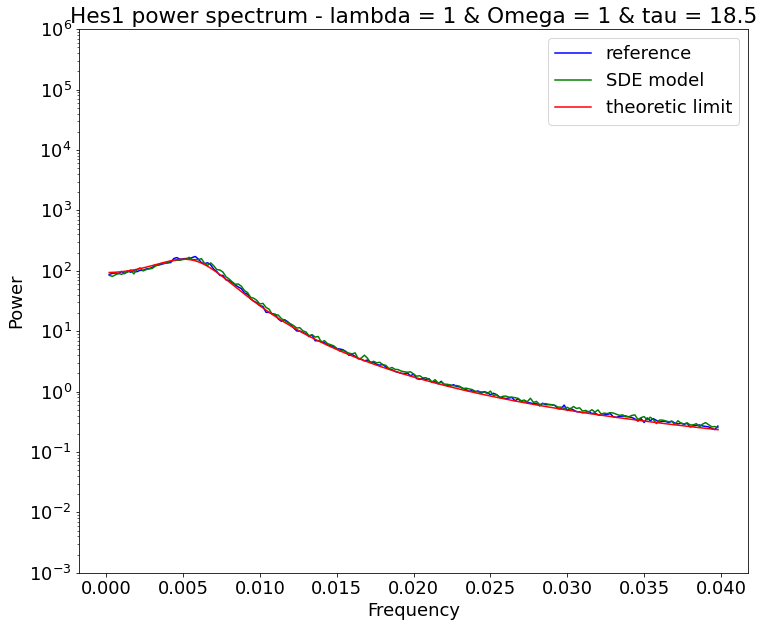

lambda= 1
Omega= 1
tau= 100


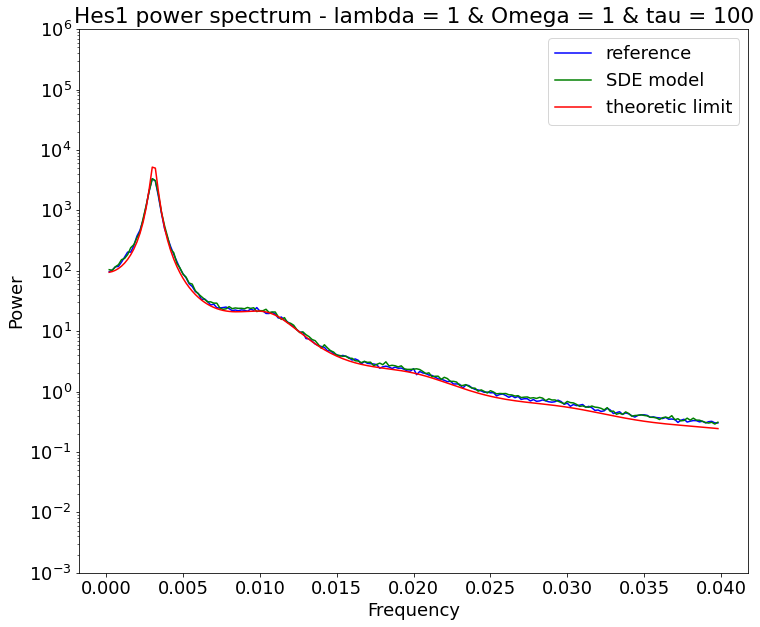

lambda= 1
Omega= 10
tau= 0.001


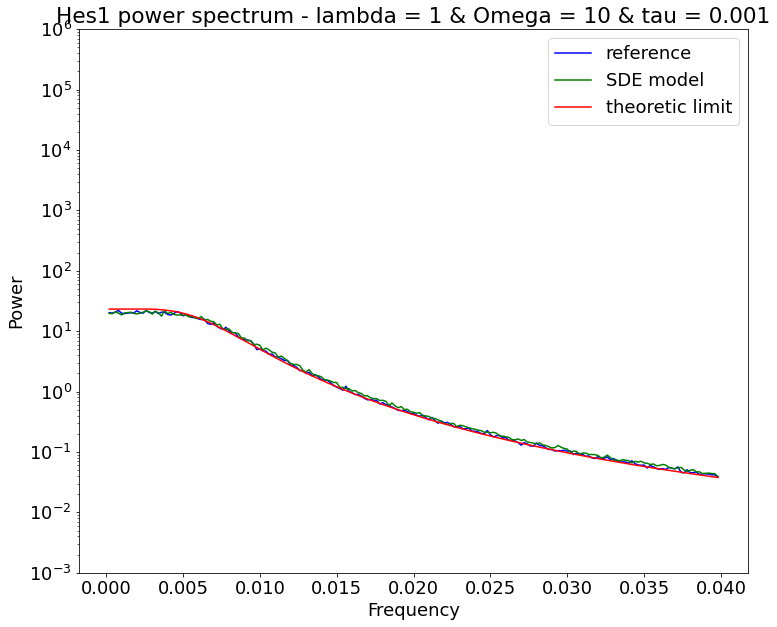

lambda= 1
Omega= 10
tau= 18.5


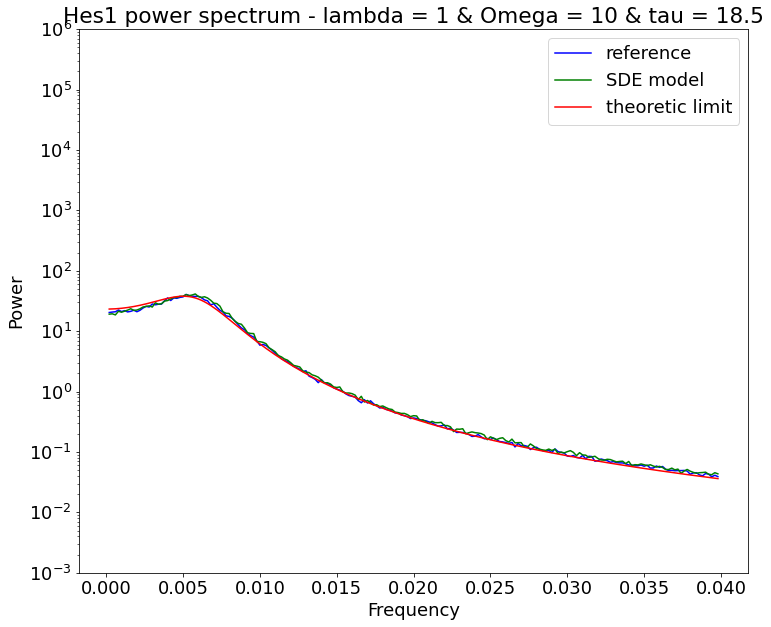

lambda= 1
Omega= 10
tau= 100


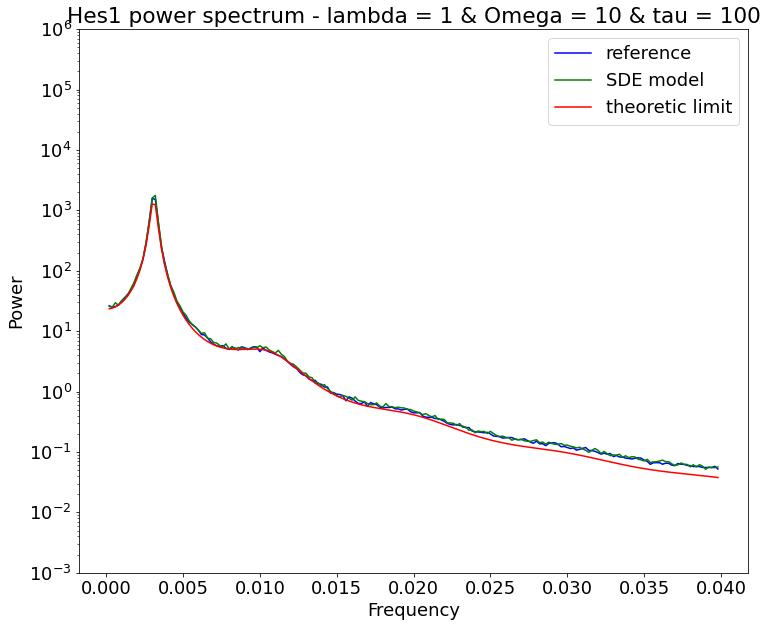

lambda= 1
Omega= 100
tau= 0.001


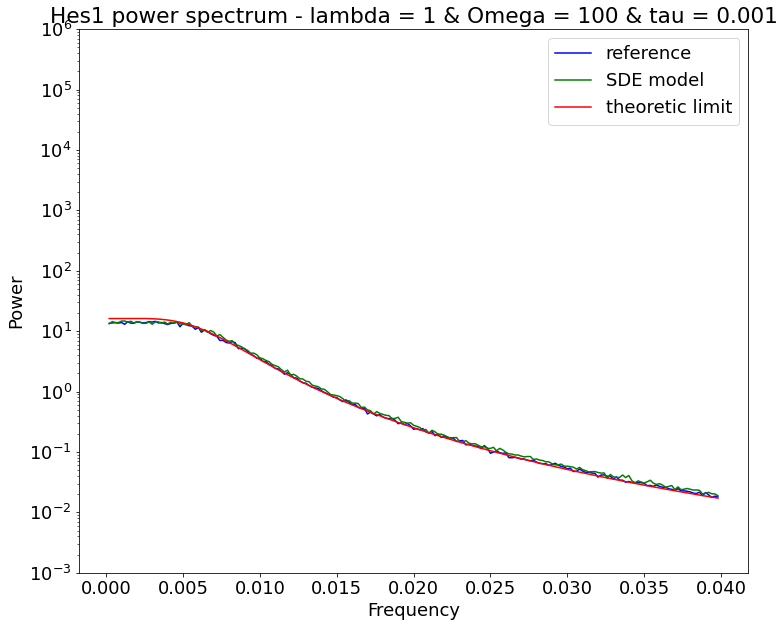

lambda= 1
Omega= 100
tau= 18.5


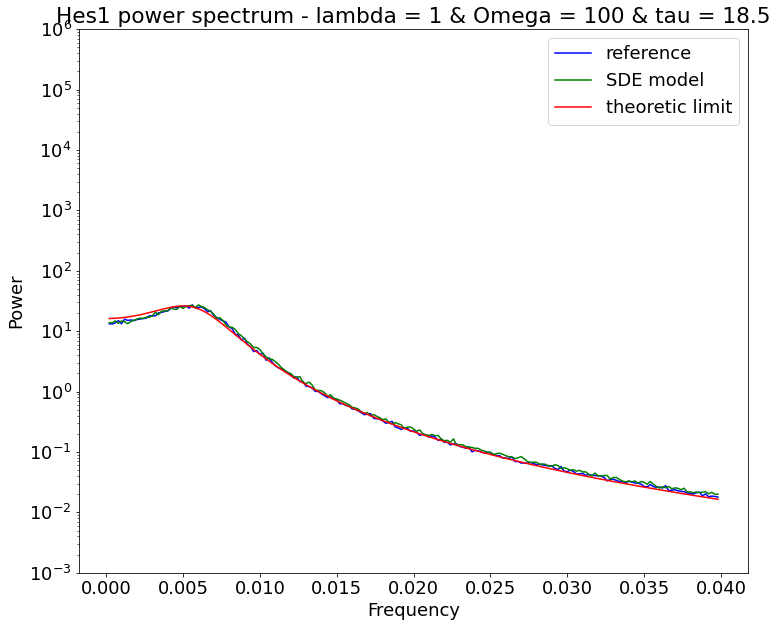

lambda= 1
Omega= 100
tau= 100


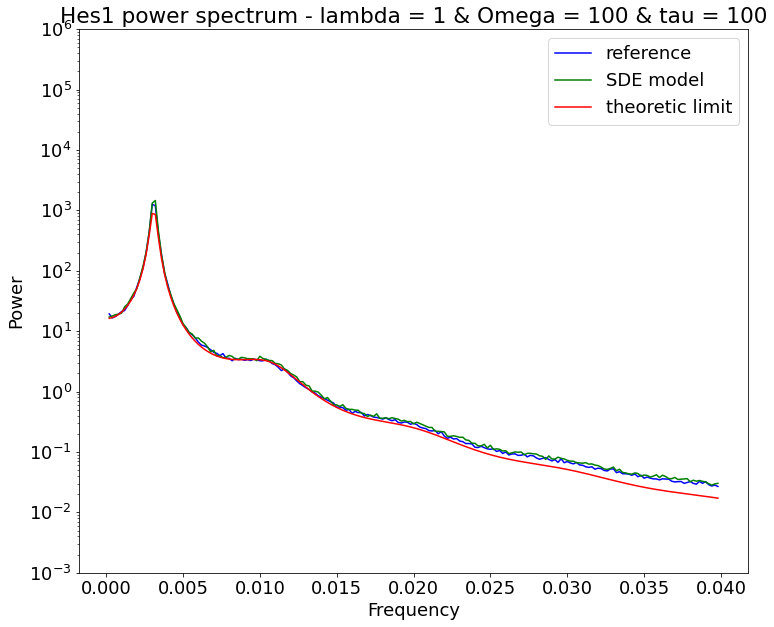

lambda= 10
Omega= 1
tau= 0.001


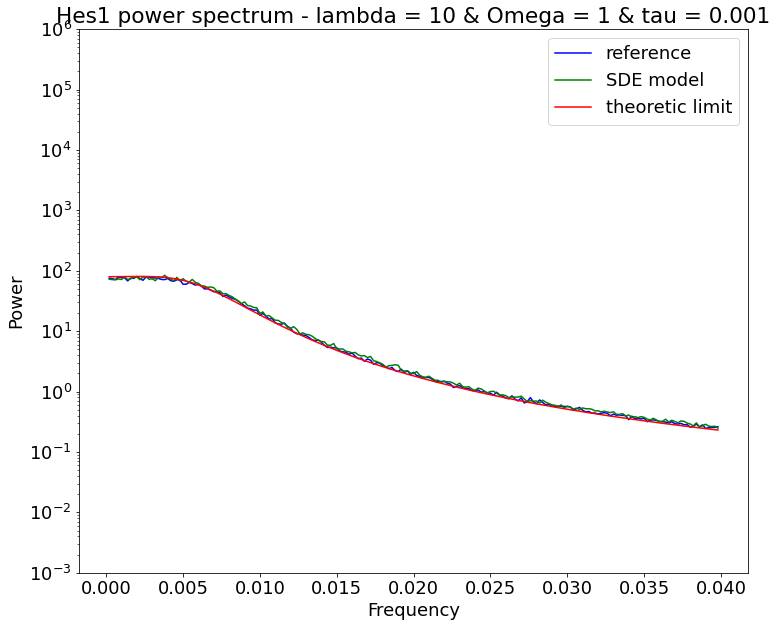

lambda= 10
Omega= 1
tau= 18.5


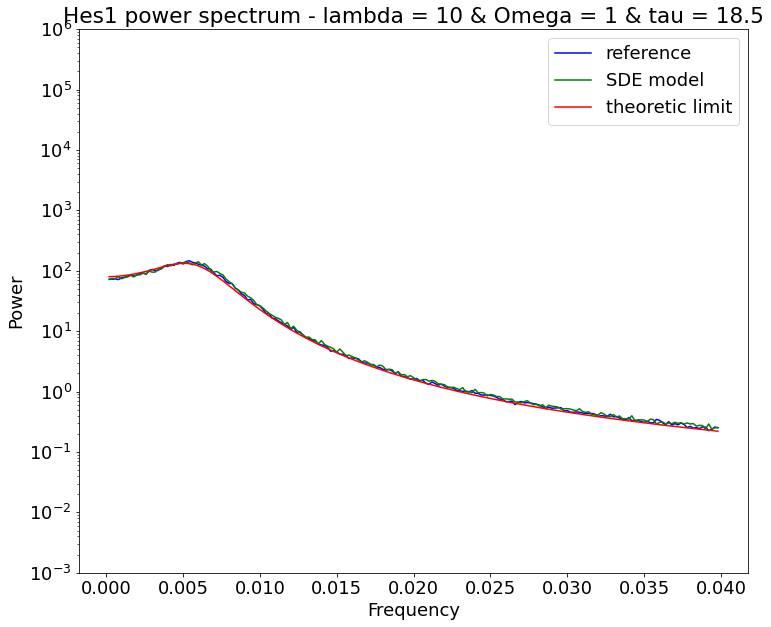

lambda= 10
Omega= 1
tau= 100


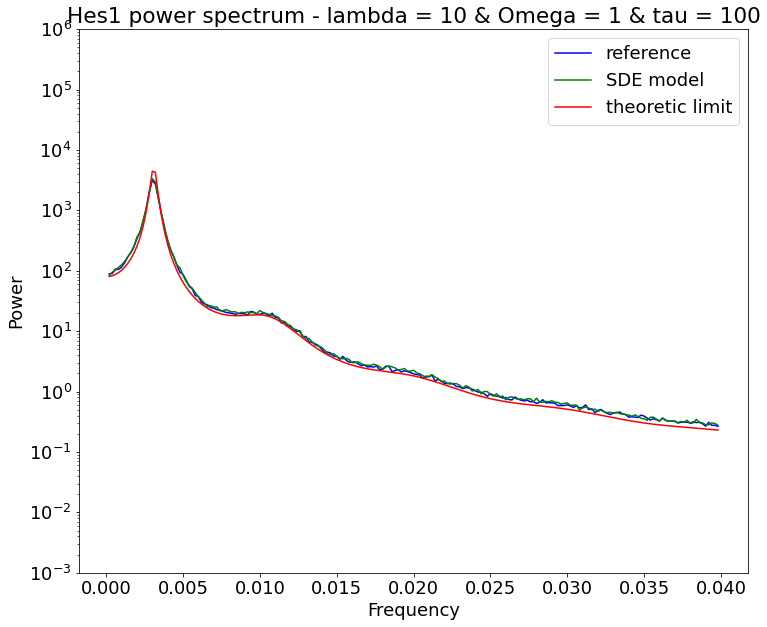

lambda= 10
Omega= 10
tau= 0.001


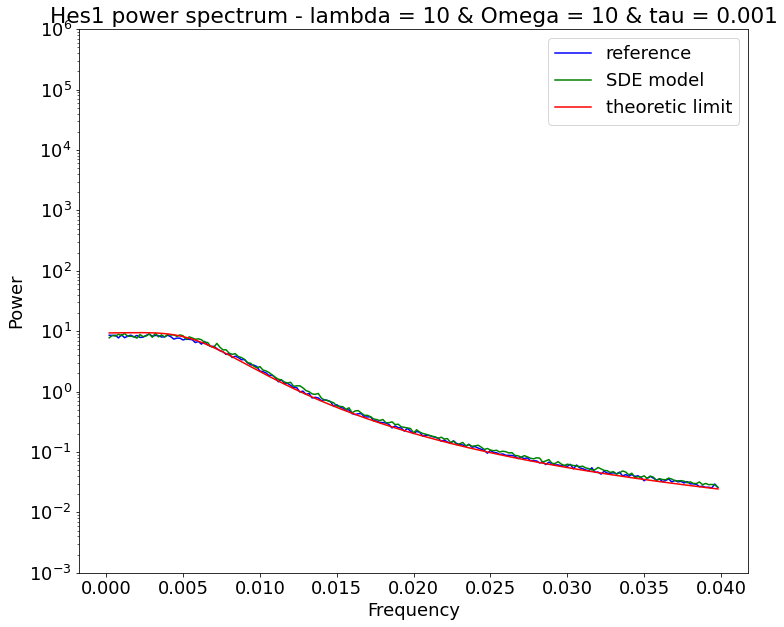

lambda= 10
Omega= 10
tau= 18.5


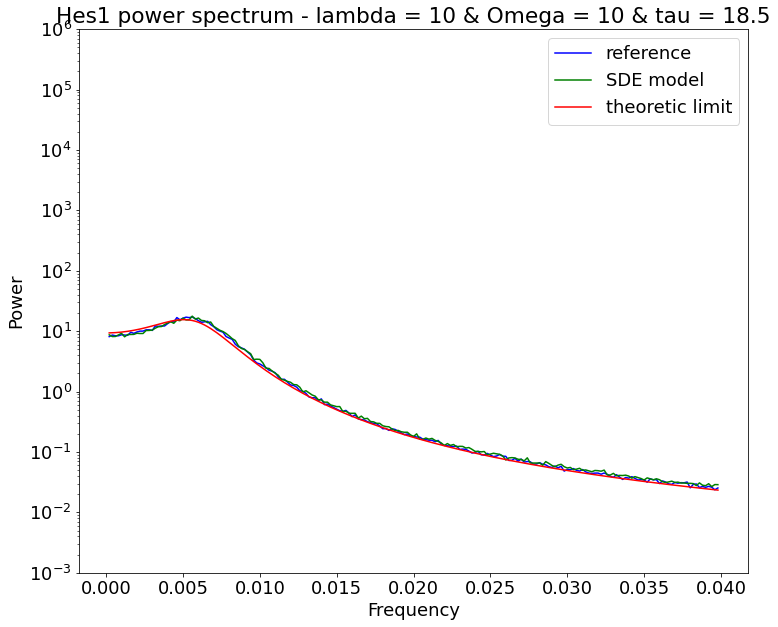

lambda= 10
Omega= 10
tau= 100


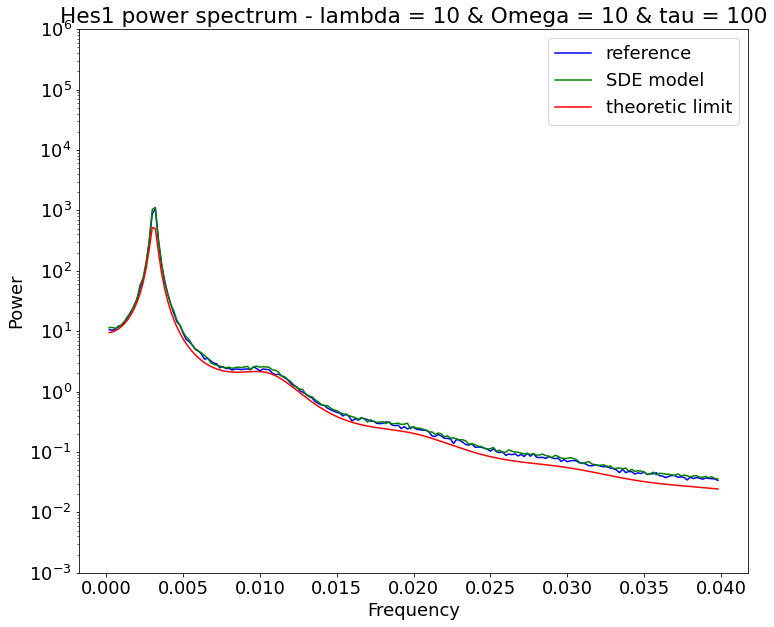

lambda= 10
Omega= 100
tau= 0.001


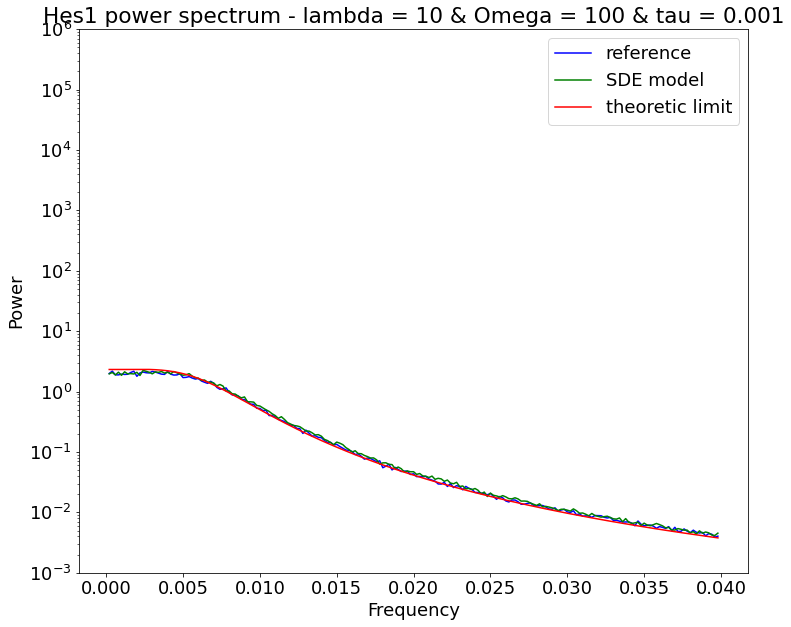

lambda= 10
Omega= 100
tau= 18.5


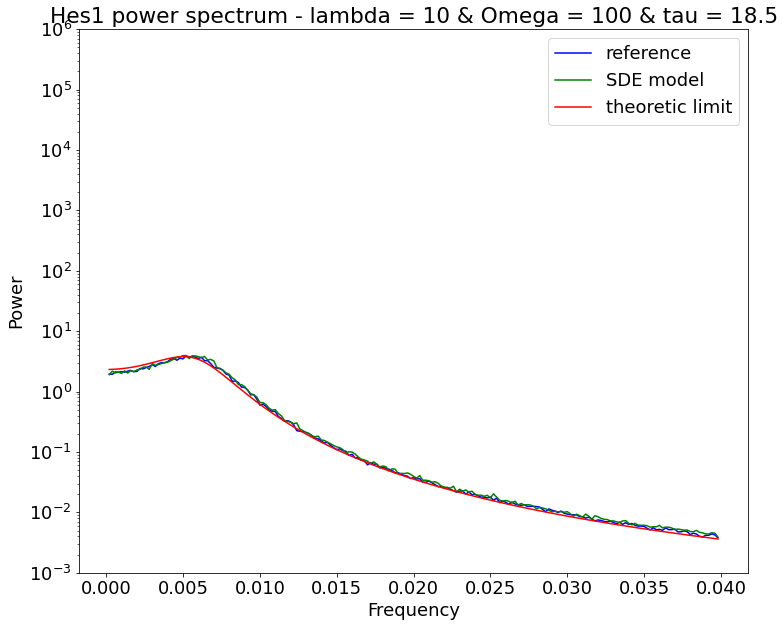

lambda= 10
Omega= 100
tau= 100


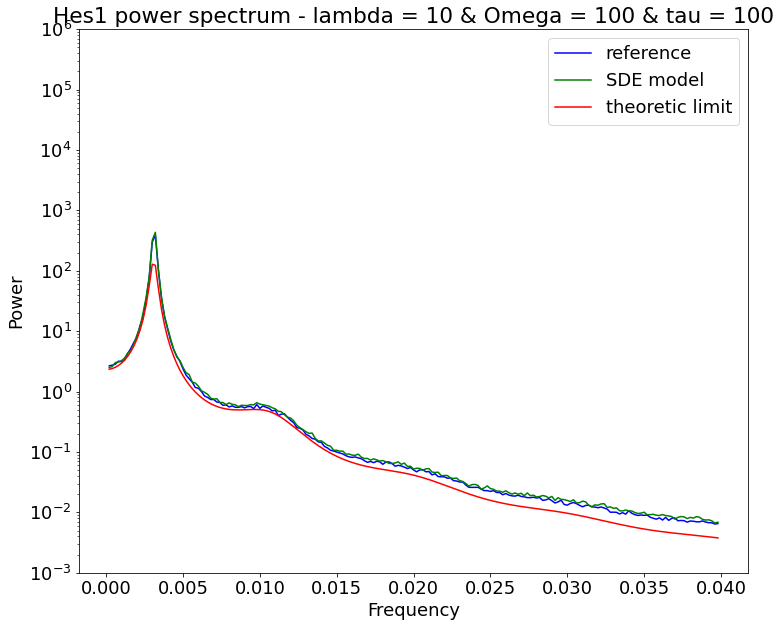

lambda= 100
Omega= 1
tau= 0.001


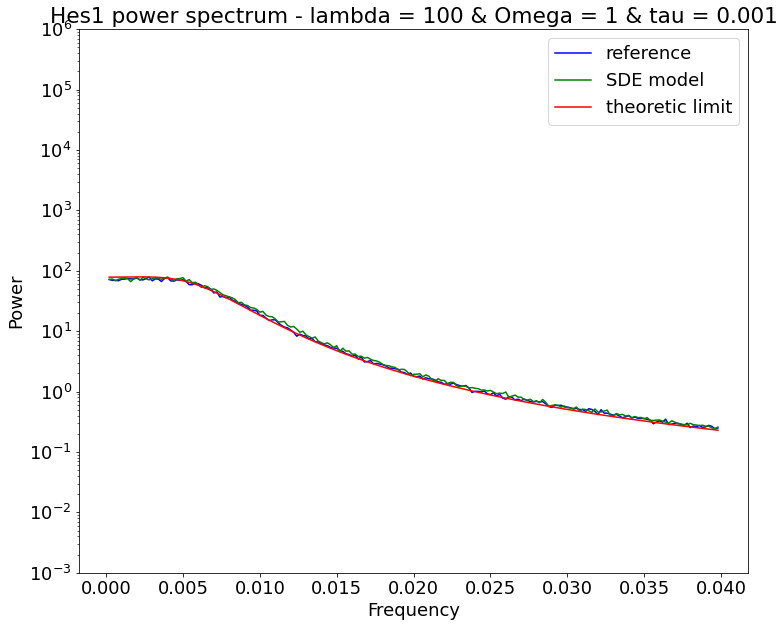

lambda= 100
Omega= 1
tau= 18.5


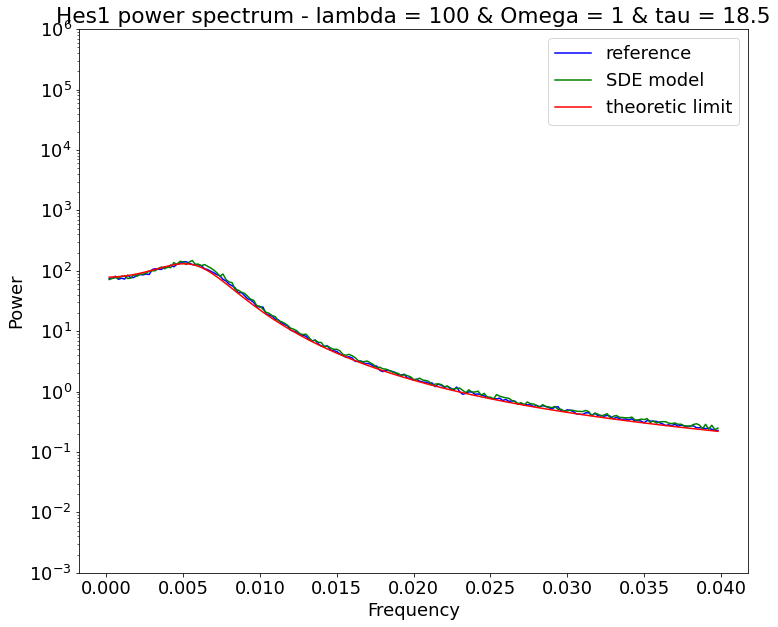

lambda= 100
Omega= 1
tau= 100


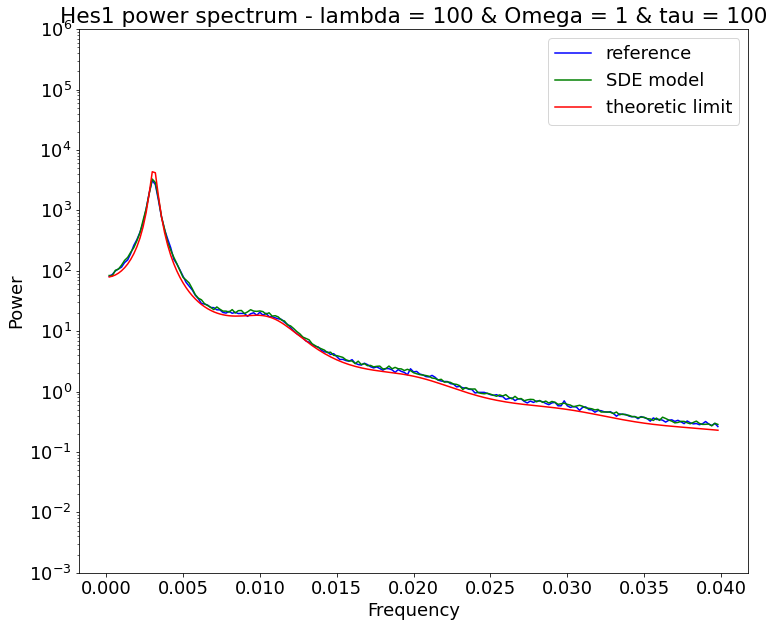

lambda= 100
Omega= 10
tau= 0.001


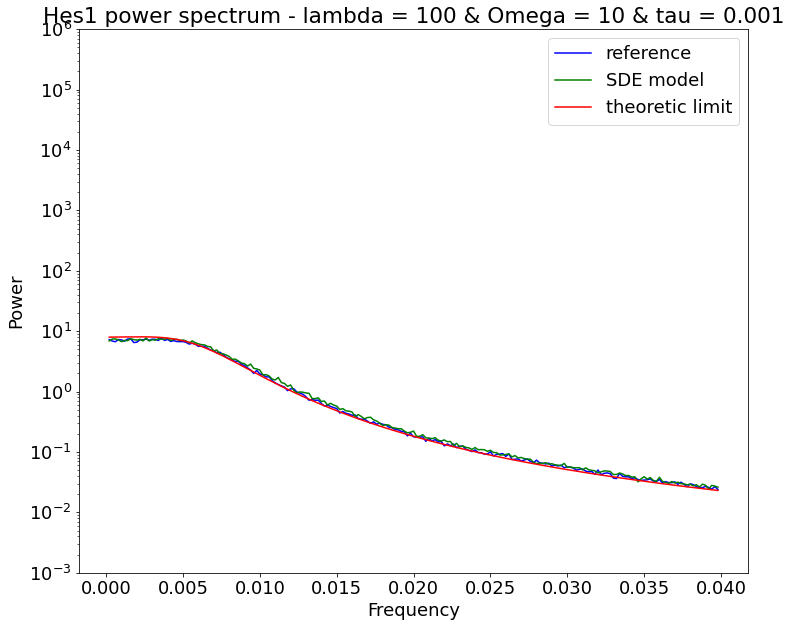

lambda= 100
Omega= 10
tau= 18.5


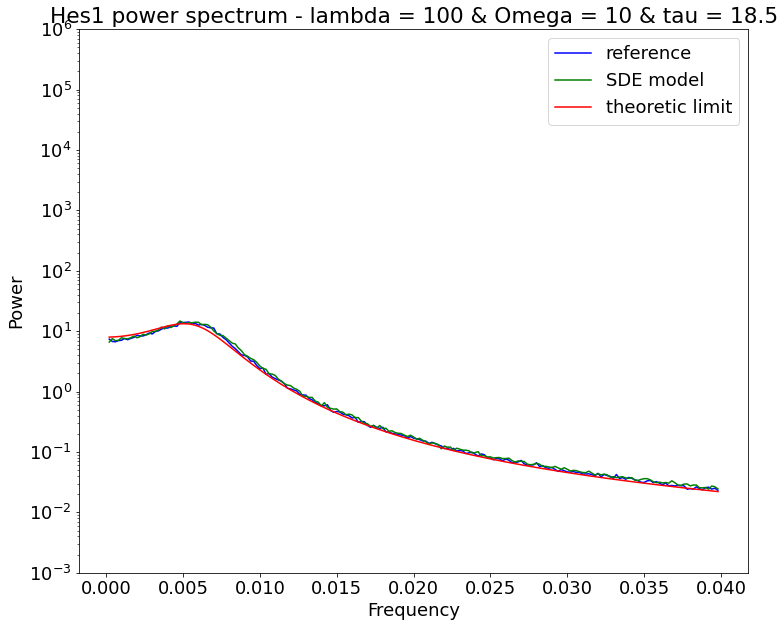

lambda= 100
Omega= 10
tau= 100


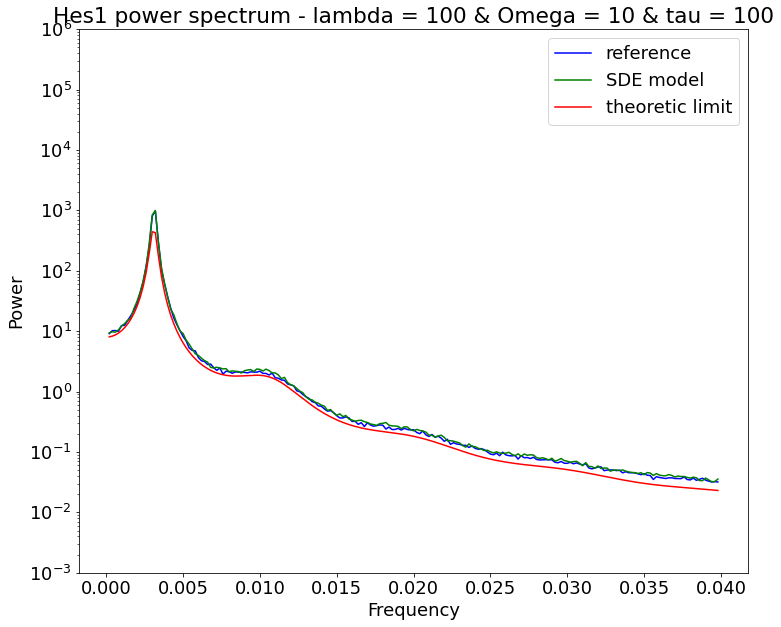

lambda= 100
Omega= 100
tau= 0.001


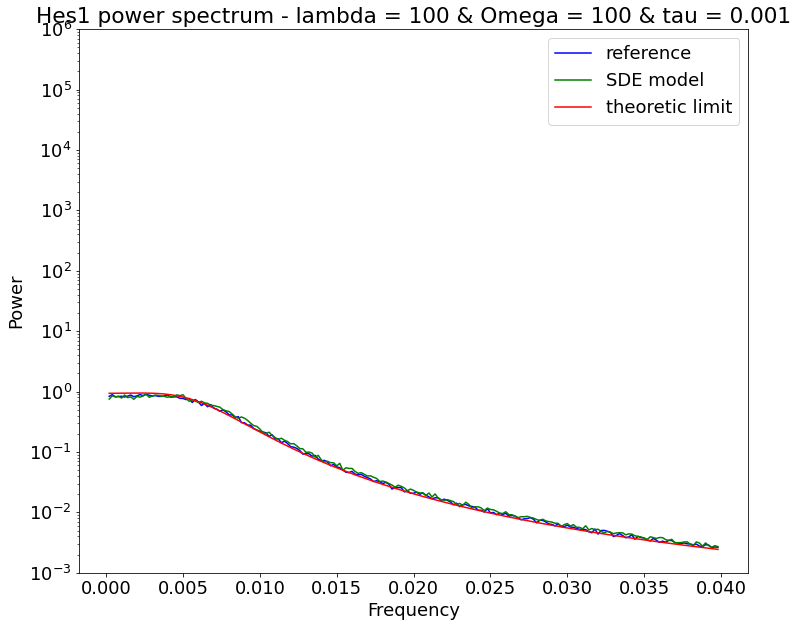

lambda= 100
Omega= 100
tau= 18.5


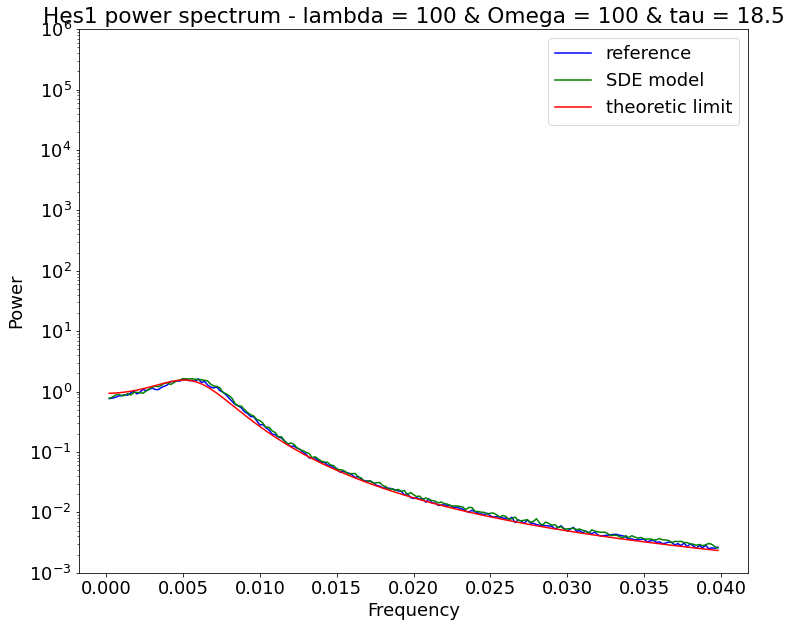

lambda= 100
Omega= 100
tau= 100


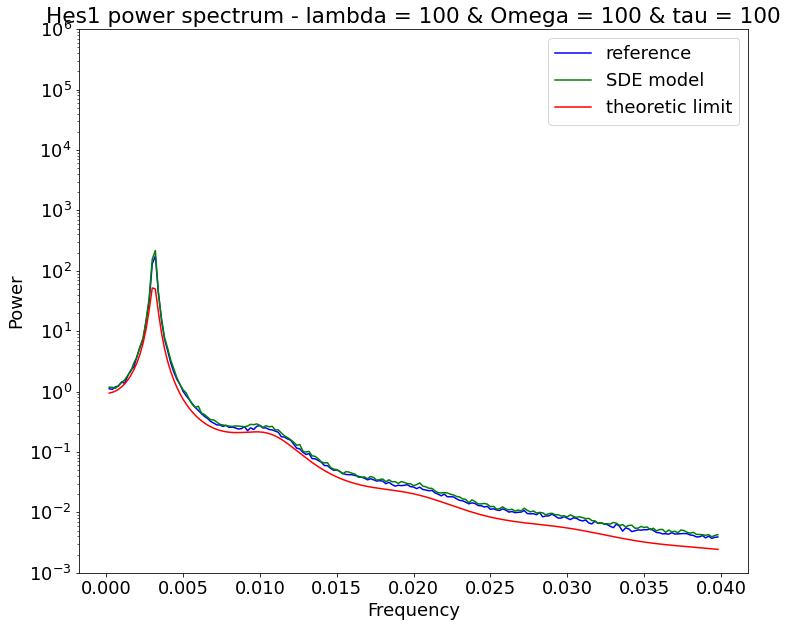

In [35]:
for i in range(n_lambda):
    for j in range(n_Omega):
        for k in range(n_tau):
        
            print('lambda=',val_lambda[i])    
            print('Omega=',val_Omega[j])
            print('tau=',val_tau[k])

            fig, ax1 = plt.subplots(figsize=(12,10)) 

            ax1.set_title('Hes1 power spectrum - lambda = ' + str(val_lambda[i]) + ' & Omega = ' +  str(val_Omega[j]) + ' & tau = ' + str(val_tau[k])) 
            ax1.set_xlabel('Frequency') 
            ax1.set_ylabel('Power') 

            freq_th,_,Sp=utils.lna_power_spectrum(lambda_s=val_lambda[i],P_0=1000,tau=val_tau[k],Omega=val_Omega[j],T=T/2,delta_t=1)

            linem,=ax1.plot(freq_ref[1:200]/(2*np.pi), power_spectrum_Pm[1:200,i,j,k], color = 'blue') 
            linel,=ax1.plot(freq_ref[1:200]/(2*np.pi), power_spectrum_Pl[1:200,i,j,k], color = 'green')
            linet,=ax1.plot(freq_th[1:200], Sp[1:200]/(n_t/2), color = 'red')   

            ax1.tick_params(axis ='y') 
            ax1.set_yscale('log')        
            ax1.legend([linem, linel, linet], ['reference', 'SDE model', 'theoretic limit'])

            #ax1.set_xlim(-0.04, 0.04)
            ax1.set_ylim(0.001, 1000000)
            
            plt.savefig(read_directory + '\\plots\\power_spectrum_P\\plot_power_spectrum_P - lambda' + str(val_lambda[i]) + 'and Omega' +  str(val_Omega[j]) + ' and tau' + str(val_tau[k]) + '.pdf')  

            plt.show()

### Computation time

Finally, we seek computation times. We make the table of the ratios
$$\frac{t_{Langevin}}{t_{Gillespie}}$$

In [ ]:
times_m=np.zeros((n_lambda,n_Omega,n_tau))
times_l=np.zeros((n_lambda,n_Omega,n_tau))


for i in range(n_lambda):
    for j in range(n_Omega):
        for k in range(n_tau):
            t0=time.time()
            
            tm,Mm,Pm=master.one_trajectory(tau=val_tau[k],lambda_s=val_lambda[i],Omega=val_Omega[j],P_0=100,T=10000)
            t1=time.time()
            
            tl,Ml,Pl=langevin.one_trajectory(tau=val_tau[k],lambda_s=val_lambda[i],Omega=val_Omega[j],P_0=100,T=10000)
            t2=time.time()
            
            times_m[i,j,k] = t1-t0
            times_l[i,j,k] = t2-t1

In [ ]:
pd.DataFrame((times_l/times_m).reshape((n_lambda*n_Omega*n_tau)),columns=['value']).to_csv('output/data/computation_times.csv')

In [ ]:
tab=pd.read_csv('output/data/computation_times.csv')['value'].values.reshape((n_lambda,n_Omega,n_tau))

In [ ]:
tab